# Upgrade tensorflow
I initially had big problems using the older version of tensorflow. I could make it work with tensorflow 2.19. Therefore i needed to include the following ugly block of upgrade updates.

In [1]:
!pip install -q -U tensorflow==2.19.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-tpu 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow-tpu 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.19.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


**Now i import the required libraries**

In [2]:
import numpy as np # linear algebra
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers, ops

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)




2025-07-20 20:09:51.198246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered


E0000 00:00:1753042191.220079      74 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753042191.227076      74 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753042191.246757      74 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753042191.246779      74 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753042191.246782      74 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753042191.246785      

74 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.


Number of replicas: 1


Lets check if we have the correct version of tensorflow.

In [3]:
print(tf.__version__)

2.19.0


# Data Import

In [4]:
main_dir = "/kaggle/input/gan-getting-started"

In [5]:
print("The directories for the data are: ", os.listdir(main_dir))

monet_dir = str(main_dir + "/" + os.listdir(main_dir)[0])
photo_dir = str(main_dir + "/" + os.listdir(main_dir)[2])

print("The number of Monet images is: ", len(os.listdir(monet_dir)))
print("The number of Photo images is: ", len(os.listdir(photo_dir)))

The directories for the data are:  ['monet_jpg', 'photo_tfrec', 'photo_jpg', 'monet_tfrec']


The number of Monet images is:  300


The number of Photo images is:  7038


I decided to use the jpg images from the folders and import them in small batches.

In [6]:
img_size = (256,256)

monet_dataset = keras.utils.image_dataset_from_directory(
    monet_dir, label_mode=None, image_size=img_size, batch_size=6
)

photo_dataset = keras.utils.image_dataset_from_directory(
    photo_dir, label_mode=None, image_size=img_size, batch_size=6
)

Found 300 files.


2025-07-20 20:10:03.846866: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 7038 files.


The two datasets are imported in batches meaning the total number of files reduces by a factor of 6. Lets check if that turns out correctly.

In [7]:
print(photo_dataset.cardinality().numpy())
print(monet_dataset.cardinality().numpy())

1173
50


# Data preprocessing


What do the pictures look like?

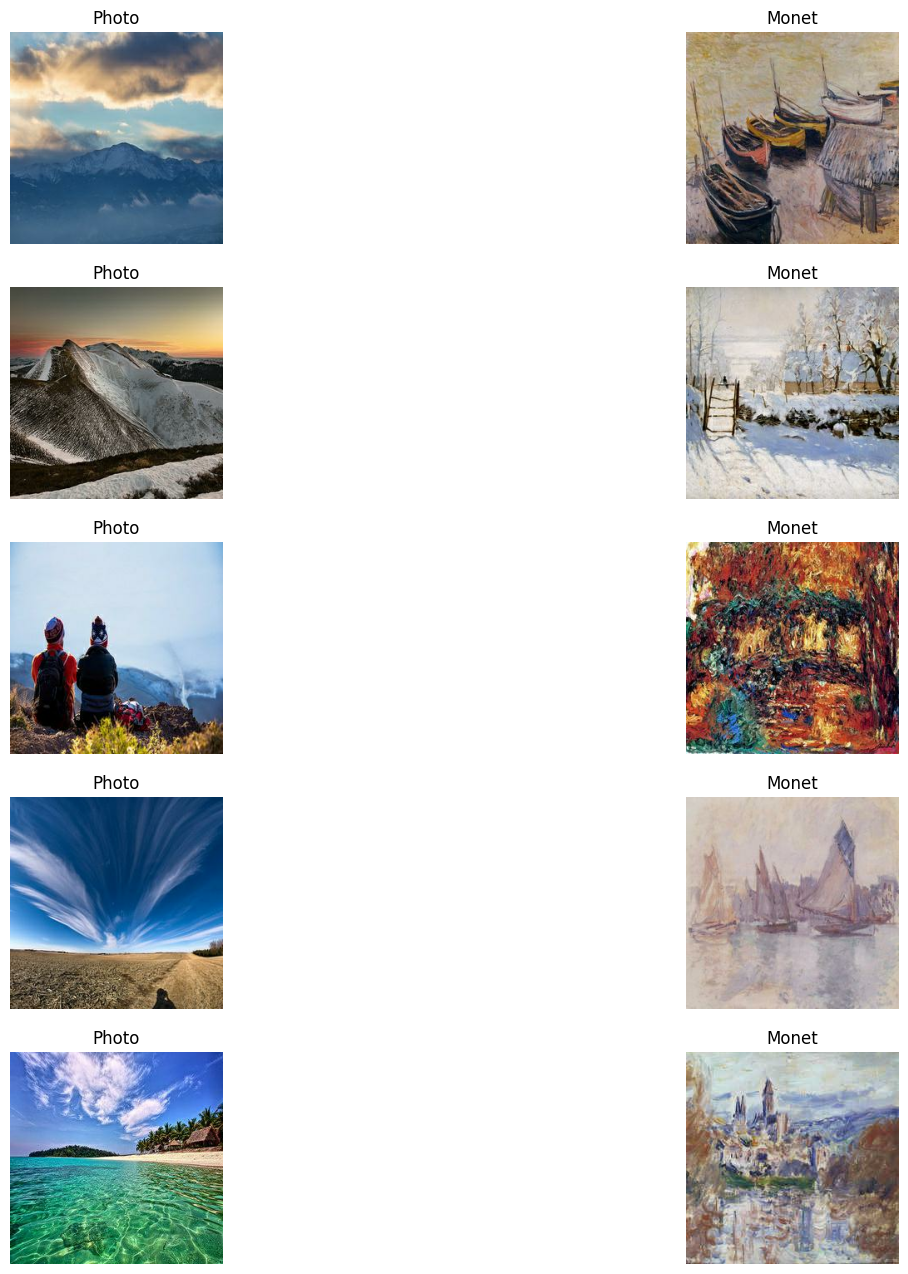

In [8]:
_, ax = plt.subplots(5, 2, figsize=(16, 16))


for i,photo_img in enumerate(photo_dataset.take(5)):
    photo_img = photo_img[0].numpy().astype(np.uint8)
    
    ax[i, 0].imshow(photo_img)
    
    ax[i, 0].set_title("Photo")
    
    ax[i, 0].axis("off")
    

for i,monet_img in enumerate(monet_dataset.take(5)):
    monet_img = monet_img[0].numpy().astype(np.uint8)
    ax[i, 1].imshow(monet_img)
    ax[i, 1].set_title("Monet")
    ax[i, 1].axis("off")
 


The pixels are stored in values in the range of 0 and 255, we will need to reshape the images to uniform distribution (-1,1). 

In [9]:
photo_dataset = photo_dataset.map(lambda x: (x /  127.5)-1)
monet_dataset = monet_dataset.map(lambda x: (x /  127.5)-1)

# Define model

This project os inspired by the excellent GAN Tutorial from Amy Jang which can be found here:
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

This project makes use of a U-Net. The U-Net has its name from the shape of if layers in which a Decoder uses small filters and a MaxPooling operation or larger strides in the filter to reduce the dimensions of the picture aggressively. After that it rebuilds the image using a decoder. The two sides of the U shaped layers are connected by skip connections which help retain some of the information that would be lost otherwise due to the aggressive downsampling of the features. 

My code changes the weights of the layers, introduced BatchNormalization and adds a transformation layer at the bottom of the U which can be found in many other cycleGANs. 

A nice description of the U-Net can be found here:
https://www.geeksforgeeks.org/machine-learning/u-net-architecture-explained/

The cycle GAN makes use of the general GAN structure in which a generator creates a fake image and tries to fool the discriminator. In the case of the cycle GAN and unlike the general GAN we can use unpaired data in which one part of the data represents a feature or style we want to create while we don't have an exact pair of this data.
Therefore the cycle GAN makes use of an additional generator wich translates the fake image back to its original in order to make sure that the generated image still retains most features of the original image. The loss is then calculated after both generators first create the fake image and then recreate the real image.

Again a nice description can be found here:
https://www.geeksforgeeks.org/machine-learning/cycle-generative-adversarial-network-cyclegan-2/

and here:
https://www.youtube.com/watch?v=-8hfnlxEPn4

**Transformer**

I added a transformer which basically is the bottom most layer of the U-Net. It is initialized with random weights and does not transform the input it receives from the downsampling therefore uses strides of 1 with padding of the outer layers.

In [10]:

def transformer(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization(gamma_initializer = gamma_init))

    result.add(layers.LeakyReLU())

    return result

**Downsampling/Decoding**

Here the Downsampling function is defined which decreases the number of features by applying an aggressive filter with stride = 2.

In [11]:
OUTPUT_CHANNELS = 3

def downsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization(gamma_initializer = gamma_init))

    result.add(layers.LeakyReLU())

    return result

**Upsampling/Encoding**

Here the upsampling function is defined. The upsampling is done via a Conv2D Transpose layer. This layer does the exact opposite of the normal Conv2D Filter layer, it increases the dimensions. 

In [12]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()

    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.BatchNormalization(gamma_initializer = gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

**Generator**

The generator function defines the amount of filters and the size of filters that are applied. It iterates over a list of these values which it applies to the respective sampling and transforming functions. It also connects the layers via skip connections.

In [13]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])
    

     # bs = batch size
    down_stack = [
        downsample(64, 4), # size = 128
        downsample(128, 4), # size = 64
        downsample(256, 4), # size = 32
        downsample(512, 4), # size = 16
        downsample(512, 4), # size = 8
        downsample(1024, 4), # size = 4

    ]

    up_stack = [

        upsample(1024, 4, apply_dropout=True), # size = 8
        upsample(512, 4), # size = 16
        upsample(256, 4), # size = 32
        upsample(128, 4), # size = 64
        upsample(64, 4), # size = 128
    ]

    # Transformer
    transformer_stack = [
        transformer(1024,3), #keeps size of data
        transformer(1024,3),
        #transformer(1024,3),
        #transformer(1024,3)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') 

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Here the transformation layer is applied
    for transform in transformer_stack:
        x = transform(x)
    
    # We call the upsampling function and concatenate the weights of the downsampling layer
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

**Discriminator**

In [14]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4)(x) # size = 128
    down2 = downsample(64, 4)(down1) # size = 64
    down3 = downsample(256, 4)(down2) # size = 32

    zero_pad1 = layers.ZeroPadding2D()(down3) # size = 34
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # size = 31

    leaky_relu = layers.LeakyReLU()(conv)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # size = 33

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # size = 30

    return tf.keras.Model(inputs=inp, outputs=last)

**Initialize classes**

In [15]:
with strategy.scope():
    monet_generator = Generator() 
    photo_generator = Generator() 

    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator() 

**Define GAN Class**

In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

**Calculate the loss functions**

In [17]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [18]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [19]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [20]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [21]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [22]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [23]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=30,
    verbose = 1
)

Epoch 1/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 30:25 37s/step - monet_disc_loss: 0.6929 - monet_gen_loss: 11.8361 - photo_disc_loss: 0.6931 - photo_gen_loss: 11.9374

 2/50 ━━━━━━━━━━━━━━━━━━━━ 4:00 5s/step - monet_disc_loss: 0.6923 - monet_gen_loss: 12.1230 - photo_disc_loss: 0.6926 - photo_gen_loss: 12.4555  

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:55 5s/step - monet_disc_loss: 0.6913 - monet_gen_loss: 11.6091 - photo_disc_loss: 0.6917 - photo_gen_loss: 12.0847

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:46 5s/step - monet_disc_loss: 0.6899 - monet_gen_loss: 11.5922 - photo_disc_loss: 0.6906 - photo_gen_loss: 12.0682

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:40 5s/step - monet_disc_loss: 0.6876 - monet_gen_loss: 11.5793 - photo_disc_loss: 0.6890 - photo_gen_loss: 12.0440

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:32 5s/step - monet_disc_loss: 0.6847 - monet_gen_loss: 11.5428 - photo_disc_loss: 0.6862 - photo_gen_loss: 12.0225

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:24 5s/step - monet_disc_loss: 0.6801 - monet_gen_loss: 11.7180 - photo_disc_loss: 0.6820 - photo_gen_loss: 12.2813

 8/50 ━━━━━━━━━━━━━━━━━━━━ 3:16 5s/step - monet_disc_loss: 0.6733 - monet_gen_loss: 11.6850 - photo_disc_loss: 0.6764 - photo_gen_loss: 12.2069

 9/50 ━━━━━━━━━━━━━━━━━━━━ 3:09 5s/step - monet_disc_loss: 0.6650 - monet_gen_loss: 11.7141 - photo_disc_loss: 0.6697 - photo_gen_loss: 12.1857

10/50 ━━━━━━━━━━━━━━━━━━━━ 3:02 5s/step - monet_disc_loss: 0.6565 - monet_gen_loss: 11.7205 - photo_disc_loss: 0.6606 - photo_gen_loss: 12.2103

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:56 5s/step - monet_disc_loss: 0.6464 - monet_gen_loss: 11.7229 - photo_disc_loss: 0.6516 - photo_gen_loss: 12.1742

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:51 5s/step - monet_disc_loss: 0.6354 - monet_gen_loss: 11.6850 - photo_disc_loss: 0.6422 - photo_gen_loss: 12.1001

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:45 4s/step - monet_disc_loss: 0.6256 - monet_gen_loss: 11.6962 - photo_disc_loss: 0.6314 - photo_gen_loss: 12.1132

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - monet_disc_loss: 0.6160 - monet_gen_loss: 11.6231 - photo_disc_loss: 0.6207 - photo_gen_loss: 12.0526

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - monet_disc_loss: 0.6048 - monet_gen_loss: 11.5550 - photo_disc_loss: 0.6097 - photo_gen_loss: 11.9557

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - monet_disc_loss: 0.5931 - monet_gen_loss: 11.5859 - photo_disc_loss: 0.5982 - photo_gen_loss: 12.0018

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - monet_disc_loss: 0.5803 - monet_gen_loss: 11.5792 - photo_disc_loss: 0.5855 - photo_gen_loss: 12.0071

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - monet_disc_loss: 0.5687 - monet_gen_loss: 11.5746 - photo_disc_loss: 0.5735 - photo_gen_loss: 12.0061

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - monet_disc_loss: 0.5553 - monet_gen_loss: 11.5391 - photo_disc_loss: 0.5619 - photo_gen_loss: 11.9655

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:12 4s/step - monet_disc_loss: 0.5431 - monet_gen_loss: 11.4843 - photo_disc_loss: 0.5500 - photo_gen_loss: 11.9075

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - monet_disc_loss: 0.5306 - monet_gen_loss: 11.4428 - photo_disc_loss: 0.5378 - photo_gen_loss: 11.8615

22/50 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - monet_disc_loss: 0.5190 - monet_gen_loss: 11.4244 - photo_disc_loss: 0.5273 - photo_gen_loss: 11.8447

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - monet_disc_loss: 0.5078 - monet_gen_loss: 11.3677 - photo_disc_loss: 0.5148 - photo_gen_loss: 11.7881

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step - monet_disc_loss: 0.4960 - monet_gen_loss: 11.3611 - photo_disc_loss: 0.5043 - photo_gen_loss: 11.7909

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:50 4s/step - monet_disc_loss: 0.4849 - monet_gen_loss: 11.3308 - photo_disc_loss: 0.4937 - photo_gen_loss: 11.7418

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - monet_disc_loss: 0.4747 - monet_gen_loss: 11.3827 - photo_disc_loss: 0.4807 - photo_gen_loss: 11.8173

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - monet_disc_loss: 0.4633 - monet_gen_loss: 11.4082 - photo_disc_loss: 0.4691 - photo_gen_loss: 11.8793

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - monet_disc_loss: 0.4524 - monet_gen_loss: 11.4848 - photo_disc_loss: 0.4580 - photo_gen_loss: 11.9517

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:32 4s/step - monet_disc_loss: 0.4413 - monet_gen_loss: 11.4815 - photo_disc_loss: 0.4465 - photo_gen_loss: 11.9509

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - monet_disc_loss: 0.4296 - monet_gen_loss: 11.4915 - photo_disc_loss: 0.4350 - photo_gen_loss: 11.9625

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/step - monet_disc_loss: 0.4186 - monet_gen_loss: 11.5272 - photo_disc_loss: 0.4233 - photo_gen_loss: 12.0072

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:18 4s/step - monet_disc_loss: 0.4074 - monet_gen_loss: 11.5686 - photo_disc_loss: 0.4122 - photo_gen_loss: 12.0275

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:14 4s/step - monet_disc_loss: 0.3977 - monet_gen_loss: 11.6222 - photo_disc_loss: 0.4011 - photo_gen_loss: 12.0961

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/step - monet_disc_loss: 0.3880 - monet_gen_loss: 11.6590 - photo_disc_loss: 0.3907 - photo_gen_loss: 12.1532

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - monet_disc_loss: 0.3786 - monet_gen_loss: 11.6737 - photo_disc_loss: 0.3806 - photo_gen_loss: 12.1846

36/50 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - monet_disc_loss: 0.3698 - monet_gen_loss: 11.6655 - photo_disc_loss: 0.3717 - photo_gen_loss: 12.1851

37/50 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - monet_disc_loss: 0.3611 - monet_gen_loss: 11.6768 - photo_disc_loss: 0.3638 - photo_gen_loss: 12.1879 

38/50 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - monet_disc_loss: 0.3526 - monet_gen_loss: 11.6790 - photo_disc_loss: 0.3557 - photo_gen_loss: 12.2064

39/50 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - monet_disc_loss: 0.3442 - monet_gen_loss: 11.6991 - photo_disc_loss: 0.3478 - photo_gen_loss: 12.2217

40/50 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - monet_disc_loss: 0.3362 - monet_gen_loss: 11.7624 - photo_disc_loss: 0.3403 - photo_gen_loss: 12.2654

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.3290 - monet_gen_loss: 11.7896 - photo_disc_loss: 0.3331 - photo_gen_loss: 12.2788

42/50 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - monet_disc_loss: 0.3223 - monet_gen_loss: 11.8073 - photo_disc_loss: 0.3258 - photo_gen_loss: 12.3200

43/50 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - monet_disc_loss: 0.3159 - monet_gen_loss: 11.8308 - photo_disc_loss: 0.3191 - photo_gen_loss: 12.3624

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.3098 - monet_gen_loss: 11.8450 - photo_disc_loss: 0.3124 - photo_gen_loss: 12.3648

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.3037 - monet_gen_loss: 11.8486 - photo_disc_loss: 0.3059 - photo_gen_loss: 12.3753

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.2979 - monet_gen_loss: 11.8837 - photo_disc_loss: 0.2997 - photo_gen_loss: 12.4007

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.2920 - monet_gen_loss: 11.9107 - photo_disc_loss: 0.2937 - photo_gen_loss: 12.4309

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.2873 - monet_gen_loss: 11.9341 - photo_disc_loss: 0.2880 - photo_gen_loss: 12.4581 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.2851 - monet_gen_loss: 11.9238 - photo_disc_loss: 0.2824 - photo_gen_loss: 12.5015

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.2836 - monet_gen_loss: 11.9420 - photo_disc_loss: 0.2775 - photo_gen_loss: 12.4941

50/50 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - monet_disc_loss: 0.2823 - monet_gen_loss: 11.9594 - photo_disc_loss: 0.2727 - photo_gen_loss: 12.4869


Epoch 2/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:48 5s/step - monet_disc_loss: 0.0129 - monet_gen_loss: 14.3115 - photo_disc_loss: 0.0314 - photo_gen_loss: 13.3951

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:45 5s/step - monet_disc_loss: 0.0128 - monet_gen_loss: 14.5323 - photo_disc_loss: 0.0255 - photo_gen_loss: 14.7060

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:37 5s/step - monet_disc_loss: 0.0124 - monet_gen_loss: 14.3967 - photo_disc_loss: 0.0409 - photo_gen_loss: 15.0395

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:24 4s/step - monet_disc_loss: 0.0130 - monet_gen_loss: 14.4861 - photo_disc_loss: 0.0593 - photo_gen_loss: 14.4514

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:18 4s/step - monet_disc_loss: 0.0144 - monet_gen_loss: 13.9636 - photo_disc_loss: 0.1644 - photo_gen_loss: 14.1650

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - monet_disc_loss: 0.0183 - monet_gen_loss: 13.6531 - photo_disc_loss: 0.2817 - photo_gen_loss: 13.9229

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:08 4s/step - monet_disc_loss: 0.0180 - monet_gen_loss: 13.5572 - photo_disc_loss: 0.2472 - photo_gen_loss: 13.8359

 8/50 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - monet_disc_loss: 0.0179 - monet_gen_loss: 13.4647 - photo_disc_loss: 0.2361 - photo_gen_loss: 13.6775

 9/50 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - monet_disc_loss: 0.0202 - monet_gen_loss: 13.3448 - photo_disc_loss: 0.2160 - photo_gen_loss: 13.5391

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - monet_disc_loss: 0.0273 - monet_gen_loss: 13.2817 - photo_disc_loss: 0.1961 - photo_gen_loss: 13.6800

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - monet_disc_loss: 0.0683 - monet_gen_loss: 13.3159 - photo_disc_loss: 0.1812 - photo_gen_loss: 13.6049

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:45 4s/step - monet_disc_loss: 0.0816 - monet_gen_loss: 13.0285 - photo_disc_loss: 0.1674 - photo_gen_loss: 13.5959

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:40 4s/step - monet_disc_loss: 0.0778 - monet_gen_loss: 13.1734 - photo_disc_loss: 0.1555 - photo_gen_loss: 13.7062

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - monet_disc_loss: 0.0761 - monet_gen_loss: 13.2770 - photo_disc_loss: 0.1453 - photo_gen_loss: 13.7822

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - monet_disc_loss: 0.0743 - monet_gen_loss: 13.3038 - photo_disc_loss: 0.1370 - photo_gen_loss: 13.7671

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:27 4s/step - monet_disc_loss: 0.0713 - monet_gen_loss: 13.3633 - photo_disc_loss: 0.1326 - photo_gen_loss: 13.7838

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - monet_disc_loss: 0.0678 - monet_gen_loss: 13.4370 - photo_disc_loss: 0.1260 - photo_gen_loss: 13.8448

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - monet_disc_loss: 0.0649 - monet_gen_loss: 13.4116 - photo_disc_loss: 0.1199 - photo_gen_loss: 13.8393

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:13 4s/step - monet_disc_loss: 0.0630 - monet_gen_loss: 13.4101 - photo_disc_loss: 0.1142 - photo_gen_loss: 13.8657

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - monet_disc_loss: 0.0632 - monet_gen_loss: 13.4442 - photo_disc_loss: 0.1104 - photo_gen_loss: 13.9130

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - monet_disc_loss: 0.0613 - monet_gen_loss: 13.3997 - photo_disc_loss: 0.1061 - photo_gen_loss: 13.8974

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:59 4s/step - monet_disc_loss: 0.0595 - monet_gen_loss: 13.3732 - photo_disc_loss: 0.1019 - photo_gen_loss: 13.8843

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - monet_disc_loss: 0.0574 - monet_gen_loss: 13.3452 - photo_disc_loss: 0.0987 - photo_gen_loss: 13.8686

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - monet_disc_loss: 0.0555 - monet_gen_loss: 13.4138 - photo_disc_loss: 0.0950 - photo_gen_loss: 13.9756

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/step - monet_disc_loss: 0.0537 - monet_gen_loss: 13.3870 - photo_disc_loss: 0.0919 - photo_gen_loss: 13.9549

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:42 4s/step - monet_disc_loss: 0.0520 - monet_gen_loss: 13.4061 - photo_disc_loss: 0.0889 - photo_gen_loss: 13.9828

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - monet_disc_loss: 0.0505 - monet_gen_loss: 13.4407 - photo_disc_loss: 0.0859 - photo_gen_loss: 14.0350

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:33 4s/step - monet_disc_loss: 0.0491 - monet_gen_loss: 13.4168 - photo_disc_loss: 0.0834 - photo_gen_loss: 14.0134

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - monet_disc_loss: 0.0480 - monet_gen_loss: 13.3812 - photo_disc_loss: 0.0810 - photo_gen_loss: 13.9848

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - monet_disc_loss: 0.0469 - monet_gen_loss: 13.3651 - photo_disc_loss: 0.0789 - photo_gen_loss: 13.9589

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - monet_disc_loss: 0.0459 - monet_gen_loss: 13.3094 - photo_disc_loss: 0.0770 - photo_gen_loss: 13.8834

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - monet_disc_loss: 0.0450 - monet_gen_loss: 13.3129 - photo_disc_loss: 0.0752 - photo_gen_loss: 13.8931

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - monet_disc_loss: 0.0474 - monet_gen_loss: 13.2678 - photo_disc_loss: 0.0734 - photo_gen_loss: 13.8583

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - monet_disc_loss: 0.0616 - monet_gen_loss: 13.1669 - photo_disc_loss: 0.0721 - photo_gen_loss: 13.8065

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:03 4s/step - monet_disc_loss: 0.0695 - monet_gen_loss: 13.1662 - photo_disc_loss: 0.0704 - photo_gen_loss: 13.7579

36/50 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - monet_disc_loss: 0.0687 - monet_gen_loss: 13.1669 - photo_disc_loss: 0.0690 - photo_gen_loss: 13.7123 

37/50 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - monet_disc_loss: 0.0674 - monet_gen_loss: 13.1548 - photo_disc_loss: 0.0678 - photo_gen_loss: 13.6773

38/50 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - monet_disc_loss: 0.0663 - monet_gen_loss: 13.1563 - photo_disc_loss: 0.0670 - photo_gen_loss: 13.6662

39/50 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - monet_disc_loss: 0.0655 - monet_gen_loss: 13.1227 - photo_disc_loss: 0.0662 - photo_gen_loss: 13.6170

40/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - monet_disc_loss: 0.0647 - monet_gen_loss: 13.0707 - photo_disc_loss: 0.0650 - photo_gen_loss: 13.6001

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.0649 - monet_gen_loss: 12.9990 - photo_disc_loss: 0.0638 - photo_gen_loss: 13.5716

42/50 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - monet_disc_loss: 0.0646 - monet_gen_loss: 12.9266 - photo_disc_loss: 0.0627 - photo_gen_loss: 13.5415

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.0635 - monet_gen_loss: 12.9265 - photo_disc_loss: 0.0687 - photo_gen_loss: 13.4985

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.0636 - monet_gen_loss: 12.9092 - photo_disc_loss: 0.1262 - photo_gen_loss: 13.3666

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.0638 - monet_gen_loss: 12.8799 - photo_disc_loss: 0.1268 - photo_gen_loss: 13.3824

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.0633 - monet_gen_loss: 12.8447 - photo_disc_loss: 0.1448 - photo_gen_loss: 13.3970

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.0627 - monet_gen_loss: 12.7824 - photo_disc_loss: 0.1440 - photo_gen_loss: 13.3082

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.0621 - monet_gen_loss: 12.7573 - photo_disc_loss: 0.1474 - photo_gen_loss: 13.2172 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.0613 - monet_gen_loss: 12.7468 - photo_disc_loss: 0.1505 - photo_gen_loss: 13.2121

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.0607 - monet_gen_loss: 12.7034 - photo_disc_loss: 0.1484 - photo_gen_loss: 13.1598

50/50 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - monet_disc_loss: 0.0600 - monet_gen_loss: 12.6617 - photo_disc_loss: 0.1464 - photo_gen_loss: 13.1094


Epoch 3/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:48 5s/step - monet_disc_loss: 0.0584 - monet_gen_loss: 11.9269 - photo_disc_loss: 0.0712 - photo_gen_loss: 10.9386

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:30 4s/step - monet_disc_loss: 0.0737 - monet_gen_loss: 10.9896 - photo_disc_loss: 0.0688 - photo_gen_loss: 11.2933

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:20 4s/step - monet_disc_loss: 0.0709 - monet_gen_loss: 11.3361 - photo_disc_loss: 0.0583 - photo_gen_loss: 11.4059

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - monet_disc_loss: 0.0749 - monet_gen_loss: 11.4876 - photo_disc_loss: 0.0537 - photo_gen_loss: 11.3702

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:14 4s/step - monet_disc_loss: 0.0894 - monet_gen_loss: 11.0585 - photo_disc_loss: 0.0494 - photo_gen_loss: 11.2421

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - monet_disc_loss: 0.0888 - monet_gen_loss: 11.3217 - photo_disc_loss: 0.0597 - photo_gen_loss: 11.2696

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:09 4s/step - monet_disc_loss: 0.0879 - monet_gen_loss: 11.4692 - photo_disc_loss: 0.0857 - photo_gen_loss: 11.0819

 8/50 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - monet_disc_loss: 0.1302 - monet_gen_loss: 10.9846 - photo_disc_loss: 0.2384 - photo_gen_loss: 11.0870

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - monet_disc_loss: 0.1550 - monet_gen_loss: 11.2901 - photo_disc_loss: 0.2918 - photo_gen_loss: 11.2383

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - monet_disc_loss: 0.2238 - monet_gen_loss: 10.9018 - photo_disc_loss: 0.2957 - photo_gen_loss: 11.2116

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - monet_disc_loss: 0.2780 - monet_gen_loss: 10.9970 - photo_disc_loss: 0.2984 - photo_gen_loss: 11.0556

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - monet_disc_loss: 0.3734 - monet_gen_loss: 10.7456 - photo_disc_loss: 0.2915 - photo_gen_loss: 10.9052

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:45 4s/step - monet_disc_loss: 0.4226 - monet_gen_loss: 10.7369 - photo_disc_loss: 0.2775 - photo_gen_loss: 10.8896

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:40 4s/step - monet_disc_loss: 0.4065 - monet_gen_loss: 10.6957 - photo_disc_loss: 0.2612 - photo_gen_loss: 10.8514

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - monet_disc_loss: 0.3937 - monet_gen_loss: 10.6450 - photo_disc_loss: 0.2469 - photo_gen_loss: 10.8350

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - monet_disc_loss: 0.3962 - monet_gen_loss: 10.5615 - photo_disc_loss: 0.2340 - photo_gen_loss: 10.7597

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - monet_disc_loss: 0.4212 - monet_gen_loss: 10.4131 - photo_disc_loss: 0.2221 - photo_gen_loss: 10.7687

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - monet_disc_loss: 0.4768 - monet_gen_loss: 10.5409 - photo_disc_loss: 0.2145 - photo_gen_loss: 10.7693

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - monet_disc_loss: 0.4693 - monet_gen_loss: 10.4085 - photo_disc_loss: 0.2063 - photo_gen_loss: 10.6766

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:13 4s/step - monet_disc_loss: 0.4615 - monet_gen_loss: 10.2746 - photo_disc_loss: 0.1983 - photo_gen_loss: 10.6093

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - monet_disc_loss: 0.4467 - monet_gen_loss: 10.2516 - photo_disc_loss: 0.1901 - photo_gen_loss: 10.6123

22/50 ━━━━━━━━━━━━━━━━━━━━ 2:05 4s/step - monet_disc_loss: 0.4341 - monet_gen_loss: 10.2670 - photo_disc_loss: 0.1828 - photo_gen_loss: 10.6138

23/50 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - monet_disc_loss: 0.4270 - monet_gen_loss: 10.1850 - photo_disc_loss: 0.1758 - photo_gen_loss: 10.6334

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - monet_disc_loss: 0.4208 - monet_gen_loss: 10.1122 - photo_disc_loss: 0.1697 - photo_gen_loss: 10.6194

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - monet_disc_loss: 0.4139 - monet_gen_loss: 10.0641 - photo_disc_loss: 0.1641 - photo_gen_loss: 10.5953

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/step - monet_disc_loss: 0.4093 - monet_gen_loss: 9.9445 - photo_disc_loss: 0.1587 - photo_gen_loss: 10.5691 

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:42 4s/step - monet_disc_loss: 0.4596 - monet_gen_loss: 9.9976 - photo_disc_loss: 0.1547 - photo_gen_loss: 10.5645

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - monet_disc_loss: 0.4763 - monet_gen_loss: 9.8770 - photo_disc_loss: 0.1500 - photo_gen_loss: 10.5481

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:33 4s/step - monet_disc_loss: 0.4701 - monet_gen_loss: 9.8223 - photo_disc_loss: 0.1459 - photo_gen_loss: 10.5131

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - monet_disc_loss: 0.4680 - monet_gen_loss: 9.8131 - photo_disc_loss: 0.1420 - photo_gen_loss: 10.5245

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - monet_disc_loss: 0.4806 - monet_gen_loss: 9.7875 - photo_disc_loss: 0.1411 - photo_gen_loss: 10.5322

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - monet_disc_loss: 0.4896 - monet_gen_loss: 9.6950 - photo_disc_loss: 0.1388 - photo_gen_loss: 10.4796

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:15 4s/step - monet_disc_loss: 0.5284 - monet_gen_loss: 9.6885 - photo_disc_loss: 0.1365 - photo_gen_loss: 10.4806

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:11 4s/step - monet_disc_loss: 0.5461 - monet_gen_loss: 9.6870 - photo_disc_loss: 0.1341 - photo_gen_loss: 10.4622

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - monet_disc_loss: 0.5530 - monet_gen_loss: 9.6255 - photo_disc_loss: 0.1327 - photo_gen_loss: 10.4278

36/50 ━━━━━━━━━━━━━━━━━━━━ 1:02 4s/step - monet_disc_loss: 0.5468 - monet_gen_loss: 9.6225 - photo_disc_loss: 0.1299 - photo_gen_loss: 10.4697

37/50 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - monet_disc_loss: 0.5493 - monet_gen_loss: 9.5788 - photo_disc_loss: 0.1280 - photo_gen_loss: 10.4651 

38/50 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - monet_disc_loss: 0.5482 - monet_gen_loss: 9.5232 - photo_disc_loss: 0.1260 - photo_gen_loss: 10.4463

39/50 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - monet_disc_loss: 0.5496 - monet_gen_loss: 9.4975 - photo_disc_loss: 0.1239 - photo_gen_loss: 10.4360

40/50 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - monet_disc_loss: 0.5466 - monet_gen_loss: 9.4865 - photo_disc_loss: 0.1224 - photo_gen_loss: 10.4600

41/50 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - monet_disc_loss: 0.5399 - monet_gen_loss: 9.4381 - photo_disc_loss: 0.1215 - photo_gen_loss: 10.4432

42/50 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - monet_disc_loss: 0.5306 - monet_gen_loss: 9.4315 - photo_disc_loss: 0.1262 - photo_gen_loss: 10.4402

43/50 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - monet_disc_loss: 0.5248 - monet_gen_loss: 9.4313 - photo_disc_loss: 0.1427 - photo_gen_loss: 10.3748

44/50 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - monet_disc_loss: 0.5163 - monet_gen_loss: 9.4122 - photo_disc_loss: 0.1436 - photo_gen_loss: 10.3538

45/50 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - monet_disc_loss: 0.5085 - monet_gen_loss: 9.3806 - photo_disc_loss: 0.1475 - photo_gen_loss: 10.3025

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.5006 - monet_gen_loss: 9.3699 - photo_disc_loss: 0.1510 - photo_gen_loss: 10.3192

47/50 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - monet_disc_loss: 0.4958 - monet_gen_loss: 9.3327 - photo_disc_loss: 0.1715 - photo_gen_loss: 10.2971

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.4926 - monet_gen_loss: 9.3104 - photo_disc_loss: 0.1903 - photo_gen_loss: 10.2845 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.4885 - monet_gen_loss: 9.2861 - photo_disc_loss: 0.1934 - photo_gen_loss: 10.2387

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.4849 - monet_gen_loss: 9.2556 - photo_disc_loss: 0.1933 - photo_gen_loss: 10.2333

50/50 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - monet_disc_loss: 0.4814 - monet_gen_loss: 9.2264 - photo_disc_loss: 0.1932 - photo_gen_loss: 10.2281


Epoch 4/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:28 4s/step - monet_disc_loss: 0.1708 - monet_gen_loss: 7.8424 - photo_disc_loss: 0.3698 - photo_gen_loss: 8.1854

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:35 4s/step - monet_disc_loss: 0.1988 - monet_gen_loss: 7.8538 - photo_disc_loss: 0.2756 - photo_gen_loss: 7.7272

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:27 4s/step - monet_disc_loss: 0.1973 - monet_gen_loss: 8.3341 - photo_disc_loss: 0.2583 - photo_gen_loss: 8.6484

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:20 4s/step - monet_disc_loss: 0.2119 - monet_gen_loss: 8.1827 - photo_disc_loss: 0.2340 - photo_gen_loss: 8.7491

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:14 4s/step - monet_disc_loss: 0.2576 - monet_gen_loss: 8.0835 - photo_disc_loss: 0.2046 - photo_gen_loss: 8.7955

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:11 4s/step - monet_disc_loss: 0.2622 - monet_gen_loss: 8.1037 - photo_disc_loss: 0.1837 - photo_gen_loss: 8.9982

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:06 4s/step - monet_disc_loss: 0.2512 - monet_gen_loss: 8.1992 - photo_disc_loss: 0.1662 - photo_gen_loss: 9.0400

 8/50 ━━━━━━━━━━━━━━━━━━━━ 3:01 4s/step - monet_disc_loss: 0.2442 - monet_gen_loss: 8.2178 - photo_disc_loss: 0.1509 - photo_gen_loss: 9.0980

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - monet_disc_loss: 0.3230 - monet_gen_loss: 8.2048 - photo_disc_loss: 0.1409 - photo_gen_loss: 9.1927

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - monet_disc_loss: 0.3368 - monet_gen_loss: 8.0769 - photo_disc_loss: 0.1341 - photo_gen_loss: 9.1747

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - monet_disc_loss: 0.3516 - monet_gen_loss: 8.1034 - photo_disc_loss: 0.1253 - photo_gen_loss: 9.2820

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - monet_disc_loss: 0.3385 - monet_gen_loss: 8.1910 - photo_disc_loss: 0.1206 - photo_gen_loss: 9.3731

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:40 4s/step - monet_disc_loss: 0.3270 - monet_gen_loss: 8.2978 - photo_disc_loss: 0.1174 - photo_gen_loss: 9.4665

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - monet_disc_loss: 0.3258 - monet_gen_loss: 8.2302 - photo_disc_loss: 0.1221 - photo_gen_loss: 9.4241

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - monet_disc_loss: 0.3295 - monet_gen_loss: 8.2476 - photo_disc_loss: 0.1308 - photo_gen_loss: 9.3327

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:27 4s/step - monet_disc_loss: 0.3251 - monet_gen_loss: 8.2610 - photo_disc_loss: 0.1876 - photo_gen_loss: 9.3196

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:23 4s/step - monet_disc_loss: 0.3131 - monet_gen_loss: 8.3146 - photo_disc_loss: 0.2061 - photo_gen_loss: 9.1962

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:19 4s/step - monet_disc_loss: 0.3227 - monet_gen_loss: 8.3238 - photo_disc_loss: 0.2076 - photo_gen_loss: 9.1290

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:15 4s/step - monet_disc_loss: 0.3697 - monet_gen_loss: 8.1985 - photo_disc_loss: 0.2282 - photo_gen_loss: 9.0981

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:11 4s/step - monet_disc_loss: 0.3824 - monet_gen_loss: 8.2313 - photo_disc_loss: 0.2490 - photo_gen_loss: 9.0460

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - monet_disc_loss: 0.4025 - monet_gen_loss: 8.1584 - photo_disc_loss: 0.2852 - photo_gen_loss: 8.9677

22/50 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - monet_disc_loss: 0.4311 - monet_gen_loss: 8.0195 - photo_disc_loss: 0.2953 - photo_gen_loss: 8.9126

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:59 4s/step - monet_disc_loss: 0.4307 - monet_gen_loss: 8.0386 - photo_disc_loss: 0.3057 - photo_gen_loss: 8.9359

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - monet_disc_loss: 0.4210 - monet_gen_loss: 8.0183 - photo_disc_loss: 0.3121 - photo_gen_loss: 8.8377

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:50 4s/step - monet_disc_loss: 0.4249 - monet_gen_loss: 8.0233 - photo_disc_loss: 0.3122 - photo_gen_loss: 8.8448

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:46 4s/step - monet_disc_loss: 0.4377 - monet_gen_loss: 7.9726 - photo_disc_loss: 0.3053 - photo_gen_loss: 8.8596

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - monet_disc_loss: 0.4476 - monet_gen_loss: 7.9791 - photo_disc_loss: 0.3040 - photo_gen_loss: 8.8064

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - monet_disc_loss: 0.4421 - monet_gen_loss: 7.9414 - photo_disc_loss: 0.3120 - photo_gen_loss: 8.7542

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:32 4s/step - monet_disc_loss: 0.4373 - monet_gen_loss: 7.9012 - photo_disc_loss: 0.3291 - photo_gen_loss: 8.6806

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:28 4s/step - monet_disc_loss: 0.4442 - monet_gen_loss: 7.8810 - photo_disc_loss: 0.3357 - photo_gen_loss: 8.6680

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - monet_disc_loss: 0.4566 - monet_gen_loss: 7.8603 - photo_disc_loss: 0.3283 - photo_gen_loss: 8.6729

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - monet_disc_loss: 0.4568 - monet_gen_loss: 7.8677 - photo_disc_loss: 0.3256 - photo_gen_loss: 8.6361

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:15 4s/step - monet_disc_loss: 0.4519 - monet_gen_loss: 7.8405 - photo_disc_loss: 0.3198 - photo_gen_loss: 8.6350

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - monet_disc_loss: 0.4521 - monet_gen_loss: 7.7778 - photo_disc_loss: 0.3233 - photo_gen_loss: 8.6001

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - monet_disc_loss: 0.4614 - monet_gen_loss: 7.7951 - photo_disc_loss: 0.3221 - photo_gen_loss: 8.5745

36/50 ━━━━━━━━━━━━━━━━━━━━ 1:02 4s/step - monet_disc_loss: 0.4615 - monet_gen_loss: 7.7474 - photo_disc_loss: 0.3214 - photo_gen_loss: 8.5253

37/50 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - monet_disc_loss: 0.4667 - monet_gen_loss: 7.7532 - photo_disc_loss: 0.3260 - photo_gen_loss: 8.4937 

38/50 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - monet_disc_loss: 0.4675 - monet_gen_loss: 7.7231 - photo_disc_loss: 0.3341 - photo_gen_loss: 8.4433

39/50 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - monet_disc_loss: 0.4838 - monet_gen_loss: 7.6699 - photo_disc_loss: 0.3350 - photo_gen_loss: 8.4458

40/50 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - monet_disc_loss: 0.4805 - monet_gen_loss: 7.6834 - photo_disc_loss: 0.3333 - photo_gen_loss: 8.4416

41/50 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - monet_disc_loss: 0.4816 - monet_gen_loss: 7.6887 - photo_disc_loss: 0.3434 - photo_gen_loss: 8.4126

42/50 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - monet_disc_loss: 0.4765 - monet_gen_loss: 7.6650 - photo_disc_loss: 0.3474 - photo_gen_loss: 8.3473

43/50 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - monet_disc_loss: 0.4719 - monet_gen_loss: 7.6383 - photo_disc_loss: 0.3442 - photo_gen_loss: 8.3445

44/50 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - monet_disc_loss: 0.4711 - monet_gen_loss: 7.6212 - photo_disc_loss: 0.3529 - photo_gen_loss: 8.3487

45/50 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - monet_disc_loss: 0.4648 - monet_gen_loss: 7.5908 - photo_disc_loss: 0.3809 - photo_gen_loss: 8.2812

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.4656 - monet_gen_loss: 7.5785 - photo_disc_loss: 0.3847 - photo_gen_loss: 8.2369

47/50 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - monet_disc_loss: 0.4618 - monet_gen_loss: 7.5513 - photo_disc_loss: 0.4089 - photo_gen_loss: 8.2573

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.4582 - monet_gen_loss: 7.5206 - photo_disc_loss: 0.4142 - photo_gen_loss: 8.2474 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.4519 - monet_gen_loss: 7.5102 - photo_disc_loss: 0.4196 - photo_gen_loss: 8.1941

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.4509 - monet_gen_loss: 7.4849 - photo_disc_loss: 0.4195 - photo_gen_loss: 8.1435

50/50 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - monet_disc_loss: 0.4500 - monet_gen_loss: 7.4607 - photo_disc_loss: 0.4193 - photo_gen_loss: 8.0948


Epoch 5/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:31 4s/step - monet_disc_loss: 0.7004 - monet_gen_loss: 6.3257 - photo_disc_loss: 0.2641 - photo_gen_loss: 7.8810

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:33 4s/step - monet_disc_loss: 0.5149 - monet_gen_loss: 6.7834 - photo_disc_loss: 0.4209 - photo_gen_loss: 7.8148

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:28 4s/step - monet_disc_loss: 0.5100 - monet_gen_loss: 6.4644 - photo_disc_loss: 0.4030 - photo_gen_loss: 7.2281

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - monet_disc_loss: 0.4980 - monet_gen_loss: 6.2788 - photo_disc_loss: 0.4022 - photo_gen_loss: 6.8870

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - monet_disc_loss: 0.4778 - monet_gen_loss: 6.2764 - photo_disc_loss: 0.3975 - photo_gen_loss: 6.7681

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - monet_disc_loss: 0.4437 - monet_gen_loss: 6.4914 - photo_disc_loss: 0.3852 - photo_gen_loss: 6.9763

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:08 4s/step - monet_disc_loss: 0.4371 - monet_gen_loss: 6.7212 - photo_disc_loss: 0.4120 - photo_gen_loss: 7.1229

 8/50 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - monet_disc_loss: 0.4301 - monet_gen_loss: 6.6700 - photo_disc_loss: 0.4161 - photo_gen_loss: 7.0564

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - monet_disc_loss: 0.4737 - monet_gen_loss: 6.7648 - photo_disc_loss: 0.4304 - photo_gen_loss: 7.0662

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:54 4s/step - monet_disc_loss: 0.4958 - monet_gen_loss: 6.6411 - photo_disc_loss: 0.4254 - photo_gen_loss: 7.0015

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - monet_disc_loss: 0.4834 - monet_gen_loss: 6.6256 - photo_disc_loss: 0.4264 - photo_gen_loss: 6.8927

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - monet_disc_loss: 0.4737 - monet_gen_loss: 6.6233 - photo_disc_loss: 0.4176 - photo_gen_loss: 6.8596

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - monet_disc_loss: 0.4947 - monet_gen_loss: 6.6855 - photo_disc_loss: 0.4170 - photo_gen_loss: 7.0422

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - monet_disc_loss: 0.4924 - monet_gen_loss: 6.6752 - photo_disc_loss: 0.4277 - photo_gen_loss: 7.0169

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - monet_disc_loss: 0.4869 - monet_gen_loss: 6.7302 - photo_disc_loss: 0.4293 - photo_gen_loss: 6.9503

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - monet_disc_loss: 0.5250 - monet_gen_loss: 6.7009 - photo_disc_loss: 0.4516 - photo_gen_loss: 7.0419

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:24 4s/step - monet_disc_loss: 0.5331 - monet_gen_loss: 6.7235 - photo_disc_loss: 0.4684 - photo_gen_loss: 6.9279

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:19 4s/step - monet_disc_loss: 0.5273 - monet_gen_loss: 6.7127 - photo_disc_loss: 0.4692 - photo_gen_loss: 6.9926

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:15 4s/step - monet_disc_loss: 0.5470 - monet_gen_loss: 6.6591 - photo_disc_loss: 0.4648 - photo_gen_loss: 6.9881

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:10 4s/step - monet_disc_loss: 0.5382 - monet_gen_loss: 6.6780 - photo_disc_loss: 0.4789 - photo_gen_loss: 6.9329

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - monet_disc_loss: 0.5216 - monet_gen_loss: 6.6459 - photo_disc_loss: 0.4950 - photo_gen_loss: 6.8544

22/50 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - monet_disc_loss: 0.5080 - monet_gen_loss: 6.6642 - photo_disc_loss: 0.4908 - photo_gen_loss: 6.8549

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:57 4s/step - monet_disc_loss: 0.4992 - monet_gen_loss: 6.6753 - photo_disc_loss: 0.4833 - photo_gen_loss: 6.8267

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - monet_disc_loss: 0.4945 - monet_gen_loss: 6.6438 - photo_disc_loss: 0.4748 - photo_gen_loss: 6.8203

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - monet_disc_loss: 0.5004 - monet_gen_loss: 6.5800 - photo_disc_loss: 0.4651 - photo_gen_loss: 6.7921

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - monet_disc_loss: 0.4922 - monet_gen_loss: 6.5849 - photo_disc_loss: 0.4645 - photo_gen_loss: 6.8107

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - monet_disc_loss: 0.4995 - monet_gen_loss: 6.5803 - photo_disc_loss: 0.4639 - photo_gen_loss: 6.7749

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/step - monet_disc_loss: 0.5151 - monet_gen_loss: 6.5454 - photo_disc_loss: 0.4575 - photo_gen_loss: 6.7855

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:31 4s/step - monet_disc_loss: 0.5174 - monet_gen_loss: 6.5658 - photo_disc_loss: 0.4538 - photo_gen_loss: 6.7983

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:26 4s/step - monet_disc_loss: 0.5130 - monet_gen_loss: 6.5422 - photo_disc_loss: 0.4573 - photo_gen_loss: 6.7707

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:22 4s/step - monet_disc_loss: 0.5136 - monet_gen_loss: 6.5097 - photo_disc_loss: 0.4640 - photo_gen_loss: 6.7278

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - monet_disc_loss: 0.5226 - monet_gen_loss: 6.5187 - photo_disc_loss: 0.4578 - photo_gen_loss: 6.7604

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:13 4s/step - monet_disc_loss: 0.5219 - monet_gen_loss: 6.5001 - photo_disc_loss: 0.4578 - photo_gen_loss: 6.7830

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/step - monet_disc_loss: 0.5162 - monet_gen_loss: 6.5072 - photo_disc_loss: 0.4580 - photo_gen_loss: 6.8061

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - monet_disc_loss: 0.5301 - monet_gen_loss: 6.5081 - photo_disc_loss: 0.4554 - photo_gen_loss: 6.7592

36/50 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - monet_disc_loss: 0.5367 - monet_gen_loss: 6.4954 - photo_disc_loss: 0.4537 - photo_gen_loss: 6.7246

37/50 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - monet_disc_loss: 0.5353 - monet_gen_loss: 6.4879 - photo_disc_loss: 0.4514 - photo_gen_loss: 6.7628 

38/50 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - monet_disc_loss: 0.5368 - monet_gen_loss: 6.4902 - photo_disc_loss: 0.4536 - photo_gen_loss: 6.7618

39/50 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - monet_disc_loss: 0.5327 - monet_gen_loss: 6.4965 - photo_disc_loss: 0.4591 - photo_gen_loss: 6.7872

40/50 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - monet_disc_loss: 0.5388 - monet_gen_loss: 6.4599 - photo_disc_loss: 0.4577 - photo_gen_loss: 6.7650

41/50 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - monet_disc_loss: 0.5400 - monet_gen_loss: 6.4676 - photo_disc_loss: 0.4658 - photo_gen_loss: 6.7225

42/50 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - monet_disc_loss: 0.5385 - monet_gen_loss: 6.4625 - photo_disc_loss: 0.4675 - photo_gen_loss: 6.7244

43/50 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - monet_disc_loss: 0.5403 - monet_gen_loss: 6.4218 - photo_disc_loss: 0.4824 - photo_gen_loss: 6.6676

44/50 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - monet_disc_loss: 0.5442 - monet_gen_loss: 6.3799 - photo_disc_loss: 0.4950 - photo_gen_loss: 6.6767

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.5452 - monet_gen_loss: 6.3858 - photo_disc_loss: 0.5017 - photo_gen_loss: 6.6571

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.5440 - monet_gen_loss: 6.3529 - photo_disc_loss: 0.5060 - photo_gen_loss: 6.6270

47/50 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - monet_disc_loss: 0.5438 - monet_gen_loss: 6.3594 - photo_disc_loss: 0.5012 - photo_gen_loss: 6.6403

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.5430 - monet_gen_loss: 6.3389 - photo_disc_loss: 0.4979 - photo_gen_loss: 6.6367 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.5391 - monet_gen_loss: 6.3203 - photo_disc_loss: 0.5013 - photo_gen_loss: 6.6102

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.5412 - monet_gen_loss: 6.3231 - photo_disc_loss: 0.5073 - photo_gen_loss: 6.5826

50/50 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step - monet_disc_loss: 0.5432 - monet_gen_loss: 6.3259 - photo_disc_loss: 0.5130 - photo_gen_loss: 6.5561


Epoch 6/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:31 4s/step - monet_disc_loss: 0.4712 - monet_gen_loss: 4.7602 - photo_disc_loss: 0.4636 - photo_gen_loss: 5.7446

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:09 4s/step - monet_disc_loss: 0.4205 - monet_gen_loss: 5.6066 - photo_disc_loss: 0.4663 - photo_gen_loss: 5.6327

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - monet_disc_loss: 0.3990 - monet_gen_loss: 5.7967 - photo_disc_loss: 0.4539 - photo_gen_loss: 5.8687

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - monet_disc_loss: 0.4081 - monet_gen_loss: 5.5520 - photo_disc_loss: 0.4307 - photo_gen_loss: 5.7917

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:15 4s/step - monet_disc_loss: 0.4133 - monet_gen_loss: 5.8105 - photo_disc_loss: 0.4853 - photo_gen_loss: 6.3511

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - monet_disc_loss: 0.4128 - monet_gen_loss: 6.0705 - photo_disc_loss: 0.5246 - photo_gen_loss: 6.2870

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:07 4s/step - monet_disc_loss: 0.4086 - monet_gen_loss: 6.1278 - photo_disc_loss: 0.5299 - photo_gen_loss: 6.1646

 8/50 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - monet_disc_loss: 0.4039 - monet_gen_loss: 6.0032 - photo_disc_loss: 0.5173 - photo_gen_loss: 6.1099

 9/50 ━━━━━━━━━━━━━━━━━━━━ 3:02 4s/step - monet_disc_loss: 0.4145 - monet_gen_loss: 5.8921 - photo_disc_loss: 0.5006 - photo_gen_loss: 6.0389

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - monet_disc_loss: 0.4285 - monet_gen_loss: 5.8114 - photo_disc_loss: 0.4902 - photo_gen_loss: 5.9418

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:52 4s/step - monet_disc_loss: 0.4258 - monet_gen_loss: 5.8014 - photo_disc_loss: 0.5002 - photo_gen_loss: 5.9914

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - monet_disc_loss: 0.4718 - monet_gen_loss: 5.8851 - photo_disc_loss: 0.5029 - photo_gen_loss: 5.9429

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:43 4s/step - monet_disc_loss: 0.5011 - monet_gen_loss: 5.8528 - photo_disc_loss: 0.5050 - photo_gen_loss: 5.9565

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:39 4s/step - monet_disc_loss: 0.5076 - monet_gen_loss: 5.8656 - photo_disc_loss: 0.4989 - photo_gen_loss: 5.9197

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - monet_disc_loss: 0.5079 - monet_gen_loss: 5.9003 - photo_disc_loss: 0.4977 - photo_gen_loss: 5.9527

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:30 4s/step - monet_disc_loss: 0.5277 - monet_gen_loss: 5.8529 - photo_disc_loss: 0.4953 - photo_gen_loss: 5.9555

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - monet_disc_loss: 0.5139 - monet_gen_loss: 5.8315 - photo_disc_loss: 0.4961 - photo_gen_loss: 5.9341

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - monet_disc_loss: 0.5085 - monet_gen_loss: 5.8606 - photo_disc_loss: 0.4943 - photo_gen_loss: 5.9496

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:16 4s/step - monet_disc_loss: 0.5036 - monet_gen_loss: 5.8578 - photo_disc_loss: 0.4905 - photo_gen_loss: 5.9732

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:12 4s/step - monet_disc_loss: 0.4929 - monet_gen_loss: 5.8206 - photo_disc_loss: 0.4941 - photo_gen_loss: 5.9234

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - monet_disc_loss: 0.4794 - monet_gen_loss: 5.8324 - photo_disc_loss: 0.5083 - photo_gen_loss: 5.9334

22/50 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - monet_disc_loss: 0.4777 - monet_gen_loss: 5.8578 - photo_disc_loss: 0.5081 - photo_gen_loss: 5.9494

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:57 4s/step - monet_disc_loss: 0.4697 - monet_gen_loss: 5.8510 - photo_disc_loss: 0.5050 - photo_gen_loss: 5.9256

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - monet_disc_loss: 0.4636 - monet_gen_loss: 5.8999 - photo_disc_loss: 0.4977 - photo_gen_loss: 5.9794

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - monet_disc_loss: 0.4557 - monet_gen_loss: 5.8873 - photo_disc_loss: 0.4958 - photo_gen_loss: 5.9816

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - monet_disc_loss: 0.4466 - monet_gen_loss: 5.9102 - photo_disc_loss: 0.5030 - photo_gen_loss: 5.9516

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - monet_disc_loss: 0.4390 - monet_gen_loss: 5.9090 - photo_disc_loss: 0.5049 - photo_gen_loss: 5.9349

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/step - monet_disc_loss: 0.4389 - monet_gen_loss: 5.9077 - photo_disc_loss: 0.5078 - photo_gen_loss: 5.9482

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/step - monet_disc_loss: 0.4356 - monet_gen_loss: 5.8724 - photo_disc_loss: 0.5128 - photo_gen_loss: 5.9104

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:26 4s/step - monet_disc_loss: 0.4322 - monet_gen_loss: 5.8532 - photo_disc_loss: 0.5112 - photo_gen_loss: 5.8641

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:22 4s/step - monet_disc_loss: 0.4286 - monet_gen_loss: 5.8362 - photo_disc_loss: 0.5094 - photo_gen_loss: 5.8320

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - monet_disc_loss: 0.4250 - monet_gen_loss: 5.8438 - photo_disc_loss: 0.5107 - photo_gen_loss: 5.8341

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:13 4s/step - monet_disc_loss: 0.4271 - monet_gen_loss: 5.8187 - photo_disc_loss: 0.5092 - photo_gen_loss: 5.8017

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - monet_disc_loss: 0.4204 - monet_gen_loss: 5.8295 - photo_disc_loss: 0.5058 - photo_gen_loss: 5.8164

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - monet_disc_loss: 0.4191 - monet_gen_loss: 5.8209 - photo_disc_loss: 0.5062 - photo_gen_loss: 5.8062

36/50 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - monet_disc_loss: 0.4229 - monet_gen_loss: 5.7740 - photo_disc_loss: 0.5070 - photo_gen_loss: 5.7870

37/50 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - monet_disc_loss: 0.4240 - monet_gen_loss: 5.7691 - photo_disc_loss: 0.5090 - photo_gen_loss: 5.7651 

38/50 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - monet_disc_loss: 0.4314 - monet_gen_loss: 5.7450 - photo_disc_loss: 0.5083 - photo_gen_loss: 5.7705

39/50 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - monet_disc_loss: 0.4274 - monet_gen_loss: 5.7876 - photo_disc_loss: 0.5039 - photo_gen_loss: 5.7825

40/50 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - monet_disc_loss: 0.4275 - monet_gen_loss: 5.7682 - photo_disc_loss: 0.4980 - photo_gen_loss: 5.7645

41/50 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - monet_disc_loss: 0.4391 - monet_gen_loss: 5.7414 - photo_disc_loss: 0.4933 - photo_gen_loss: 5.7641

42/50 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - monet_disc_loss: 0.4421 - monet_gen_loss: 5.7491 - photo_disc_loss: 0.4966 - photo_gen_loss: 5.7653

43/50 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - monet_disc_loss: 0.4483 - monet_gen_loss: 5.7514 - photo_disc_loss: 0.4941 - photo_gen_loss: 5.7716

44/50 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - monet_disc_loss: 0.4588 - monet_gen_loss: 5.7556 - photo_disc_loss: 0.4916 - photo_gen_loss: 5.7808

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.4631 - monet_gen_loss: 5.7379 - photo_disc_loss: 0.4895 - photo_gen_loss: 5.7801

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.4747 - monet_gen_loss: 5.7251 - photo_disc_loss: 0.4865 - photo_gen_loss: 5.7717

47/50 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - monet_disc_loss: 0.4770 - monet_gen_loss: 5.7058 - photo_disc_loss: 0.4830 - photo_gen_loss: 5.7582

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.4769 - monet_gen_loss: 5.7009 - photo_disc_loss: 0.4817 - photo_gen_loss: 5.7782 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.4773 - monet_gen_loss: 5.6864 - photo_disc_loss: 0.4801 - photo_gen_loss: 5.7733

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.4789 - monet_gen_loss: 5.7005 - photo_disc_loss: 0.4780 - photo_gen_loss: 5.7786

50/50 ━━━━━━━━━━━━━━━━━━━━ 218s 4s/step - monet_disc_loss: 0.4805 - monet_gen_loss: 5.7141 - photo_disc_loss: 0.4761 - photo_gen_loss: 5.7838


Epoch 7/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:38 4s/step - monet_disc_loss: 0.6226 - monet_gen_loss: 5.8193 - photo_disc_loss: 0.4591 - photo_gen_loss: 6.3450

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:18 4s/step - monet_disc_loss: 0.7917 - monet_gen_loss: 5.6351 - photo_disc_loss: 0.3897 - photo_gen_loss: 6.3505

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:11 4s/step - monet_disc_loss: 0.6556 - monet_gen_loss: 5.9538 - photo_disc_loss: 0.3761 - photo_gen_loss: 6.3923

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - monet_disc_loss: 0.6963 - monet_gen_loss: 5.6631 - photo_disc_loss: 0.4059 - photo_gen_loss: 6.1025

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:01 4s/step - monet_disc_loss: 0.7013 - monet_gen_loss: 5.7646 - photo_disc_loss: 0.3884 - photo_gen_loss: 6.2361

 6/50 ━━━━━━━━━━━━━━━━━━━━ 2:58 4s/step - monet_disc_loss: 0.7076 - monet_gen_loss: 5.7377 - photo_disc_loss: 0.3705 - photo_gen_loss: 6.2710

 7/50 ━━━━━━━━━━━━━━━━━━━━ 2:52 4s/step - monet_disc_loss: 0.7102 - monet_gen_loss: 5.7637 - photo_disc_loss: 0.3735 - photo_gen_loss: 6.3984

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:47 4s/step - monet_disc_loss: 0.6899 - monet_gen_loss: 5.8026 - photo_disc_loss: 0.3606 - photo_gen_loss: 6.4036

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - monet_disc_loss: 0.6754 - monet_gen_loss: 5.7382 - photo_disc_loss: 0.3448 - photo_gen_loss: 6.3165

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - monet_disc_loss: 0.6550 - monet_gen_loss: 5.6747 - photo_disc_loss: 0.3675 - photo_gen_loss: 6.2855

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - monet_disc_loss: 0.6318 - monet_gen_loss: 5.6853 - photo_disc_loss: 0.4853 - photo_gen_loss: 6.1002

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - monet_disc_loss: 0.6205 - monet_gen_loss: 5.6992 - photo_disc_loss: 0.6425 - photo_gen_loss: 5.9971

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:30 4s/step - monet_disc_loss: 0.6035 - monet_gen_loss: 5.7622 - photo_disc_loss: 0.6561 - photo_gen_loss: 6.0103

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - monet_disc_loss: 0.6001 - monet_gen_loss: 5.8279 - photo_disc_loss: 0.6986 - photo_gen_loss: 6.1483

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:23 4s/step - monet_disc_loss: 0.5858 - monet_gen_loss: 5.8488 - photo_disc_loss: 0.7281 - photo_gen_loss: 6.3379

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:20 4s/step - monet_disc_loss: 0.5912 - monet_gen_loss: 5.9293 - photo_disc_loss: 0.7199 - photo_gen_loss: 6.3696

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:16 4s/step - monet_disc_loss: 0.5974 - monet_gen_loss: 5.9110 - photo_disc_loss: 0.7117 - photo_gen_loss: 6.3225

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:12 4s/step - monet_disc_loss: 0.5901 - monet_gen_loss: 5.9105 - photo_disc_loss: 0.7029 - photo_gen_loss: 6.3402

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - monet_disc_loss: 0.5934 - monet_gen_loss: 5.8505 - photo_disc_loss: 0.6922 - photo_gen_loss: 6.2568

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - monet_disc_loss: 0.5905 - monet_gen_loss: 5.8177 - photo_disc_loss: 0.6741 - photo_gen_loss: 6.2289

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - monet_disc_loss: 0.5931 - monet_gen_loss: 5.7958 - photo_disc_loss: 0.6596 - photo_gen_loss: 6.2245

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - monet_disc_loss: 0.6094 - monet_gen_loss: 5.7914 - photo_disc_loss: 0.6497 - photo_gen_loss: 6.2176

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - monet_disc_loss: 0.6234 - monet_gen_loss: 5.7388 - photo_disc_loss: 0.6465 - photo_gen_loss: 6.1309

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/step - monet_disc_loss: 0.6353 - monet_gen_loss: 5.7166 - photo_disc_loss: 0.6418 - photo_gen_loss: 6.0886

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:43 4s/step - monet_disc_loss: 0.6424 - monet_gen_loss: 5.7050 - photo_disc_loss: 0.6401 - photo_gen_loss: 6.0830

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - monet_disc_loss: 0.6438 - monet_gen_loss: 5.6705 - photo_disc_loss: 0.6347 - photo_gen_loss: 6.0524

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/step - monet_disc_loss: 0.6451 - monet_gen_loss: 5.6484 - photo_disc_loss: 0.6282 - photo_gen_loss: 6.0120

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:31 4s/step - monet_disc_loss: 0.6429 - monet_gen_loss: 5.6574 - photo_disc_loss: 0.6210 - photo_gen_loss: 6.0287

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - monet_disc_loss: 0.6393 - monet_gen_loss: 5.6604 - photo_disc_loss: 0.6161 - photo_gen_loss: 6.0520

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:22 4s/step - monet_disc_loss: 0.6337 - monet_gen_loss: 5.6592 - photo_disc_loss: 0.6105 - photo_gen_loss: 6.0386

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:18 4s/step - monet_disc_loss: 0.6242 - monet_gen_loss: 5.6571 - photo_disc_loss: 0.6003 - photo_gen_loss: 6.0306

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:14 4s/step - monet_disc_loss: 0.6184 - monet_gen_loss: 5.6771 - photo_disc_loss: 0.5942 - photo_gen_loss: 6.0617

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - monet_disc_loss: 0.6280 - monet_gen_loss: 5.6716 - photo_disc_loss: 0.5843 - photo_gen_loss: 6.0501

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - monet_disc_loss: 0.6287 - monet_gen_loss: 5.6494 - photo_disc_loss: 0.5740 - photo_gen_loss: 6.0392

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:02 4s/step - monet_disc_loss: 0.6407 - monet_gen_loss: 5.6276 - photo_disc_loss: 0.5645 - photo_gen_loss: 6.0259

36/50 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - monet_disc_loss: 0.6470 - monet_gen_loss: 5.6038 - photo_disc_loss: 0.5566 - photo_gen_loss: 6.0073 

37/50 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - monet_disc_loss: 0.6509 - monet_gen_loss: 5.5995 - photo_disc_loss: 0.5472 - photo_gen_loss: 6.0129

38/50 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - monet_disc_loss: 0.6537 - monet_gen_loss: 5.5844 - photo_disc_loss: 0.5402 - photo_gen_loss: 6.0001

39/50 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - monet_disc_loss: 0.6567 - monet_gen_loss: 5.5706 - photo_disc_loss: 0.5376 - photo_gen_loss: 5.9860

40/50 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - monet_disc_loss: 0.6562 - monet_gen_loss: 5.5552 - photo_disc_loss: 0.5307 - photo_gen_loss: 5.9809

41/50 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - monet_disc_loss: 0.6544 - monet_gen_loss: 5.5367 - photo_disc_loss: 0.5234 - photo_gen_loss: 5.9673

42/50 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - monet_disc_loss: 0.6528 - monet_gen_loss: 5.5138 - photo_disc_loss: 0.5160 - photo_gen_loss: 5.9620

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.6585 - monet_gen_loss: 5.5115 - photo_disc_loss: 0.5103 - photo_gen_loss: 5.9559

44/50 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - monet_disc_loss: 0.6569 - monet_gen_loss: 5.4997 - photo_disc_loss: 0.5061 - photo_gen_loss: 5.9432

45/50 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - monet_disc_loss: 0.6607 - monet_gen_loss: 5.4848 - photo_disc_loss: 0.5012 - photo_gen_loss: 5.9386

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.6607 - monet_gen_loss: 5.4600 - photo_disc_loss: 0.4994 - photo_gen_loss: 5.9129

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.6581 - monet_gen_loss: 5.4466 - photo_disc_loss: 0.4968 - photo_gen_loss: 5.9033

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.6611 - monet_gen_loss: 5.4384 - photo_disc_loss: 0.4940 - photo_gen_loss: 5.9049 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.6616 - monet_gen_loss: 5.4230 - photo_disc_loss: 0.4953 - photo_gen_loss: 5.8839

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.6598 - monet_gen_loss: 5.4139 - photo_disc_loss: 0.4915 - photo_gen_loss: 5.8774

50/50 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - monet_disc_loss: 0.6581 - monet_gen_loss: 5.4052 - photo_disc_loss: 0.4879 - photo_gen_loss: 5.8712


Epoch 8/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:15 4s/step - monet_disc_loss: 0.6990 - monet_gen_loss: 4.4429 - photo_disc_loss: 0.3817 - photo_gen_loss: 5.1902

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - monet_disc_loss: 0.6800 - monet_gen_loss: 5.1258 - photo_disc_loss: 0.3856 - photo_gen_loss: 5.6461

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:06 4s/step - monet_disc_loss: 0.6576 - monet_gen_loss: 5.1776 - photo_disc_loss: 0.4498 - photo_gen_loss: 5.4714

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:03 4s/step - monet_disc_loss: 0.6447 - monet_gen_loss: 5.1462 - photo_disc_loss: 0.4302 - photo_gen_loss: 5.6886

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:01 4s/step - monet_disc_loss: 0.6375 - monet_gen_loss: 5.0867 - photo_disc_loss: 0.4747 - photo_gen_loss: 5.5490

 6/50 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - monet_disc_loss: 0.6570 - monet_gen_loss: 5.1789 - photo_disc_loss: 0.4435 - photo_gen_loss: 5.8937

 7/50 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - monet_disc_loss: 0.6408 - monet_gen_loss: 5.2565 - photo_disc_loss: 0.4577 - photo_gen_loss: 6.1189

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:50 4s/step - monet_disc_loss: 0.6397 - monet_gen_loss: 5.2184 - photo_disc_loss: 0.4642 - photo_gen_loss: 6.0787

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:47 4s/step - monet_disc_loss: 0.6295 - monet_gen_loss: 5.1384 - photo_disc_loss: 0.4569 - photo_gen_loss: 6.0919

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:45 4s/step - monet_disc_loss: 0.6329 - monet_gen_loss: 5.2510 - photo_disc_loss: 0.4411 - photo_gen_loss: 6.1327

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - monet_disc_loss: 0.6334 - monet_gen_loss: 5.3053 - photo_disc_loss: 0.4294 - photo_gen_loss: 6.1650

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - monet_disc_loss: 0.6344 - monet_gen_loss: 5.2884 - photo_disc_loss: 0.4131 - photo_gen_loss: 6.1853

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - monet_disc_loss: 0.6337 - monet_gen_loss: 5.2068 - photo_disc_loss: 0.4179 - photo_gen_loss: 6.1119

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:30 4s/step - monet_disc_loss: 0.6347 - monet_gen_loss: 5.2536 - photo_disc_loss: 0.4077 - photo_gen_loss: 6.1685

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - monet_disc_loss: 0.6251 - monet_gen_loss: 5.3390 - photo_disc_loss: 0.4080 - photo_gen_loss: 6.2625

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - monet_disc_loss: 0.6243 - monet_gen_loss: 5.3590 - photo_disc_loss: 0.3944 - photo_gen_loss: 6.2774

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - monet_disc_loss: 0.6224 - monet_gen_loss: 5.3458 - photo_disc_loss: 0.3803 - photo_gen_loss: 6.2898

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:13 4s/step - monet_disc_loss: 0.6226 - monet_gen_loss: 5.3143 - photo_disc_loss: 0.3766 - photo_gen_loss: 6.2344

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - monet_disc_loss: 0.6262 - monet_gen_loss: 5.4239 - photo_disc_loss: 0.3697 - photo_gen_loss: 6.2766

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - monet_disc_loss: 0.6264 - monet_gen_loss: 5.3756 - photo_disc_loss: 0.3628 - photo_gen_loss: 6.2698

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - monet_disc_loss: 0.6296 - monet_gen_loss: 5.3706 - photo_disc_loss: 0.3557 - photo_gen_loss: 6.2782

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:57 4s/step - monet_disc_loss: 0.6247 - monet_gen_loss: 5.3709 - photo_disc_loss: 0.3727 - photo_gen_loss: 6.2060

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - monet_disc_loss: 0.6294 - monet_gen_loss: 5.3757 - photo_disc_loss: 0.4061 - photo_gen_loss: 6.1587

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - monet_disc_loss: 0.6326 - monet_gen_loss: 5.3364 - photo_disc_loss: 0.4109 - photo_gen_loss: 6.1959

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - monet_disc_loss: 0.6305 - monet_gen_loss: 5.3337 - photo_disc_loss: 0.4227 - photo_gen_loss: 6.2458

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - monet_disc_loss: 0.6222 - monet_gen_loss: 5.3651 - photo_disc_loss: 0.4236 - photo_gen_loss: 6.2541

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - monet_disc_loss: 0.6193 - monet_gen_loss: 5.3758 - photo_disc_loss: 0.4291 - photo_gen_loss: 6.2640

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:33 4s/step - monet_disc_loss: 0.6228 - monet_gen_loss: 5.4146 - photo_disc_loss: 0.4263 - photo_gen_loss: 6.2935

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - monet_disc_loss: 0.6253 - monet_gen_loss: 5.3906 - photo_disc_loss: 0.4191 - photo_gen_loss: 6.2830

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - monet_disc_loss: 0.6293 - monet_gen_loss: 5.3684 - photo_disc_loss: 0.4125 - photo_gen_loss: 6.2674

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - monet_disc_loss: 0.6333 - monet_gen_loss: 5.3583 - photo_disc_loss: 0.4064 - photo_gen_loss: 6.2718

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - monet_disc_loss: 0.6288 - monet_gen_loss: 5.3434 - photo_disc_loss: 0.4143 - photo_gen_loss: 6.2300

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - monet_disc_loss: 0.6258 - monet_gen_loss: 5.3114 - photo_disc_loss: 0.4305 - photo_gen_loss: 6.1627

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - monet_disc_loss: 0.6293 - monet_gen_loss: 5.3107 - photo_disc_loss: 0.4281 - photo_gen_loss: 6.1478

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - monet_disc_loss: 0.6340 - monet_gen_loss: 5.2945 - photo_disc_loss: 0.4343 - photo_gen_loss: 6.1130

36/50 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - monet_disc_loss: 0.6305 - monet_gen_loss: 5.2876 - photo_disc_loss: 0.4486 - photo_gen_loss: 6.1332

37/50 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - monet_disc_loss: 0.6284 - monet_gen_loss: 5.2695 - photo_disc_loss: 0.4530 - photo_gen_loss: 6.1083 

38/50 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - monet_disc_loss: 0.6249 - monet_gen_loss: 5.2806 - photo_disc_loss: 0.4605 - photo_gen_loss: 6.0760

39/50 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - monet_disc_loss: 0.6265 - monet_gen_loss: 5.2794 - photo_disc_loss: 0.4693 - photo_gen_loss: 6.0851

40/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - monet_disc_loss: 0.6299 - monet_gen_loss: 5.2656 - photo_disc_loss: 0.4742 - photo_gen_loss: 6.0801

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.6307 - monet_gen_loss: 5.2813 - photo_disc_loss: 0.4761 - photo_gen_loss: 6.0707

42/50 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - monet_disc_loss: 0.6355 - monet_gen_loss: 5.2734 - photo_disc_loss: 0.4828 - photo_gen_loss: 6.0415

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.6373 - monet_gen_loss: 5.2908 - photo_disc_loss: 0.4828 - photo_gen_loss: 6.0513

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.6365 - monet_gen_loss: 5.2812 - photo_disc_loss: 0.4784 - photo_gen_loss: 6.0369

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.6361 - monet_gen_loss: 5.2939 - photo_disc_loss: 0.4832 - photo_gen_loss: 6.0411

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.6349 - monet_gen_loss: 5.2763 - photo_disc_loss: 0.4833 - photo_gen_loss: 6.0218

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.6334 - monet_gen_loss: 5.2778 - photo_disc_loss: 0.4824 - photo_gen_loss: 6.0162

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.6329 - monet_gen_loss: 5.2944 - photo_disc_loss: 0.4828 - photo_gen_loss: 6.0308 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.6298 - monet_gen_loss: 5.2790 - photo_disc_loss: 0.4800 - photo_gen_loss: 6.0150

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.6310 - monet_gen_loss: 5.2881 - photo_disc_loss: 0.4752 - photo_gen_loss: 6.0157

50/50 ━━━━━━━━━━━━━━━━━━━━ 213s 4s/step - monet_disc_loss: 0.6320 - monet_gen_loss: 5.2968 - photo_disc_loss: 0.4706 - photo_gen_loss: 6.0164


Epoch 9/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:44 5s/step - monet_disc_loss: 0.6924 - monet_gen_loss: 4.8762 - photo_disc_loss: 0.3945 - photo_gen_loss: 5.4152

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:03 4s/step - monet_disc_loss: 0.6436 - monet_gen_loss: 4.8534 - photo_disc_loss: 0.3590 - photo_gen_loss: 5.4059

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:06 4s/step - monet_disc_loss: 0.6352 - monet_gen_loss: 4.7702 - photo_disc_loss: 0.3161 - photo_gen_loss: 5.5405

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:07 4s/step - monet_disc_loss: 0.6242 - monet_gen_loss: 4.7087 - photo_disc_loss: 0.3099 - photo_gen_loss: 5.5651

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - monet_disc_loss: 0.6112 - monet_gen_loss: 4.6773 - photo_disc_loss: 0.2940 - photo_gen_loss: 5.4368

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - monet_disc_loss: 0.6066 - monet_gen_loss: 4.6857 - photo_disc_loss: 0.3354 - photo_gen_loss: 5.4474

 7/50 ━━━━━━━━━━━━━━━━━━━━ 2:58 4s/step - monet_disc_loss: 0.5922 - monet_gen_loss: 4.7613 - photo_disc_loss: 0.3210 - photo_gen_loss: 5.5017

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:54 4s/step - monet_disc_loss: 0.5706 - monet_gen_loss: 4.9215 - photo_disc_loss: 0.3224 - photo_gen_loss: 5.6149

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - monet_disc_loss: 0.5747 - monet_gen_loss: 4.8622 - photo_disc_loss: 0.3149 - photo_gen_loss: 5.6271

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:47 4s/step - monet_disc_loss: 0.5762 - monet_gen_loss: 4.9204 - photo_disc_loss: 0.3042 - photo_gen_loss: 5.7101

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - monet_disc_loss: 0.5736 - monet_gen_loss: 4.9817 - photo_disc_loss: 0.2935 - photo_gen_loss: 5.8623

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:38 4s/step - monet_disc_loss: 0.5655 - monet_gen_loss: 4.9844 - photo_disc_loss: 0.2871 - photo_gen_loss: 5.8961

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - monet_disc_loss: 0.5685 - monet_gen_loss: 5.0550 - photo_disc_loss: 0.2768 - photo_gen_loss: 5.9881

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:33 4s/step - monet_disc_loss: 0.5599 - monet_gen_loss: 5.0435 - photo_disc_loss: 0.2677 - photo_gen_loss: 6.0185

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:29 4s/step - monet_disc_loss: 0.5583 - monet_gen_loss: 5.1226 - photo_disc_loss: 0.2706 - photo_gen_loss: 6.0712

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:25 4s/step - monet_disc_loss: 0.5556 - monet_gen_loss: 5.1154 - photo_disc_loss: 0.3002 - photo_gen_loss: 5.9410

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - monet_disc_loss: 0.5625 - monet_gen_loss: 5.1492 - photo_disc_loss: 0.4038 - photo_gen_loss: 5.8766

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - monet_disc_loss: 0.5682 - monet_gen_loss: 5.1004 - photo_disc_loss: 0.4418 - photo_gen_loss: 5.9369

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:13 4s/step - monet_disc_loss: 0.5712 - monet_gen_loss: 5.1641 - photo_disc_loss: 0.4757 - photo_gen_loss: 5.8879

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - monet_disc_loss: 0.5734 - monet_gen_loss: 5.1363 - photo_disc_loss: 0.5105 - photo_gen_loss: 5.8726

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - monet_disc_loss: 0.5758 - monet_gen_loss: 5.1157 - photo_disc_loss: 0.5268 - photo_gen_loss: 5.8981

22/50 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - monet_disc_loss: 0.5742 - monet_gen_loss: 5.0999 - photo_disc_loss: 0.5375 - photo_gen_loss: 5.8911

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - monet_disc_loss: 0.5722 - monet_gen_loss: 5.1044 - photo_disc_loss: 0.5326 - photo_gen_loss: 5.8747

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - monet_disc_loss: 0.5682 - monet_gen_loss: 5.1344 - photo_disc_loss: 0.5411 - photo_gen_loss: 5.8931

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/step - monet_disc_loss: 0.5704 - monet_gen_loss: 5.1176 - photo_disc_loss: 0.5378 - photo_gen_loss: 5.8715

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:43 4s/step - monet_disc_loss: 0.5774 - monet_gen_loss: 5.1524 - photo_disc_loss: 0.5318 - photo_gen_loss: 5.8725

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - monet_disc_loss: 0.5799 - monet_gen_loss: 5.1303 - photo_disc_loss: 0.5285 - photo_gen_loss: 5.8366

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - monet_disc_loss: 0.5773 - monet_gen_loss: 5.1017 - photo_disc_loss: 0.5230 - photo_gen_loss: 5.7991

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/step - monet_disc_loss: 0.5778 - monet_gen_loss: 5.0707 - photo_disc_loss: 0.5149 - photo_gen_loss: 5.7704

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:26 4s/step - monet_disc_loss: 0.5831 - monet_gen_loss: 5.0698 - photo_disc_loss: 0.5182 - photo_gen_loss: 5.7506

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - monet_disc_loss: 0.5863 - monet_gen_loss: 5.0848 - photo_disc_loss: 0.5154 - photo_gen_loss: 5.7408

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - monet_disc_loss: 0.5853 - monet_gen_loss: 5.0907 - photo_disc_loss: 0.5114 - photo_gen_loss: 5.7418

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:13 4s/step - monet_disc_loss: 0.5809 - monet_gen_loss: 5.1114 - photo_disc_loss: 0.5164 - photo_gen_loss: 5.7364

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - monet_disc_loss: 0.5778 - monet_gen_loss: 5.1071 - photo_disc_loss: 0.5117 - photo_gen_loss: 5.7095

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - monet_disc_loss: 0.5739 - monet_gen_loss: 5.0905 - photo_disc_loss: 0.5088 - photo_gen_loss: 5.6768

36/50 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - monet_disc_loss: 0.5703 - monet_gen_loss: 5.0826 - photo_disc_loss: 0.5059 - photo_gen_loss: 5.6589 

37/50 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - monet_disc_loss: 0.5644 - monet_gen_loss: 5.0831 - photo_disc_loss: 0.5004 - photo_gen_loss: 5.6737

38/50 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - monet_disc_loss: 0.5629 - monet_gen_loss: 5.0705 - photo_disc_loss: 0.4951 - photo_gen_loss: 5.6798

39/50 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - monet_disc_loss: 0.5675 - monet_gen_loss: 5.0702 - photo_disc_loss: 0.4892 - photo_gen_loss: 5.6667

40/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - monet_disc_loss: 0.5700 - monet_gen_loss: 5.0604 - photo_disc_loss: 0.4826 - photo_gen_loss: 5.6538

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.5708 - monet_gen_loss: 5.0688 - photo_disc_loss: 0.4788 - photo_gen_loss: 5.6715

42/50 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - monet_disc_loss: 0.5783 - monet_gen_loss: 5.0881 - photo_disc_loss: 0.4756 - photo_gen_loss: 5.7085

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.5779 - monet_gen_loss: 5.0778 - photo_disc_loss: 0.4705 - photo_gen_loss: 5.6905

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.5827 - monet_gen_loss: 5.0541 - photo_disc_loss: 0.4685 - photo_gen_loss: 5.6765

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.5812 - monet_gen_loss: 5.0557 - photo_disc_loss: 0.4673 - photo_gen_loss: 5.6642

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.5843 - monet_gen_loss: 5.0448 - photo_disc_loss: 0.4622 - photo_gen_loss: 5.6593

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.5852 - monet_gen_loss: 5.0449 - photo_disc_loss: 0.4591 - photo_gen_loss: 5.6641

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.5841 - monet_gen_loss: 5.0335 - photo_disc_loss: 0.4533 - photo_gen_loss: 5.6602 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.5830 - monet_gen_loss: 5.0666 - photo_disc_loss: 0.4512 - photo_gen_loss: 5.7016

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.5798 - monet_gen_loss: 5.0636 - photo_disc_loss: 0.4526 - photo_gen_loss: 5.6954

50/50 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - monet_disc_loss: 0.5766 - monet_gen_loss: 5.0608 - photo_disc_loss: 0.4539 - photo_gen_loss: 5.6894


Epoch 10/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:26 4s/step - monet_disc_loss: 0.4875 - monet_gen_loss: 4.4593 - photo_disc_loss: 0.3106 - photo_gen_loss: 4.6805

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:31 4s/step - monet_disc_loss: 0.5168 - monet_gen_loss: 4.6698 - photo_disc_loss: 0.3406 - photo_gen_loss: 4.8350

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - monet_disc_loss: 0.4674 - monet_gen_loss: 4.9623 - photo_disc_loss: 0.2999 - photo_gen_loss: 5.4408

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - monet_disc_loss: 0.4552 - monet_gen_loss: 5.1290 - photo_disc_loss: 0.2599 - photo_gen_loss: 5.8181

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - monet_disc_loss: 0.4420 - monet_gen_loss: 5.0590 - photo_disc_loss: 0.2785 - photo_gen_loss: 5.8972

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:10 4s/step - monet_disc_loss: 0.4530 - monet_gen_loss: 4.9639 - photo_disc_loss: 0.2834 - photo_gen_loss: 5.6813

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - monet_disc_loss: 0.4637 - monet_gen_loss: 4.9726 - photo_disc_loss: 0.2876 - photo_gen_loss: 5.7428

 8/50 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - monet_disc_loss: 0.4604 - monet_gen_loss: 4.9777 - photo_disc_loss: 0.3311 - photo_gen_loss: 5.5918

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - monet_disc_loss: 0.4532 - monet_gen_loss: 4.8796 - photo_disc_loss: 0.3378 - photo_gen_loss: 5.4226

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:52 4s/step - monet_disc_loss: 0.4726 - monet_gen_loss: 4.9606 - photo_disc_loss: 0.3429 - photo_gen_loss: 5.5814

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:47 4s/step - monet_disc_loss: 0.4710 - monet_gen_loss: 4.9947 - photo_disc_loss: 0.3520 - photo_gen_loss: 5.5294

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - monet_disc_loss: 0.4900 - monet_gen_loss: 5.0343 - photo_disc_loss: 0.3562 - photo_gen_loss: 5.8145

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:39 4s/step - monet_disc_loss: 0.5078 - monet_gen_loss: 5.0502 - photo_disc_loss: 0.3385 - photo_gen_loss: 5.8732

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - monet_disc_loss: 0.5296 - monet_gen_loss: 5.0278 - photo_disc_loss: 0.3318 - photo_gen_loss: 5.8088

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - monet_disc_loss: 0.5225 - monet_gen_loss: 5.0345 - photo_disc_loss: 0.3199 - photo_gen_loss: 5.8573

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - monet_disc_loss: 0.5181 - monet_gen_loss: 5.0145 - photo_disc_loss: 0.3071 - photo_gen_loss: 5.9099

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - monet_disc_loss: 0.5274 - monet_gen_loss: 5.0262 - photo_disc_loss: 0.3076 - photo_gen_loss: 5.9169

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:16 4s/step - monet_disc_loss: 0.5417 - monet_gen_loss: 5.0550 - photo_disc_loss: 0.3044 - photo_gen_loss: 5.9111

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:12 4s/step - monet_disc_loss: 0.5579 - monet_gen_loss: 5.0906 - photo_disc_loss: 0.3104 - photo_gen_loss: 5.9264

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - monet_disc_loss: 0.5553 - monet_gen_loss: 5.1377 - photo_disc_loss: 0.3184 - photo_gen_loss: 6.0090

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - monet_disc_loss: 0.5647 - monet_gen_loss: 5.0998 - photo_disc_loss: 0.3171 - photo_gen_loss: 6.0191

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:59 4s/step - monet_disc_loss: 0.5620 - monet_gen_loss: 5.0843 - photo_disc_loss: 0.3258 - photo_gen_loss: 5.9666

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step - monet_disc_loss: 0.5720 - monet_gen_loss: 5.1050 - photo_disc_loss: 0.3219 - photo_gen_loss: 5.9932

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:50 4s/step - monet_disc_loss: 0.5669 - monet_gen_loss: 5.0928 - photo_disc_loss: 0.3308 - photo_gen_loss: 5.9363

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - monet_disc_loss: 0.5664 - monet_gen_loss: 5.1380 - photo_disc_loss: 0.3256 - photo_gen_loss: 5.9900

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - monet_disc_loss: 0.5703 - monet_gen_loss: 5.1119 - photo_disc_loss: 0.3239 - photo_gen_loss: 6.0080

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - monet_disc_loss: 0.5767 - monet_gen_loss: 5.1070 - photo_disc_loss: 0.3307 - photo_gen_loss: 5.9702

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:33 4s/step - monet_disc_loss: 0.5862 - monet_gen_loss: 5.1040 - photo_disc_loss: 0.3260 - photo_gen_loss: 5.9625

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - monet_disc_loss: 0.5822 - monet_gen_loss: 5.1594 - photo_disc_loss: 0.3267 - photo_gen_loss: 5.9807

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - monet_disc_loss: 0.5770 - monet_gen_loss: 5.1519 - photo_disc_loss: 0.3285 - photo_gen_loss: 5.9592

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - monet_disc_loss: 0.5786 - monet_gen_loss: 5.1112 - photo_disc_loss: 0.3315 - photo_gen_loss: 5.9162

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - monet_disc_loss: 0.5843 - monet_gen_loss: 5.0876 - photo_disc_loss: 0.3527 - photo_gen_loss: 5.8903

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - monet_disc_loss: 0.5829 - monet_gen_loss: 5.1010 - photo_disc_loss: 0.3679 - photo_gen_loss: 5.8568

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - monet_disc_loss: 0.5887 - monet_gen_loss: 5.0826 - photo_disc_loss: 0.3649 - photo_gen_loss: 5.8784

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - monet_disc_loss: 0.5930 - monet_gen_loss: 5.0605 - photo_disc_loss: 0.3686 - photo_gen_loss: 5.8999

36/50 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - monet_disc_loss: 0.5975 - monet_gen_loss: 5.0259 - photo_disc_loss: 0.3682 - photo_gen_loss: 5.8800

37/50 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - monet_disc_loss: 0.5942 - monet_gen_loss: 5.0258 - photo_disc_loss: 0.3695 - photo_gen_loss: 5.8563 

38/50 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - monet_disc_loss: 0.5881 - monet_gen_loss: 5.0256 - photo_disc_loss: 0.3703 - photo_gen_loss: 5.8367

39/50 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - monet_disc_loss: 0.5892 - monet_gen_loss: 5.0214 - photo_disc_loss: 0.3769 - photo_gen_loss: 5.8261

40/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - monet_disc_loss: 0.5887 - monet_gen_loss: 4.9971 - photo_disc_loss: 0.3797 - photo_gen_loss: 5.8143

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.5865 - monet_gen_loss: 4.9978 - photo_disc_loss: 0.3829 - photo_gen_loss: 5.8122

42/50 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - monet_disc_loss: 0.5857 - monet_gen_loss: 5.0098 - photo_disc_loss: 0.3984 - photo_gen_loss: 5.7883

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.5853 - monet_gen_loss: 5.0246 - photo_disc_loss: 0.3952 - photo_gen_loss: 5.8059

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.5865 - monet_gen_loss: 5.0293 - photo_disc_loss: 0.4067 - photo_gen_loss: 5.7831

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.5861 - monet_gen_loss: 5.0263 - photo_disc_loss: 0.4252 - photo_gen_loss: 5.8255

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.5806 - monet_gen_loss: 5.0206 - photo_disc_loss: 0.4418 - photo_gen_loss: 5.7828

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.5766 - monet_gen_loss: 5.0158 - photo_disc_loss: 0.4432 - photo_gen_loss: 5.7936

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.5725 - monet_gen_loss: 5.0264 - photo_disc_loss: 0.4522 - photo_gen_loss: 5.8002 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.5719 - monet_gen_loss: 5.0368 - photo_disc_loss: 0.4505 - photo_gen_loss: 5.7965

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.5757 - monet_gen_loss: 5.0415 - photo_disc_loss: 0.4592 - photo_gen_loss: 5.8224

50/50 ━━━━━━━━━━━━━━━━━━━━ 213s 4s/step - monet_disc_loss: 0.5794 - monet_gen_loss: 5.0460 - photo_disc_loss: 0.4677 - photo_gen_loss: 5.8473


Epoch 11/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:14 4s/step - monet_disc_loss: 0.6552 - monet_gen_loss: 5.5005 - photo_disc_loss: 0.8060 - photo_gen_loss: 6.9271

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:18 4s/step - monet_disc_loss: 0.6664 - monet_gen_loss: 5.2006 - photo_disc_loss: 0.7125 - photo_gen_loss: 5.6816

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:18 4s/step - monet_disc_loss: 0.6836 - monet_gen_loss: 5.1865 - photo_disc_loss: 0.5669 - photo_gen_loss: 5.5717

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - monet_disc_loss: 0.6758 - monet_gen_loss: 5.2029 - photo_disc_loss: 0.4688 - photo_gen_loss: 5.7552

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:07 4s/step - monet_disc_loss: 0.6245 - monet_gen_loss: 5.2835 - photo_disc_loss: 0.4236 - photo_gen_loss: 6.0229

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:03 4s/step - monet_disc_loss: 0.6060 - monet_gen_loss: 5.1543 - photo_disc_loss: 0.3962 - photo_gen_loss: 5.9473

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:01 4s/step - monet_disc_loss: 0.5819 - monet_gen_loss: 5.2805 - photo_disc_loss: 0.3616 - photo_gen_loss: 6.0497

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:58 4s/step - monet_disc_loss: 0.5676 - monet_gen_loss: 5.1456 - photo_disc_loss: 0.3567 - photo_gen_loss: 5.9655

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - monet_disc_loss: 0.5547 - monet_gen_loss: 5.1915 - photo_disc_loss: 0.3473 - photo_gen_loss: 5.8627

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - monet_disc_loss: 0.5480 - monet_gen_loss: 5.2516 - photo_disc_loss: 0.3349 - photo_gen_loss: 5.8607

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - monet_disc_loss: 0.5354 - monet_gen_loss: 5.2193 - photo_disc_loss: 0.3268 - photo_gen_loss: 5.8561

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:39 4s/step - monet_disc_loss: 0.5437 - monet_gen_loss: 5.2040 - photo_disc_loss: 0.3109 - photo_gen_loss: 5.8903

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - monet_disc_loss: 0.5362 - monet_gen_loss: 5.1853 - photo_disc_loss: 0.2985 - photo_gen_loss: 5.9121

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - monet_disc_loss: 0.5282 - monet_gen_loss: 5.1714 - photo_disc_loss: 0.3012 - photo_gen_loss: 5.8896

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - monet_disc_loss: 0.5190 - monet_gen_loss: 5.2165 - photo_disc_loss: 0.2947 - photo_gen_loss: 5.9135

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - monet_disc_loss: 0.5165 - monet_gen_loss: 5.1715 - photo_disc_loss: 0.2919 - photo_gen_loss: 5.8434

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - monet_disc_loss: 0.5166 - monet_gen_loss: 5.1555 - photo_disc_loss: 0.2858 - photo_gen_loss: 5.8586

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - monet_disc_loss: 0.5437 - monet_gen_loss: 5.1190 - photo_disc_loss: 0.2793 - photo_gen_loss: 5.8506

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:10 4s/step - monet_disc_loss: 0.5386 - monet_gen_loss: 5.1017 - photo_disc_loss: 0.2832 - photo_gen_loss: 5.8245

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - monet_disc_loss: 0.5514 - monet_gen_loss: 5.0700 - photo_disc_loss: 0.2968 - photo_gen_loss: 5.7734

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - monet_disc_loss: 0.5688 - monet_gen_loss: 5.0907 - photo_disc_loss: 0.2983 - photo_gen_loss: 5.8184

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - monet_disc_loss: 0.5715 - monet_gen_loss: 5.1193 - photo_disc_loss: 0.2920 - photo_gen_loss: 5.8388

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - monet_disc_loss: 0.5733 - monet_gen_loss: 5.1544 - photo_disc_loss: 0.2860 - photo_gen_loss: 5.9022

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - monet_disc_loss: 0.5724 - monet_gen_loss: 5.1381 - photo_disc_loss: 0.2884 - photo_gen_loss: 5.9109

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - monet_disc_loss: 0.5699 - monet_gen_loss: 5.1380 - photo_disc_loss: 0.2989 - photo_gen_loss: 5.9349

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - monet_disc_loss: 0.5640 - monet_gen_loss: 5.1528 - photo_disc_loss: 0.3120 - photo_gen_loss: 5.9093

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:36 4s/step - monet_disc_loss: 0.5584 - monet_gen_loss: 5.1251 - photo_disc_loss: 0.3190 - photo_gen_loss: 5.8552

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:32 4s/step - monet_disc_loss: 0.5544 - monet_gen_loss: 5.1162 - photo_disc_loss: 0.3358 - photo_gen_loss: 5.7966

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:28 4s/step - monet_disc_loss: 0.5483 - monet_gen_loss: 5.1216 - photo_disc_loss: 0.3402 - photo_gen_loss: 5.7939

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - monet_disc_loss: 0.5418 - monet_gen_loss: 5.1294 - photo_disc_loss: 0.3427 - photo_gen_loss: 5.8017

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - monet_disc_loss: 0.5374 - monet_gen_loss: 5.1705 - photo_disc_loss: 0.3516 - photo_gen_loss: 5.8231

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:15 4s/step - monet_disc_loss: 0.5358 - monet_gen_loss: 5.1511 - photo_disc_loss: 0.3446 - photo_gen_loss: 5.8336

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:11 4s/step - monet_disc_loss: 0.5313 - monet_gen_loss: 5.1885 - photo_disc_loss: 0.3473 - photo_gen_loss: 5.8433

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - monet_disc_loss: 0.5257 - monet_gen_loss: 5.2153 - photo_disc_loss: 0.3630 - photo_gen_loss: 5.8054

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:03 4s/step - monet_disc_loss: 0.5256 - monet_gen_loss: 5.2134 - photo_disc_loss: 0.3702 - photo_gen_loss: 5.8239

36/50 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - monet_disc_loss: 0.5188 - monet_gen_loss: 5.2166 - photo_disc_loss: 0.3759 - photo_gen_loss: 5.8344 

37/50 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - monet_disc_loss: 0.5118 - monet_gen_loss: 5.2134 - photo_disc_loss: 0.3812 - photo_gen_loss: 5.7954

38/50 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - monet_disc_loss: 0.5103 - monet_gen_loss: 5.1991 - photo_disc_loss: 0.3829 - photo_gen_loss: 5.7727

39/50 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - monet_disc_loss: 0.5120 - monet_gen_loss: 5.1817 - photo_disc_loss: 0.3839 - photo_gen_loss: 5.7695

40/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - monet_disc_loss: 0.5078 - monet_gen_loss: 5.1807 - photo_disc_loss: 0.3809 - photo_gen_loss: 5.7743

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.5113 - monet_gen_loss: 5.1634 - photo_disc_loss: 0.3832 - photo_gen_loss: 5.7533

42/50 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - monet_disc_loss: 0.5138 - monet_gen_loss: 5.1728 - photo_disc_loss: 0.3854 - photo_gen_loss: 5.7346

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.5158 - monet_gen_loss: 5.1784 - photo_disc_loss: 0.3823 - photo_gen_loss: 5.7351

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.5140 - monet_gen_loss: 5.1650 - photo_disc_loss: 0.3867 - photo_gen_loss: 5.7117

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.5104 - monet_gen_loss: 5.1702 - photo_disc_loss: 0.3934 - photo_gen_loss: 5.7124

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.5069 - monet_gen_loss: 5.1656 - photo_disc_loss: 0.4046 - photo_gen_loss: 5.6852

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.5051 - monet_gen_loss: 5.1572 - photo_disc_loss: 0.4098 - photo_gen_loss: 5.6718

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.5101 - monet_gen_loss: 5.1775 - photo_disc_loss: 0.4120 - photo_gen_loss: 5.6648 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.5108 - monet_gen_loss: 5.1903 - photo_disc_loss: 0.4225 - photo_gen_loss: 5.6688

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.5087 - monet_gen_loss: 5.1798 - photo_disc_loss: 0.4204 - photo_gen_loss: 5.6627

50/50 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - monet_disc_loss: 0.5067 - monet_gen_loss: 5.1697 - photo_disc_loss: 0.4183 - photo_gen_loss: 5.6568


Epoch 12/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:37 4s/step - monet_disc_loss: 0.4078 - monet_gen_loss: 4.4741 - photo_disc_loss: 0.2664 - photo_gen_loss: 4.9338

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:29 4s/step - monet_disc_loss: 0.3324 - monet_gen_loss: 5.5098 - photo_disc_loss: 0.3777 - photo_gen_loss: 5.8972

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:25 4s/step - monet_disc_loss: 0.3707 - monet_gen_loss: 5.1610 - photo_disc_loss: 0.3601 - photo_gen_loss: 5.7899

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:17 4s/step - monet_disc_loss: 0.4866 - monet_gen_loss: 5.5353 - photo_disc_loss: 0.3514 - photo_gen_loss: 6.0412

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - monet_disc_loss: 0.5468 - monet_gen_loss: 5.6215 - photo_disc_loss: 0.3801 - photo_gen_loss: 6.0078

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:08 4s/step - monet_disc_loss: 0.5583 - monet_gen_loss: 5.5781 - photo_disc_loss: 0.3863 - photo_gen_loss: 5.8042

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:03 4s/step - monet_disc_loss: 0.5625 - monet_gen_loss: 5.5687 - photo_disc_loss: 0.3552 - photo_gen_loss: 6.0098

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - monet_disc_loss: 0.5583 - monet_gen_loss: 5.5218 - photo_disc_loss: 0.3648 - photo_gen_loss: 6.0743

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - monet_disc_loss: 0.5629 - monet_gen_loss: 5.5799 - photo_disc_loss: 0.3854 - photo_gen_loss: 6.1412

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - monet_disc_loss: 0.5458 - monet_gen_loss: 5.5735 - photo_disc_loss: 0.4135 - photo_gen_loss: 5.9929

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - monet_disc_loss: 0.5380 - monet_gen_loss: 5.5582 - photo_disc_loss: 0.4013 - photo_gen_loss: 6.0750

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:40 4s/step - monet_disc_loss: 0.5191 - monet_gen_loss: 5.5658 - photo_disc_loss: 0.3894 - photo_gen_loss: 6.0816

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - monet_disc_loss: 0.5021 - monet_gen_loss: 5.5593 - photo_disc_loss: 0.3851 - photo_gen_loss: 6.0751

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - monet_disc_loss: 0.4867 - monet_gen_loss: 5.5779 - photo_disc_loss: 0.3845 - photo_gen_loss: 6.0707

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:27 4s/step - monet_disc_loss: 0.4668 - monet_gen_loss: 5.5441 - photo_disc_loss: 0.4388 - photo_gen_loss: 5.9367

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:23 4s/step - monet_disc_loss: 0.4597 - monet_gen_loss: 5.5440 - photo_disc_loss: 0.4787 - photo_gen_loss: 5.8284

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:19 4s/step - monet_disc_loss: 0.4578 - monet_gen_loss: 5.5137 - photo_disc_loss: 0.4936 - photo_gen_loss: 5.8169

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - monet_disc_loss: 0.4613 - monet_gen_loss: 5.5286 - photo_disc_loss: 0.4828 - photo_gen_loss: 5.7928

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:10 4s/step - monet_disc_loss: 0.4541 - monet_gen_loss: 5.5615 - photo_disc_loss: 0.5109 - photo_gen_loss: 5.7617

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:05 4s/step - monet_disc_loss: 0.4433 - monet_gen_loss: 5.5535 - photo_disc_loss: 0.5348 - photo_gen_loss: 5.7984

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:01 4s/step - monet_disc_loss: 0.4443 - monet_gen_loss: 5.5254 - photo_disc_loss: 0.5450 - photo_gen_loss: 5.7369

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:57 4s/step - monet_disc_loss: 0.4524 - monet_gen_loss: 5.5522 - photo_disc_loss: 0.5558 - photo_gen_loss: 5.8567

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - monet_disc_loss: 0.4530 - monet_gen_loss: 5.5497 - photo_disc_loss: 0.5743 - photo_gen_loss: 5.8743

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - monet_disc_loss: 0.4596 - monet_gen_loss: 5.4940 - photo_disc_loss: 0.5770 - photo_gen_loss: 5.8025

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - monet_disc_loss: 0.4603 - monet_gen_loss: 5.4703 - photo_disc_loss: 0.5638 - photo_gen_loss: 5.7668

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:40 4s/step - monet_disc_loss: 0.4611 - monet_gen_loss: 5.4238 - photo_disc_loss: 0.5558 - photo_gen_loss: 5.7598

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:36 4s/step - monet_disc_loss: 0.4701 - monet_gen_loss: 5.4515 - photo_disc_loss: 0.5493 - photo_gen_loss: 5.7849

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:32 4s/step - monet_disc_loss: 0.4761 - monet_gen_loss: 5.4480 - photo_disc_loss: 0.5427 - photo_gen_loss: 5.7494

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:28 4s/step - monet_disc_loss: 0.4728 - monet_gen_loss: 5.4406 - photo_disc_loss: 0.5344 - photo_gen_loss: 5.7367

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - monet_disc_loss: 0.4651 - monet_gen_loss: 5.4592 - photo_disc_loss: 0.5322 - photo_gen_loss: 5.7427

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - monet_disc_loss: 0.4573 - monet_gen_loss: 5.4792 - photo_disc_loss: 0.5241 - photo_gen_loss: 5.7517

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:15 4s/step - monet_disc_loss: 0.4499 - monet_gen_loss: 5.4708 - photo_disc_loss: 0.5190 - photo_gen_loss: 5.7141

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:11 4s/step - monet_disc_loss: 0.4478 - monet_gen_loss: 5.4574 - photo_disc_loss: 0.5149 - photo_gen_loss: 5.7045

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - monet_disc_loss: 0.4591 - monet_gen_loss: 5.4244 - photo_disc_loss: 0.5094 - photo_gen_loss: 5.6938

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:03 4s/step - monet_disc_loss: 0.5306 - monet_gen_loss: 5.3893 - photo_disc_loss: 0.5027 - photo_gen_loss: 5.7025

36/50 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - monet_disc_loss: 0.5492 - monet_gen_loss: 5.4046 - photo_disc_loss: 0.4978 - photo_gen_loss: 5.7031 

37/50 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - monet_disc_loss: 0.5622 - monet_gen_loss: 5.4397 - photo_disc_loss: 0.4914 - photo_gen_loss: 5.6957

38/50 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - monet_disc_loss: 0.5711 - monet_gen_loss: 5.4427 - photo_disc_loss: 0.4902 - photo_gen_loss: 5.6842

39/50 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - monet_disc_loss: 0.5716 - monet_gen_loss: 5.4431 - photo_disc_loss: 0.4870 - photo_gen_loss: 5.6741

40/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - monet_disc_loss: 0.5801 - monet_gen_loss: 5.4119 - photo_disc_loss: 0.4806 - photo_gen_loss: 5.6714

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.5821 - monet_gen_loss: 5.4091 - photo_disc_loss: 0.4761 - photo_gen_loss: 5.6730

42/50 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - monet_disc_loss: 0.5789 - monet_gen_loss: 5.4003 - photo_disc_loss: 0.4716 - photo_gen_loss: 5.6587

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.5811 - monet_gen_loss: 5.3774 - photo_disc_loss: 0.4695 - photo_gen_loss: 5.6673

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.5769 - monet_gen_loss: 5.3807 - photo_disc_loss: 0.4665 - photo_gen_loss: 5.6647

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.5743 - monet_gen_loss: 5.3784 - photo_disc_loss: 0.4624 - photo_gen_loss: 5.6535

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.5711 - monet_gen_loss: 5.3709 - photo_disc_loss: 0.4597 - photo_gen_loss: 5.6514

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.5696 - monet_gen_loss: 5.3475 - photo_disc_loss: 0.4581 - photo_gen_loss: 5.6404

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.5655 - monet_gen_loss: 5.3408 - photo_disc_loss: 0.4577 - photo_gen_loss: 5.6136 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.5645 - monet_gen_loss: 5.3225 - photo_disc_loss: 0.4531 - photo_gen_loss: 5.6134

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.5628 - monet_gen_loss: 5.3156 - photo_disc_loss: 0.4469 - photo_gen_loss: 5.6384

50/50 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - monet_disc_loss: 0.5612 - monet_gen_loss: 5.3090 - photo_disc_loss: 0.4409 - photo_gen_loss: 5.6625


Epoch 13/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:25 4s/step - monet_disc_loss: 0.4551 - monet_gen_loss: 4.8063 - photo_disc_loss: 0.1866 - photo_gen_loss: 5.8614

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:23 4s/step - monet_disc_loss: 0.4701 - monet_gen_loss: 4.5245 - photo_disc_loss: 0.2205 - photo_gen_loss: 5.5784

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:17 4s/step - monet_disc_loss: 0.4925 - monet_gen_loss: 4.8361 - photo_disc_loss: 0.2173 - photo_gen_loss: 5.7806

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - monet_disc_loss: 0.4668 - monet_gen_loss: 4.9246 - photo_disc_loss: 0.1878 - photo_gen_loss: 6.1135

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:09 4s/step - monet_disc_loss: 0.4328 - monet_gen_loss: 5.0947 - photo_disc_loss: 0.2284 - photo_gen_loss: 6.2529

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - monet_disc_loss: 0.4695 - monet_gen_loss: 5.0944 - photo_disc_loss: 0.2231 - photo_gen_loss: 6.0938

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - monet_disc_loss: 0.4655 - monet_gen_loss: 5.1616 - photo_disc_loss: 0.2455 - photo_gen_loss: 6.0161

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - monet_disc_loss: 0.4497 - monet_gen_loss: 5.1015 - photo_disc_loss: 0.2360 - photo_gen_loss: 6.0068

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - monet_disc_loss: 0.4449 - monet_gen_loss: 5.1474 - photo_disc_loss: 0.2495 - photo_gen_loss: 6.0290

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - monet_disc_loss: 0.4275 - monet_gen_loss: 5.1962 - photo_disc_loss: 0.2955 - photo_gen_loss: 5.8915

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:45 4s/step - monet_disc_loss: 0.4161 - monet_gen_loss: 5.1114 - photo_disc_loss: 0.3444 - photo_gen_loss: 5.8820

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - monet_disc_loss: 0.4100 - monet_gen_loss: 5.1405 - photo_disc_loss: 0.3425 - photo_gen_loss: 5.8428

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - monet_disc_loss: 0.4004 - monet_gen_loss: 5.1027 - photo_disc_loss: 0.3722 - photo_gen_loss: 5.8113

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - monet_disc_loss: 0.3931 - monet_gen_loss: 5.1003 - photo_disc_loss: 0.4278 - photo_gen_loss: 5.7840

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:27 4s/step - monet_disc_loss: 0.3848 - monet_gen_loss: 5.1016 - photo_disc_loss: 0.4200 - photo_gen_loss: 5.8039

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - monet_disc_loss: 0.3889 - monet_gen_loss: 5.0444 - photo_disc_loss: 0.4154 - photo_gen_loss: 5.7754

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - monet_disc_loss: 0.3871 - monet_gen_loss: 5.1174 - photo_disc_loss: 0.4098 - photo_gen_loss: 5.8155

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:13 4s/step - monet_disc_loss: 0.3838 - monet_gen_loss: 5.1540 - photo_disc_loss: 0.4040 - photo_gen_loss: 5.7895

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:10 4s/step - monet_disc_loss: 0.3993 - monet_gen_loss: 5.1176 - photo_disc_loss: 0.3995 - photo_gen_loss: 5.7730

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:05 4s/step - monet_disc_loss: 0.4155 - monet_gen_loss: 5.1270 - photo_disc_loss: 0.3995 - photo_gen_loss: 5.8019

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:01 4s/step - monet_disc_loss: 0.4311 - monet_gen_loss: 5.0883 - photo_disc_loss: 0.4596 - photo_gen_loss: 5.7124

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - monet_disc_loss: 0.4397 - monet_gen_loss: 5.1153 - photo_disc_loss: 0.4588 - photo_gen_loss: 5.7964

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - monet_disc_loss: 0.4722 - monet_gen_loss: 5.0785 - photo_disc_loss: 0.4741 - photo_gen_loss: 5.8341

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - monet_disc_loss: 0.4755 - monet_gen_loss: 5.1115 - photo_disc_loss: 0.5018 - photo_gen_loss: 5.7764

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:43 4s/step - monet_disc_loss: 0.4719 - monet_gen_loss: 5.1323 - photo_disc_loss: 0.5058 - photo_gen_loss: 5.7600

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - monet_disc_loss: 0.4772 - monet_gen_loss: 5.0941 - photo_disc_loss: 0.5100 - photo_gen_loss: 5.7425

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/step - monet_disc_loss: 0.4923 - monet_gen_loss: 5.1109 - photo_disc_loss: 0.4970 - photo_gen_loss: 5.7240

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:31 4s/step - monet_disc_loss: 0.4983 - monet_gen_loss: 5.1477 - photo_disc_loss: 0.4884 - photo_gen_loss: 5.7236

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:26 4s/step - monet_disc_loss: 0.5010 - monet_gen_loss: 5.1483 - photo_disc_loss: 0.4871 - photo_gen_loss: 5.6820

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:22 4s/step - monet_disc_loss: 0.5033 - monet_gen_loss: 5.1176 - photo_disc_loss: 0.4872 - photo_gen_loss: 5.6786

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:18 4s/step - monet_disc_loss: 0.4991 - monet_gen_loss: 5.0927 - photo_disc_loss: 0.4863 - photo_gen_loss: 5.6405

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:14 4s/step - monet_disc_loss: 0.4971 - monet_gen_loss: 5.0861 - photo_disc_loss: 0.4831 - photo_gen_loss: 5.6414

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - monet_disc_loss: 0.4978 - monet_gen_loss: 5.0759 - photo_disc_loss: 0.4749 - photo_gen_loss: 5.6544

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - monet_disc_loss: 0.4945 - monet_gen_loss: 5.0688 - photo_disc_loss: 0.4673 - photo_gen_loss: 5.6528

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - monet_disc_loss: 0.4904 - monet_gen_loss: 5.0601 - photo_disc_loss: 0.4639 - photo_gen_loss: 5.6525

36/50 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - monet_disc_loss: 0.4846 - monet_gen_loss: 5.0385 - photo_disc_loss: 0.4602 - photo_gen_loss: 5.6198 

37/50 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - monet_disc_loss: 0.4847 - monet_gen_loss: 5.0471 - photo_disc_loss: 0.4541 - photo_gen_loss: 5.6131

38/50 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - monet_disc_loss: 0.4811 - monet_gen_loss: 5.0495 - photo_disc_loss: 0.4500 - photo_gen_loss: 5.5992

39/50 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - monet_disc_loss: 0.4832 - monet_gen_loss: 5.0440 - photo_disc_loss: 0.4444 - photo_gen_loss: 5.6042

40/50 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - monet_disc_loss: 0.4839 - monet_gen_loss: 5.0511 - photo_disc_loss: 0.4408 - photo_gen_loss: 5.6144

41/50 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - monet_disc_loss: 0.4794 - monet_gen_loss: 5.0617 - photo_disc_loss: 0.4476 - photo_gen_loss: 5.6005

42/50 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - monet_disc_loss: 0.4741 - monet_gen_loss: 5.0426 - photo_disc_loss: 0.4517 - photo_gen_loss: 5.5655

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.4745 - monet_gen_loss: 5.0214 - photo_disc_loss: 0.4509 - photo_gen_loss: 5.5403

44/50 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - monet_disc_loss: 0.4805 - monet_gen_loss: 5.0036 - photo_disc_loss: 0.4539 - photo_gen_loss: 5.5342

45/50 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - monet_disc_loss: 0.4779 - monet_gen_loss: 5.0063 - photo_disc_loss: 0.4554 - photo_gen_loss: 5.5212

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.4760 - monet_gen_loss: 5.0163 - photo_disc_loss: 0.4586 - photo_gen_loss: 5.5424

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.4726 - monet_gen_loss: 5.0433 - photo_disc_loss: 0.4543 - photo_gen_loss: 5.5780

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.4698 - monet_gen_loss: 5.0464 - photo_disc_loss: 0.4507 - photo_gen_loss: 5.5663 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.4699 - monet_gen_loss: 5.0807 - photo_disc_loss: 0.4473 - photo_gen_loss: 5.6041

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.4657 - monet_gen_loss: 5.0869 - photo_disc_loss: 0.4473 - photo_gen_loss: 5.5908

50/50 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - monet_disc_loss: 0.4617 - monet_gen_loss: 5.0929 - photo_disc_loss: 0.4472 - photo_gen_loss: 5.5781


Epoch 14/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:35 4s/step - monet_disc_loss: 0.4098 - monet_gen_loss: 4.8488 - photo_disc_loss: 0.3497 - photo_gen_loss: 5.0057

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:37 5s/step - monet_disc_loss: 0.3387 - monet_gen_loss: 4.9482 - photo_disc_loss: 0.3416 - photo_gen_loss: 4.9695

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:26 4s/step - monet_disc_loss: 0.3417 - monet_gen_loss: 5.2481 - photo_disc_loss: 0.3602 - photo_gen_loss: 5.5656

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:15 4s/step - monet_disc_loss: 0.3219 - monet_gen_loss: 5.2195 - photo_disc_loss: 0.4444 - photo_gen_loss: 5.3192

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:08 4s/step - monet_disc_loss: 0.3271 - monet_gen_loss: 5.2893 - photo_disc_loss: 0.4358 - photo_gen_loss: 5.3345

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:06 4s/step - monet_disc_loss: 0.3958 - monet_gen_loss: 5.4778 - photo_disc_loss: 0.4598 - photo_gen_loss: 5.3934

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:01 4s/step - monet_disc_loss: 0.4058 - monet_gen_loss: 5.3303 - photo_disc_loss: 0.5315 - photo_gen_loss: 5.2719

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:56 4s/step - monet_disc_loss: 0.4111 - monet_gen_loss: 5.3714 - photo_disc_loss: 0.5988 - photo_gen_loss: 5.2630

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - monet_disc_loss: 0.4174 - monet_gen_loss: 5.4441 - photo_disc_loss: 0.6107 - photo_gen_loss: 5.5635

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - monet_disc_loss: 0.4302 - monet_gen_loss: 5.4183 - photo_disc_loss: 0.6556 - photo_gen_loss: 5.6578

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - monet_disc_loss: 0.4387 - monet_gen_loss: 5.3291 - photo_disc_loss: 0.6474 - photo_gen_loss: 5.6117

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:39 4s/step - monet_disc_loss: 0.4416 - monet_gen_loss: 5.3688 - photo_disc_loss: 0.6340 - photo_gen_loss: 5.5533

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - monet_disc_loss: 0.4787 - monet_gen_loss: 5.2718 - photo_disc_loss: 0.6097 - photo_gen_loss: 5.4818

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - monet_disc_loss: 0.4667 - monet_gen_loss: 5.2941 - photo_disc_loss: 0.6044 - photo_gen_loss: 5.4584

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:27 4s/step - monet_disc_loss: 0.5027 - monet_gen_loss: 5.2669 - photo_disc_loss: 0.5866 - photo_gen_loss: 5.5065

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:24 4s/step - monet_disc_loss: 0.5079 - monet_gen_loss: 5.3222 - photo_disc_loss: 0.5687 - photo_gen_loss: 5.5301

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:20 4s/step - monet_disc_loss: 0.5136 - monet_gen_loss: 5.3801 - photo_disc_loss: 0.5757 - photo_gen_loss: 5.5577

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:15 4s/step - monet_disc_loss: 0.5176 - monet_gen_loss: 5.4177 - photo_disc_loss: 0.5693 - photo_gen_loss: 5.5335

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:11 4s/step - monet_disc_loss: 0.5118 - monet_gen_loss: 5.3721 - photo_disc_loss: 0.5548 - photo_gen_loss: 5.5249

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - monet_disc_loss: 0.5132 - monet_gen_loss: 5.3415 - photo_disc_loss: 0.5391 - photo_gen_loss: 5.5547

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - monet_disc_loss: 0.5122 - monet_gen_loss: 5.3948 - photo_disc_loss: 0.5326 - photo_gen_loss: 5.5845

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - monet_disc_loss: 0.5026 - monet_gen_loss: 5.4071 - photo_disc_loss: 0.5271 - photo_gen_loss: 5.5727

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step - monet_disc_loss: 0.4955 - monet_gen_loss: 5.4048 - photo_disc_loss: 0.5102 - photo_gen_loss: 5.6075

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:50 4s/step - monet_disc_loss: 0.4888 - monet_gen_loss: 5.4207 - photo_disc_loss: 0.4997 - photo_gen_loss: 5.6246

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - monet_disc_loss: 0.4902 - monet_gen_loss: 5.4576 - photo_disc_loss: 0.4882 - photo_gen_loss: 5.6537

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - monet_disc_loss: 0.4940 - monet_gen_loss: 5.4014 - photo_disc_loss: 0.4836 - photo_gen_loss: 5.6365

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:36 4s/step - monet_disc_loss: 0.5011 - monet_gen_loss: 5.3950 - photo_disc_loss: 0.4867 - photo_gen_loss: 5.6024

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:32 4s/step - monet_disc_loss: 0.4985 - monet_gen_loss: 5.3968 - photo_disc_loss: 0.4831 - photo_gen_loss: 5.5846

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:28 4s/step - monet_disc_loss: 0.5000 - monet_gen_loss: 5.3798 - photo_disc_loss: 0.4759 - photo_gen_loss: 5.5731

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/step - monet_disc_loss: 0.4991 - monet_gen_loss: 5.3575 - photo_disc_loss: 0.4774 - photo_gen_loss: 5.5773

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - monet_disc_loss: 0.5031 - monet_gen_loss: 5.3417 - photo_disc_loss: 0.4989 - photo_gen_loss: 5.5265

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:15 4s/step - monet_disc_loss: 0.5095 - monet_gen_loss: 5.3226 - photo_disc_loss: 0.5247 - photo_gen_loss: 5.4831

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:11 4s/step - monet_disc_loss: 0.5085 - monet_gen_loss: 5.3068 - photo_disc_loss: 0.5387 - photo_gen_loss: 5.4899

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - monet_disc_loss: 0.5018 - monet_gen_loss: 5.3211 - photo_disc_loss: 0.5390 - photo_gen_loss: 5.5407

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:02 4s/step - monet_disc_loss: 0.5034 - monet_gen_loss: 5.3547 - photo_disc_loss: 0.5443 - photo_gen_loss: 5.5740

36/50 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - monet_disc_loss: 0.5006 - monet_gen_loss: 5.3430 - photo_disc_loss: 0.5472 - photo_gen_loss: 5.6097 

37/50 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - monet_disc_loss: 0.5033 - monet_gen_loss: 5.3407 - photo_disc_loss: 0.5476 - photo_gen_loss: 5.5905

38/50 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - monet_disc_loss: 0.5027 - monet_gen_loss: 5.3428 - photo_disc_loss: 0.5461 - photo_gen_loss: 5.5869

39/50 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - monet_disc_loss: 0.5005 - monet_gen_loss: 5.3637 - photo_disc_loss: 0.5386 - photo_gen_loss: 5.6077

40/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - monet_disc_loss: 0.5037 - monet_gen_loss: 5.3473 - photo_disc_loss: 0.5336 - photo_gen_loss: 5.5925

41/50 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - monet_disc_loss: 0.5049 - monet_gen_loss: 5.3432 - photo_disc_loss: 0.5263 - photo_gen_loss: 5.5963

42/50 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - monet_disc_loss: 0.5089 - monet_gen_loss: 5.3135 - photo_disc_loss: 0.5199 - photo_gen_loss: 5.5840

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.5091 - monet_gen_loss: 5.2867 - photo_disc_loss: 0.5125 - photo_gen_loss: 5.5718

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.5045 - monet_gen_loss: 5.2835 - photo_disc_loss: 0.5077 - photo_gen_loss: 5.5545

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.4993 - monet_gen_loss: 5.2808 - photo_disc_loss: 0.5060 - photo_gen_loss: 5.5435

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.4974 - monet_gen_loss: 5.2884 - photo_disc_loss: 0.5049 - photo_gen_loss: 5.5278

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.5008 - monet_gen_loss: 5.2583 - photo_disc_loss: 0.5026 - photo_gen_loss: 5.5172

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.5058 - monet_gen_loss: 5.2595 - photo_disc_loss: 0.4971 - photo_gen_loss: 5.5098 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.5286 - monet_gen_loss: 5.2556 - photo_disc_loss: 0.4983 - photo_gen_loss: 5.5206

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.5289 - monet_gen_loss: 5.2835 - photo_disc_loss: 0.4961 - photo_gen_loss: 5.5135

50/50 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - monet_disc_loss: 0.5292 - monet_gen_loss: 5.3102 - photo_disc_loss: 0.4941 - photo_gen_loss: 5.5067


Epoch 15/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - monet_disc_loss: 0.7914 - monet_gen_loss: 4.2438 - photo_disc_loss: 0.3012 - photo_gen_loss: 5.6262

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:31 4s/step - monet_disc_loss: 0.6036 - monet_gen_loss: 5.5148 - photo_disc_loss: 0.3010 - photo_gen_loss: 6.1978

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - monet_disc_loss: 0.5480 - monet_gen_loss: 5.4838 - photo_disc_loss: 0.4697 - photo_gen_loss: 5.8872

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - monet_disc_loss: 0.6210 - monet_gen_loss: 5.6814 - photo_disc_loss: 0.4612 - photo_gen_loss: 5.7522

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:07 4s/step - monet_disc_loss: 0.6150 - monet_gen_loss: 5.3799 - photo_disc_loss: 0.4976 - photo_gen_loss: 5.6027

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:03 4s/step - monet_disc_loss: 0.6218 - monet_gen_loss: 5.4813 - photo_disc_loss: 0.4557 - photo_gen_loss: 5.6907

 7/50 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - monet_disc_loss: 0.5918 - monet_gen_loss: 5.4713 - photo_disc_loss: 0.4442 - photo_gen_loss: 5.7511

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - monet_disc_loss: 0.6058 - monet_gen_loss: 5.3415 - photo_disc_loss: 0.4264 - photo_gen_loss: 5.7194

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - monet_disc_loss: 0.6196 - monet_gen_loss: 5.4975 - photo_disc_loss: 0.4062 - photo_gen_loss: 5.8031

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - monet_disc_loss: 0.6030 - monet_gen_loss: 5.4897 - photo_disc_loss: 0.3797 - photo_gen_loss: 5.8298

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - monet_disc_loss: 0.5829 - monet_gen_loss: 5.5126 - photo_disc_loss: 0.3570 - photo_gen_loss: 5.9278

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:39 4s/step - monet_disc_loss: 0.5727 - monet_gen_loss: 5.4307 - photo_disc_loss: 0.3608 - photo_gen_loss: 5.9293

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - monet_disc_loss: 0.5506 - monet_gen_loss: 5.3614 - photo_disc_loss: 0.3618 - photo_gen_loss: 5.8523

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:29 4s/step - monet_disc_loss: 0.5378 - monet_gen_loss: 5.3222 - photo_disc_loss: 0.3669 - photo_gen_loss: 5.8079

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:25 4s/step - monet_disc_loss: 0.5291 - monet_gen_loss: 5.3137 - photo_disc_loss: 0.3727 - photo_gen_loss: 5.7453

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:20 4s/step - monet_disc_loss: 0.5231 - monet_gen_loss: 5.3316 - photo_disc_loss: 0.3599 - photo_gen_loss: 5.8027

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:15 4s/step - monet_disc_loss: 0.5062 - monet_gen_loss: 5.3233 - photo_disc_loss: 0.3517 - photo_gen_loss: 5.8102

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:11 4s/step - monet_disc_loss: 0.4987 - monet_gen_loss: 5.3704 - photo_disc_loss: 0.3570 - photo_gen_loss: 5.8447

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - monet_disc_loss: 0.4918 - monet_gen_loss: 5.3462 - photo_disc_loss: 0.3488 - photo_gen_loss: 5.9325

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - monet_disc_loss: 0.5214 - monet_gen_loss: 5.3663 - photo_disc_loss: 0.3506 - photo_gen_loss: 5.9289

21/50 ━━━━━━━━━━━━━━━━━━━━ 1:59 4s/step - monet_disc_loss: 0.5252 - monet_gen_loss: 5.3957 - photo_disc_loss: 0.3496 - photo_gen_loss: 5.8992

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - monet_disc_loss: 0.5215 - monet_gen_loss: 5.3934 - photo_disc_loss: 0.3459 - photo_gen_loss: 5.9471

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - monet_disc_loss: 0.5297 - monet_gen_loss: 5.3374 - photo_disc_loss: 0.3423 - photo_gen_loss: 5.9092

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - monet_disc_loss: 0.5325 - monet_gen_loss: 5.3144 - photo_disc_loss: 0.3650 - photo_gen_loss: 5.8820

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - monet_disc_loss: 0.5272 - monet_gen_loss: 5.2865 - photo_disc_loss: 0.3807 - photo_gen_loss: 5.8110

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - monet_disc_loss: 0.5303 - monet_gen_loss: 5.2585 - photo_disc_loss: 0.4036 - photo_gen_loss: 5.7541

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/step - monet_disc_loss: 0.5271 - monet_gen_loss: 5.2512 - photo_disc_loss: 0.4183 - photo_gen_loss: 5.8240

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:31 4s/step - monet_disc_loss: 0.5292 - monet_gen_loss: 5.2416 - photo_disc_loss: 0.4113 - photo_gen_loss: 5.8867

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - monet_disc_loss: 0.5360 - monet_gen_loss: 5.2558 - photo_disc_loss: 0.4081 - photo_gen_loss: 5.9293

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/step - monet_disc_loss: 0.5304 - monet_gen_loss: 5.2340 - photo_disc_loss: 0.4297 - photo_gen_loss: 5.9152

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - monet_disc_loss: 0.5317 - monet_gen_loss: 5.2284 - photo_disc_loss: 0.4295 - photo_gen_loss: 5.8884

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:14 4s/step - monet_disc_loss: 0.5278 - monet_gen_loss: 5.2111 - photo_disc_loss: 0.4248 - photo_gen_loss: 5.8469

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - monet_disc_loss: 0.5284 - monet_gen_loss: 5.2340 - photo_disc_loss: 0.4237 - photo_gen_loss: 5.8699

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - monet_disc_loss: 0.5249 - monet_gen_loss: 5.2426 - photo_disc_loss: 0.4243 - photo_gen_loss: 5.8661

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:02 4s/step - monet_disc_loss: 0.5264 - monet_gen_loss: 5.2235 - photo_disc_loss: 0.4185 - photo_gen_loss: 5.8513

36/50 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - monet_disc_loss: 0.5225 - monet_gen_loss: 5.1999 - photo_disc_loss: 0.4163 - photo_gen_loss: 5.8214 

37/50 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - monet_disc_loss: 0.5246 - monet_gen_loss: 5.2201 - photo_disc_loss: 0.4155 - photo_gen_loss: 5.8234

38/50 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - monet_disc_loss: 0.5217 - monet_gen_loss: 5.2126 - photo_disc_loss: 0.4257 - photo_gen_loss: 5.7915

39/50 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - monet_disc_loss: 0.5163 - monet_gen_loss: 5.2204 - photo_disc_loss: 0.4408 - photo_gen_loss: 5.8021

40/50 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - monet_disc_loss: 0.5113 - monet_gen_loss: 5.2246 - photo_disc_loss: 0.4409 - photo_gen_loss: 5.7845

41/50 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - monet_disc_loss: 0.5104 - monet_gen_loss: 5.2551 - photo_disc_loss: 0.4491 - photo_gen_loss: 5.7904

42/50 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - monet_disc_loss: 0.5099 - monet_gen_loss: 5.2527 - photo_disc_loss: 0.4474 - photo_gen_loss: 5.7898

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.5057 - monet_gen_loss: 5.2587 - photo_disc_loss: 0.4510 - photo_gen_loss: 5.7661

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.5095 - monet_gen_loss: 5.2683 - photo_disc_loss: 0.4533 - photo_gen_loss: 5.7656

45/50 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - monet_disc_loss: 0.5061 - monet_gen_loss: 5.2601 - photo_disc_loss: 0.4613 - photo_gen_loss: 5.7352

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.5126 - monet_gen_loss: 5.2421 - photo_disc_loss: 0.4613 - photo_gen_loss: 5.7153

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.5278 - monet_gen_loss: 5.2278 - photo_disc_loss: 0.4616 - photo_gen_loss: 5.6906

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.5257 - monet_gen_loss: 5.2296 - photo_disc_loss: 0.4636 - photo_gen_loss: 5.6868 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.5250 - monet_gen_loss: 5.2326 - photo_disc_loss: 0.4656 - photo_gen_loss: 5.6870

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.5268 - monet_gen_loss: 5.2315 - photo_disc_loss: 0.4615 - photo_gen_loss: 5.6893

50/50 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - monet_disc_loss: 0.5286 - monet_gen_loss: 5.2305 - photo_disc_loss: 0.4576 - photo_gen_loss: 5.6914


Epoch 16/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:28 4s/step - monet_disc_loss: 0.5590 - monet_gen_loss: 5.4206 - photo_disc_loss: 0.2735 - photo_gen_loss: 6.6078

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:22 4s/step - monet_disc_loss: 0.4809 - monet_gen_loss: 5.1169 - photo_disc_loss: 0.3834 - photo_gen_loss: 6.2278

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:19 4s/step - monet_disc_loss: 0.4902 - monet_gen_loss: 4.9802 - photo_disc_loss: 0.3490 - photo_gen_loss: 5.9235

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:15 4s/step - monet_disc_loss: 0.4881 - monet_gen_loss: 5.1676 - photo_disc_loss: 0.3099 - photo_gen_loss: 6.0121

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:10 4s/step - monet_disc_loss: 0.4847 - monet_gen_loss: 5.1789 - photo_disc_loss: 0.2919 - photo_gen_loss: 5.8728

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:06 4s/step - monet_disc_loss: 0.4552 - monet_gen_loss: 5.4642 - photo_disc_loss: 0.2818 - photo_gen_loss: 6.1237

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:02 4s/step - monet_disc_loss: 0.4387 - monet_gen_loss: 5.4846 - photo_disc_loss: 0.2801 - photo_gen_loss: 6.1951

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - monet_disc_loss: 0.4634 - monet_gen_loss: 5.4799 - photo_disc_loss: 0.2689 - photo_gen_loss: 6.2901

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - monet_disc_loss: 0.4922 - monet_gen_loss: 5.3453 - photo_disc_loss: 0.2812 - photo_gen_loss: 6.2377

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:46 4s/step - monet_disc_loss: 0.5112 - monet_gen_loss: 5.4863 - photo_disc_loss: 0.2764 - photo_gen_loss: 6.3610

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - monet_disc_loss: 0.5094 - monet_gen_loss: 5.4083 - photo_disc_loss: 0.2676 - photo_gen_loss: 6.2647

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - monet_disc_loss: 0.5104 - monet_gen_loss: 5.3935 - photo_disc_loss: 0.2530 - photo_gen_loss: 6.3074

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - monet_disc_loss: 0.4923 - monet_gen_loss: 5.4203 - photo_disc_loss: 0.2533 - photo_gen_loss: 6.3514

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - monet_disc_loss: 0.4801 - monet_gen_loss: 5.4384 - photo_disc_loss: 0.2634 - photo_gen_loss: 6.4135

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:24 4s/step - monet_disc_loss: 0.4753 - monet_gen_loss: 5.4572 - photo_disc_loss: 0.2666 - photo_gen_loss: 6.3842

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:20 4s/step - monet_disc_loss: 0.4748 - monet_gen_loss: 5.4719 - photo_disc_loss: 0.2684 - photo_gen_loss: 6.3823

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:16 4s/step - monet_disc_loss: 0.4719 - monet_gen_loss: 5.4903 - photo_disc_loss: 0.2622 - photo_gen_loss: 6.4028

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:12 4s/step - monet_disc_loss: 0.4663 - monet_gen_loss: 5.4522 - photo_disc_loss: 0.2894 - photo_gen_loss: 6.2836

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - monet_disc_loss: 0.4761 - monet_gen_loss: 5.4165 - photo_disc_loss: 0.3261 - photo_gen_loss: 6.2317

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - monet_disc_loss: 0.4910 - monet_gen_loss: 5.3728 - photo_disc_loss: 0.3880 - photo_gen_loss: 6.1567

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:01 4s/step - monet_disc_loss: 0.4881 - monet_gen_loss: 5.4034 - photo_disc_loss: 0.4340 - photo_gen_loss: 6.0968

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - monet_disc_loss: 0.5362 - monet_gen_loss: 5.3187 - photo_disc_loss: 0.4690 - photo_gen_loss: 6.0091

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - monet_disc_loss: 0.5602 - monet_gen_loss: 5.3570 - photo_disc_loss: 0.5265 - photo_gen_loss: 5.9397

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - monet_disc_loss: 0.5597 - monet_gen_loss: 5.3491 - photo_disc_loss: 0.5276 - photo_gen_loss: 5.9070

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - monet_disc_loss: 0.5652 - monet_gen_loss: 5.3291 - photo_disc_loss: 0.5473 - photo_gen_loss: 5.9198

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:40 4s/step - monet_disc_loss: 0.5682 - monet_gen_loss: 5.3671 - photo_disc_loss: 0.5508 - photo_gen_loss: 5.9145

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:36 4s/step - monet_disc_loss: 0.5693 - monet_gen_loss: 5.4273 - photo_disc_loss: 0.5906 - photo_gen_loss: 5.9539

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:32 4s/step - monet_disc_loss: 0.5718 - monet_gen_loss: 5.3866 - photo_disc_loss: 0.6139 - photo_gen_loss: 5.8952

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:28 4s/step - monet_disc_loss: 0.5776 - monet_gen_loss: 5.4087 - photo_disc_loss: 0.6358 - photo_gen_loss: 5.9002

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - monet_disc_loss: 0.5843 - monet_gen_loss: 5.3726 - photo_disc_loss: 0.6708 - photo_gen_loss: 5.8478

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - monet_disc_loss: 0.5823 - monet_gen_loss: 5.3725 - photo_disc_loss: 0.6788 - photo_gen_loss: 5.8027

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - monet_disc_loss: 0.5778 - monet_gen_loss: 5.3834 - photo_disc_loss: 0.6952 - photo_gen_loss: 5.7542

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:11 4s/step - monet_disc_loss: 0.5790 - monet_gen_loss: 5.3606 - photo_disc_loss: 0.6948 - photo_gen_loss: 5.7176

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - monet_disc_loss: 0.5808 - monet_gen_loss: 5.3483 - photo_disc_loss: 0.6984 - photo_gen_loss: 5.6922

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:03 4s/step - monet_disc_loss: 0.5789 - monet_gen_loss: 5.3558 - photo_disc_loss: 0.7042 - photo_gen_loss: 5.6804

36/50 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - monet_disc_loss: 0.5794 - monet_gen_loss: 5.3176 - photo_disc_loss: 0.7118 - photo_gen_loss: 5.6502 

37/50 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - monet_disc_loss: 0.5883 - monet_gen_loss: 5.3300 - photo_disc_loss: 0.7169 - photo_gen_loss: 5.6581

38/50 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - monet_disc_loss: 0.5870 - monet_gen_loss: 5.3180 - photo_disc_loss: 0.7229 - photo_gen_loss: 5.6268

39/50 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - monet_disc_loss: 0.5867 - monet_gen_loss: 5.2863 - photo_disc_loss: 0.7266 - photo_gen_loss: 5.5775

40/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - monet_disc_loss: 0.5895 - monet_gen_loss: 5.2713 - photo_disc_loss: 0.7303 - photo_gen_loss: 5.5529

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.5888 - monet_gen_loss: 5.2928 - photo_disc_loss: 0.7298 - photo_gen_loss: 5.5838

42/50 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - monet_disc_loss: 0.5857 - monet_gen_loss: 5.2806 - photo_disc_loss: 0.7284 - photo_gen_loss: 5.5642

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.5847 - monet_gen_loss: 5.2692 - photo_disc_loss: 0.7276 - photo_gen_loss: 5.5513

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.5802 - monet_gen_loss: 5.2632 - photo_disc_loss: 0.7238 - photo_gen_loss: 5.5454

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.5767 - monet_gen_loss: 5.2418 - photo_disc_loss: 0.7230 - photo_gen_loss: 5.5171

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.5766 - monet_gen_loss: 5.2364 - photo_disc_loss: 0.7243 - photo_gen_loss: 5.4892

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.5770 - monet_gen_loss: 5.2388 - photo_disc_loss: 0.7267 - photo_gen_loss: 5.4866

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.5785 - monet_gen_loss: 5.2254 - photo_disc_loss: 0.7255 - photo_gen_loss: 5.4668 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.5770 - monet_gen_loss: 5.2080 - photo_disc_loss: 0.7242 - photo_gen_loss: 5.4462

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.5806 - monet_gen_loss: 5.1965 - photo_disc_loss: 0.7247 - photo_gen_loss: 5.4260

50/50 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - monet_disc_loss: 0.5841 - monet_gen_loss: 5.1855 - photo_disc_loss: 0.7252 - photo_gen_loss: 5.4067


Epoch 17/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:45 5s/step - monet_disc_loss: 0.6583 - monet_gen_loss: 5.5023 - photo_disc_loss: 0.6327 - photo_gen_loss: 4.6087

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:44 5s/step - monet_disc_loss: 0.6369 - monet_gen_loss: 4.9883 - photo_disc_loss: 0.6859 - photo_gen_loss: 4.3589

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:33 5s/step - monet_disc_loss: 0.5614 - monet_gen_loss: 5.1009 - photo_disc_loss: 0.6494 - photo_gen_loss: 4.6584

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:31 5s/step - monet_disc_loss: 0.5644 - monet_gen_loss: 4.7949 - photo_disc_loss: 0.6509 - photo_gen_loss: 4.4865

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:26 5s/step - monet_disc_loss: 0.5197 - monet_gen_loss: 4.8119 - photo_disc_loss: 0.6445 - photo_gen_loss: 4.5093

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:19 5s/step - monet_disc_loss: 0.5359 - monet_gen_loss: 4.8506 - photo_disc_loss: 0.6600 - photo_gen_loss: 4.6971

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:14 5s/step - monet_disc_loss: 0.5485 - monet_gen_loss: 4.8240 - photo_disc_loss: 0.6444 - photo_gen_loss: 4.7118

 8/50 ━━━━━━━━━━━━━━━━━━━━ 3:06 4s/step - monet_disc_loss: 0.5378 - monet_gen_loss: 4.8578 - photo_disc_loss: 0.6299 - photo_gen_loss: 4.8280

 9/50 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - monet_disc_loss: 0.5275 - monet_gen_loss: 4.8708 - photo_disc_loss: 0.6121 - photo_gen_loss: 4.8743

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:54 4s/step - monet_disc_loss: 0.5224 - monet_gen_loss: 4.8607 - photo_disc_loss: 0.6017 - photo_gen_loss: 4.9070

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - monet_disc_loss: 0.5266 - monet_gen_loss: 4.9388 - photo_disc_loss: 0.6074 - photo_gen_loss: 4.9050

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:43 4s/step - monet_disc_loss: 0.5375 - monet_gen_loss: 4.9592 - photo_disc_loss: 0.6017 - photo_gen_loss: 4.9177

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:39 4s/step - monet_disc_loss: 0.5297 - monet_gen_loss: 4.9125 - photo_disc_loss: 0.6087 - photo_gen_loss: 4.8742

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - monet_disc_loss: 0.5515 - monet_gen_loss: 4.9521 - photo_disc_loss: 0.6103 - photo_gen_loss: 4.9861

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:30 4s/step - monet_disc_loss: 0.5617 - monet_gen_loss: 4.9009 - photo_disc_loss: 0.6130 - photo_gen_loss: 4.9237

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:25 4s/step - monet_disc_loss: 0.5883 - monet_gen_loss: 4.8421 - photo_disc_loss: 0.6111 - photo_gen_loss: 4.8962

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - monet_disc_loss: 0.5953 - monet_gen_loss: 4.8638 - photo_disc_loss: 0.6044 - photo_gen_loss: 4.8844

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - monet_disc_loss: 0.5995 - monet_gen_loss: 4.8457 - photo_disc_loss: 0.6038 - photo_gen_loss: 4.8662

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - monet_disc_loss: 0.5987 - monet_gen_loss: 4.8472 - photo_disc_loss: 0.6038 - photo_gen_loss: 4.8641

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - monet_disc_loss: 0.6128 - monet_gen_loss: 4.8577 - photo_disc_loss: 0.6056 - photo_gen_loss: 4.8886

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:05 4s/step - monet_disc_loss: 0.6198 - monet_gen_loss: 4.8337 - photo_disc_loss: 0.6060 - photo_gen_loss: 4.8750

22/50 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - monet_disc_loss: 0.6342 - monet_gen_loss: 4.8299 - photo_disc_loss: 0.6042 - photo_gen_loss: 4.8839

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - monet_disc_loss: 0.6461 - monet_gen_loss: 4.8302 - photo_disc_loss: 0.6072 - photo_gen_loss: 4.9003

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - monet_disc_loss: 0.6399 - monet_gen_loss: 4.8274 - photo_disc_loss: 0.6113 - photo_gen_loss: 4.8815

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/step - monet_disc_loss: 0.6513 - monet_gen_loss: 4.8606 - photo_disc_loss: 0.6125 - photo_gen_loss: 4.8852

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:42 4s/step - monet_disc_loss: 0.6486 - monet_gen_loss: 4.8304 - photo_disc_loss: 0.6139 - photo_gen_loss: 4.8489

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - monet_disc_loss: 0.6501 - monet_gen_loss: 4.8118 - photo_disc_loss: 0.6145 - photo_gen_loss: 4.8456

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:33 4s/step - monet_disc_loss: 0.6537 - monet_gen_loss: 4.8022 - photo_disc_loss: 0.6198 - photo_gen_loss: 4.8320

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - monet_disc_loss: 0.6565 - monet_gen_loss: 4.8051 - photo_disc_loss: 0.6241 - photo_gen_loss: 4.8340

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - monet_disc_loss: 0.6595 - monet_gen_loss: 4.8150 - photo_disc_loss: 0.6265 - photo_gen_loss: 4.8343

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - monet_disc_loss: 0.6605 - monet_gen_loss: 4.8084 - photo_disc_loss: 0.6305 - photo_gen_loss: 4.8468

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - monet_disc_loss: 0.6662 - monet_gen_loss: 4.8026 - photo_disc_loss: 0.6360 - photo_gen_loss: 4.8502

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - monet_disc_loss: 0.6698 - monet_gen_loss: 4.7722 - photo_disc_loss: 0.6366 - photo_gen_loss: 4.8401

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - monet_disc_loss: 0.6699 - monet_gen_loss: 4.7982 - photo_disc_loss: 0.6376 - photo_gen_loss: 4.8615

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - monet_disc_loss: 0.6666 - monet_gen_loss: 4.8141 - photo_disc_loss: 0.6408 - photo_gen_loss: 4.8718

36/50 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - monet_disc_loss: 0.6672 - monet_gen_loss: 4.7980 - photo_disc_loss: 0.6388 - photo_gen_loss: 4.8619

37/50 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - monet_disc_loss: 0.6675 - monet_gen_loss: 4.7954 - photo_disc_loss: 0.6375 - photo_gen_loss: 4.8724 

38/50 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - monet_disc_loss: 0.6616 - monet_gen_loss: 4.7934 - photo_disc_loss: 0.6372 - photo_gen_loss: 4.8636

39/50 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - monet_disc_loss: 0.6555 - monet_gen_loss: 4.7790 - photo_disc_loss: 0.6363 - photo_gen_loss: 4.8451

40/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - monet_disc_loss: 0.6531 - monet_gen_loss: 4.7597 - photo_disc_loss: 0.6361 - photo_gen_loss: 4.8286

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.6480 - monet_gen_loss: 4.7482 - photo_disc_loss: 0.6340 - photo_gen_loss: 4.8183

42/50 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - monet_disc_loss: 0.6427 - monet_gen_loss: 4.7544 - photo_disc_loss: 0.6307 - photo_gen_loss: 4.8190

43/50 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - monet_disc_loss: 0.6426 - monet_gen_loss: 4.8185 - photo_disc_loss: 0.6280 - photo_gen_loss: 4.8636

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.6395 - monet_gen_loss: 4.8293 - photo_disc_loss: 0.6251 - photo_gen_loss: 4.8757

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.6372 - monet_gen_loss: 4.8368 - photo_disc_loss: 0.6228 - photo_gen_loss: 4.8776

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.6341 - monet_gen_loss: 4.8319 - photo_disc_loss: 0.6195 - photo_gen_loss: 4.8667

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.6332 - monet_gen_loss: 4.8122 - photo_disc_loss: 0.6181 - photo_gen_loss: 4.8568

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.6325 - monet_gen_loss: 4.8178 - photo_disc_loss: 0.6147 - photo_gen_loss: 4.8543 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.6308 - monet_gen_loss: 4.8085 - photo_disc_loss: 0.6103 - photo_gen_loss: 4.8371

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.6269 - monet_gen_loss: 4.8317 - photo_disc_loss: 0.6075 - photo_gen_loss: 4.8652

50/50 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - monet_disc_loss: 0.6232 - monet_gen_loss: 4.8540 - photo_disc_loss: 0.6047 - photo_gen_loss: 4.8923


Epoch 18/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:57 5s/step - monet_disc_loss: 0.4364 - monet_gen_loss: 4.7133 - photo_disc_loss: 0.4739 - photo_gen_loss: 4.5010

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - monet_disc_loss: 0.4795 - monet_gen_loss: 4.9192 - photo_disc_loss: 0.4905 - photo_gen_loss: 4.9388

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:14 4s/step - monet_disc_loss: 0.4655 - monet_gen_loss: 4.9090 - photo_disc_loss: 0.4381 - photo_gen_loss: 4.9861

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - monet_disc_loss: 0.4732 - monet_gen_loss: 5.1794 - photo_disc_loss: 0.4244 - photo_gen_loss: 5.4214

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - monet_disc_loss: 0.4607 - monet_gen_loss: 5.1142 - photo_disc_loss: 0.4260 - photo_gen_loss: 5.3114

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:10 4s/step - monet_disc_loss: 0.4489 - monet_gen_loss: 5.0419 - photo_disc_loss: 0.4289 - photo_gen_loss: 5.1858

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - monet_disc_loss: 0.4434 - monet_gen_loss: 4.9591 - photo_disc_loss: 0.4236 - photo_gen_loss: 5.0976

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - monet_disc_loss: 0.4221 - monet_gen_loss: 5.0138 - photo_disc_loss: 0.4215 - photo_gen_loss: 5.1605

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:54 4s/step - monet_disc_loss: 0.4313 - monet_gen_loss: 5.1270 - photo_disc_loss: 0.4221 - photo_gen_loss: 5.2339

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:50 4s/step - monet_disc_loss: 0.4244 - monet_gen_loss: 5.0720 - photo_disc_loss: 0.4218 - photo_gen_loss: 5.1762

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:46 4s/step - monet_disc_loss: 0.4463 - monet_gen_loss: 5.1763 - photo_disc_loss: 0.4074 - photo_gen_loss: 5.2558

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - monet_disc_loss: 0.4564 - monet_gen_loss: 5.1008 - photo_disc_loss: 0.4001 - photo_gen_loss: 5.2140

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - monet_disc_loss: 0.4619 - monet_gen_loss: 5.1954 - photo_disc_loss: 0.3981 - photo_gen_loss: 5.3455

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - monet_disc_loss: 0.4589 - monet_gen_loss: 5.1531 - photo_disc_loss: 0.3993 - photo_gen_loss: 5.2805

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - monet_disc_loss: 0.4648 - monet_gen_loss: 5.0901 - photo_disc_loss: 0.3953 - photo_gen_loss: 5.2487

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:24 4s/step - monet_disc_loss: 0.4708 - monet_gen_loss: 5.0767 - photo_disc_loss: 0.3971 - photo_gen_loss: 5.2710

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - monet_disc_loss: 0.4777 - monet_gen_loss: 5.0092 - photo_disc_loss: 0.4009 - photo_gen_loss: 5.2330

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - monet_disc_loss: 0.4790 - monet_gen_loss: 4.9856 - photo_disc_loss: 0.4112 - photo_gen_loss: 5.2029

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:12 4s/step - monet_disc_loss: 0.4982 - monet_gen_loss: 4.9405 - photo_disc_loss: 0.4066 - photo_gen_loss: 5.1946

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - monet_disc_loss: 0.5131 - monet_gen_loss: 4.9353 - photo_disc_loss: 0.4170 - photo_gen_loss: 5.1650

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - monet_disc_loss: 0.5174 - monet_gen_loss: 4.9074 - photo_disc_loss: 0.4146 - photo_gen_loss: 5.1634

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:59 4s/step - monet_disc_loss: 0.5228 - monet_gen_loss: 4.8916 - photo_disc_loss: 0.4075 - photo_gen_loss: 5.1808

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - monet_disc_loss: 0.5557 - monet_gen_loss: 4.8594 - photo_disc_loss: 0.4050 - photo_gen_loss: 5.1962

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - monet_disc_loss: 0.5677 - monet_gen_loss: 4.8867 - photo_disc_loss: 0.4001 - photo_gen_loss: 5.2330

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:46 4s/step - monet_disc_loss: 0.5913 - monet_gen_loss: 4.9709 - photo_disc_loss: 0.3937 - photo_gen_loss: 5.3395

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:42 4s/step - monet_disc_loss: 0.6114 - monet_gen_loss: 4.9446 - photo_disc_loss: 0.3872 - photo_gen_loss: 5.3243

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - monet_disc_loss: 0.6161 - monet_gen_loss: 4.9391 - photo_disc_loss: 0.3873 - photo_gen_loss: 5.3228

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - monet_disc_loss: 0.6306 - monet_gen_loss: 4.9078 - photo_disc_loss: 0.3845 - photo_gen_loss: 5.3212

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - monet_disc_loss: 0.6470 - monet_gen_loss: 4.8768 - photo_disc_loss: 0.3880 - photo_gen_loss: 5.3126

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - monet_disc_loss: 0.6470 - monet_gen_loss: 4.8674 - photo_disc_loss: 0.3988 - photo_gen_loss: 5.2655

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - monet_disc_loss: 0.6520 - monet_gen_loss: 4.8567 - photo_disc_loss: 0.3954 - photo_gen_loss: 5.2416

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - monet_disc_loss: 0.6522 - monet_gen_loss: 4.8593 - photo_disc_loss: 0.4027 - photo_gen_loss: 5.2477

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - monet_disc_loss: 0.6551 - monet_gen_loss: 4.8652 - photo_disc_loss: 0.4033 - photo_gen_loss: 5.2519

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - monet_disc_loss: 0.6608 - monet_gen_loss: 4.8982 - photo_disc_loss: 0.4039 - photo_gen_loss: 5.2623

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - monet_disc_loss: 0.6611 - monet_gen_loss: 4.8781 - photo_disc_loss: 0.4016 - photo_gen_loss: 5.2551

36/50 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - monet_disc_loss: 0.6587 - monet_gen_loss: 4.8642 - photo_disc_loss: 0.4002 - photo_gen_loss: 5.2498

37/50 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - monet_disc_loss: 0.6557 - monet_gen_loss: 4.8482 - photo_disc_loss: 0.3980 - photo_gen_loss: 5.2465 

38/50 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - monet_disc_loss: 0.6539 - monet_gen_loss: 4.8258 - photo_disc_loss: 0.3948 - photo_gen_loss: 5.2270

39/50 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - monet_disc_loss: 0.6497 - monet_gen_loss: 4.8125 - photo_disc_loss: 0.3925 - photo_gen_loss: 5.2056

40/50 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - monet_disc_loss: 0.6472 - monet_gen_loss: 4.8144 - photo_disc_loss: 0.3903 - photo_gen_loss: 5.2210

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.6426 - monet_gen_loss: 4.8242 - photo_disc_loss: 0.3865 - photo_gen_loss: 5.2338

42/50 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - monet_disc_loss: 0.6400 - monet_gen_loss: 4.8077 - photo_disc_loss: 0.3851 - photo_gen_loss: 5.2243

43/50 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - monet_disc_loss: 0.6395 - monet_gen_loss: 4.8335 - photo_disc_loss: 0.3825 - photo_gen_loss: 5.2456

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.6414 - monet_gen_loss: 4.8423 - photo_disc_loss: 0.3920 - photo_gen_loss: 5.2389

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.6421 - monet_gen_loss: 4.8545 - photo_disc_loss: 0.4024 - photo_gen_loss: 5.2487

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.6404 - monet_gen_loss: 4.8587 - photo_disc_loss: 0.4022 - photo_gen_loss: 5.2599

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.6395 - monet_gen_loss: 4.8690 - photo_disc_loss: 0.4005 - photo_gen_loss: 5.2936

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.6358 - monet_gen_loss: 4.8703 - photo_disc_loss: 0.4021 - photo_gen_loss: 5.2923 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.6340 - monet_gen_loss: 4.8560 - photo_disc_loss: 0.4032 - photo_gen_loss: 5.2786

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.6322 - monet_gen_loss: 4.8432 - photo_disc_loss: 0.3999 - photo_gen_loss: 5.2723

50/50 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - monet_disc_loss: 0.6304 - monet_gen_loss: 4.8309 - photo_disc_loss: 0.3968 - photo_gen_loss: 5.2662


Epoch 19/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:23 4s/step - monet_disc_loss: 0.5213 - monet_gen_loss: 4.8169 - photo_disc_loss: 0.2764 - photo_gen_loss: 5.6629

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:14 4s/step - monet_disc_loss: 0.5419 - monet_gen_loss: 4.5876 - photo_disc_loss: 0.4772 - photo_gen_loss: 5.3049

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:08 4s/step - monet_disc_loss: 0.5160 - monet_gen_loss: 4.5121 - photo_disc_loss: 0.5534 - photo_gen_loss: 4.8832

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:08 4s/step - monet_disc_loss: 0.4973 - monet_gen_loss: 4.6141 - photo_disc_loss: 0.6211 - photo_gen_loss: 4.9863

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - monet_disc_loss: 0.4830 - monet_gen_loss: 4.5792 - photo_disc_loss: 0.6306 - photo_gen_loss: 4.8674

 6/50 ━━━━━━━━━━━━━━━━━━━━ 2:58 4s/step - monet_disc_loss: 0.4898 - monet_gen_loss: 4.5183 - photo_disc_loss: 0.5865 - photo_gen_loss: 4.8883

 7/50 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - monet_disc_loss: 0.4787 - monet_gen_loss: 4.6741 - photo_disc_loss: 0.5519 - photo_gen_loss: 5.2429

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - monet_disc_loss: 0.4722 - monet_gen_loss: 4.6423 - photo_disc_loss: 0.5327 - photo_gen_loss: 5.2352

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - monet_disc_loss: 0.4825 - monet_gen_loss: 4.7314 - photo_disc_loss: 0.5129 - photo_gen_loss: 5.4234

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:46 4s/step - monet_disc_loss: 0.4991 - monet_gen_loss: 4.8541 - photo_disc_loss: 0.4813 - photo_gen_loss: 5.6112

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:43 4s/step - monet_disc_loss: 0.5051 - monet_gen_loss: 4.9499 - photo_disc_loss: 0.4696 - photo_gen_loss: 5.6280

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:39 4s/step - monet_disc_loss: 0.5004 - monet_gen_loss: 4.9189 - photo_disc_loss: 0.4483 - photo_gen_loss: 5.6764

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - monet_disc_loss: 0.5002 - monet_gen_loss: 4.8776 - photo_disc_loss: 0.4283 - photo_gen_loss: 5.7245

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:33 4s/step - monet_disc_loss: 0.4988 - monet_gen_loss: 4.8360 - photo_disc_loss: 0.4185 - photo_gen_loss: 5.7236

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:29 4s/step - monet_disc_loss: 0.5224 - monet_gen_loss: 4.8926 - photo_disc_loss: 0.4536 - photo_gen_loss: 5.7224

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:24 4s/step - monet_disc_loss: 0.5194 - monet_gen_loss: 4.9313 - photo_disc_loss: 0.4866 - photo_gen_loss: 5.7272

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:20 4s/step - monet_disc_loss: 0.5248 - monet_gen_loss: 4.9422 - photo_disc_loss: 0.4934 - photo_gen_loss: 5.6949

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:16 4s/step - monet_disc_loss: 0.5217 - monet_gen_loss: 4.9089 - photo_disc_loss: 0.5125 - photo_gen_loss: 5.6359

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:11 4s/step - monet_disc_loss: 0.5236 - monet_gen_loss: 4.9603 - photo_disc_loss: 0.5288 - photo_gen_loss: 5.6946

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - monet_disc_loss: 0.5273 - monet_gen_loss: 4.9786 - photo_disc_loss: 0.5571 - photo_gen_loss: 5.6837

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - monet_disc_loss: 0.5275 - monet_gen_loss: 4.9817 - photo_disc_loss: 0.5861 - photo_gen_loss: 5.6140

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:59 4s/step - monet_disc_loss: 0.5292 - monet_gen_loss: 4.9655 - photo_disc_loss: 0.5956 - photo_gen_loss: 5.5480

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step - monet_disc_loss: 0.5433 - monet_gen_loss: 4.9296 - photo_disc_loss: 0.6082 - photo_gen_loss: 5.5992

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:50 4s/step - monet_disc_loss: 0.5564 - monet_gen_loss: 4.9083 - photo_disc_loss: 0.6089 - photo_gen_loss: 5.5943

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:46 4s/step - monet_disc_loss: 0.5585 - monet_gen_loss: 4.8894 - photo_disc_loss: 0.6040 - photo_gen_loss: 5.5631

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:42 4s/step - monet_disc_loss: 0.5624 - monet_gen_loss: 4.8881 - photo_disc_loss: 0.5990 - photo_gen_loss: 5.5271

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - monet_disc_loss: 0.5645 - monet_gen_loss: 4.8777 - photo_disc_loss: 0.5932 - photo_gen_loss: 5.5248

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - monet_disc_loss: 0.5746 - monet_gen_loss: 4.8341 - photo_disc_loss: 0.5890 - photo_gen_loss: 5.4799

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - monet_disc_loss: 0.5777 - monet_gen_loss: 4.8241 - photo_disc_loss: 0.5867 - photo_gen_loss: 5.4719

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - monet_disc_loss: 0.5828 - monet_gen_loss: 4.8256 - photo_disc_loss: 0.5914 - photo_gen_loss: 5.4758

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - monet_disc_loss: 0.5852 - monet_gen_loss: 4.8429 - photo_disc_loss: 0.5971 - photo_gen_loss: 5.4600

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - monet_disc_loss: 0.5819 - monet_gen_loss: 4.8721 - photo_disc_loss: 0.6019 - photo_gen_loss: 5.4539

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:13 4s/step - monet_disc_loss: 0.5822 - monet_gen_loss: 4.8889 - photo_disc_loss: 0.6000 - photo_gen_loss: 5.4667

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - monet_disc_loss: 0.5893 - monet_gen_loss: 4.8407 - photo_disc_loss: 0.6038 - photo_gen_loss: 5.4330

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - monet_disc_loss: 0.5881 - monet_gen_loss: 4.8661 - photo_disc_loss: 0.6066 - photo_gen_loss: 5.4391

36/50 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - monet_disc_loss: 0.5927 - monet_gen_loss: 4.8770 - photo_disc_loss: 0.6092 - photo_gen_loss: 5.4121

37/50 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - monet_disc_loss: 0.5914 - monet_gen_loss: 4.8750 - photo_disc_loss: 0.6189 - photo_gen_loss: 5.3759 

38/50 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - monet_disc_loss: 0.5868 - monet_gen_loss: 4.8705 - photo_disc_loss: 0.6266 - photo_gen_loss: 5.3444

39/50 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - monet_disc_loss: 0.5850 - monet_gen_loss: 4.8544 - photo_disc_loss: 0.6296 - photo_gen_loss: 5.3168

40/50 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - monet_disc_loss: 0.5821 - monet_gen_loss: 4.8452 - photo_disc_loss: 0.6277 - photo_gen_loss: 5.3008

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.5815 - monet_gen_loss: 4.8286 - photo_disc_loss: 0.6320 - photo_gen_loss: 5.2704

42/50 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - monet_disc_loss: 0.5845 - monet_gen_loss: 4.8155 - photo_disc_loss: 0.6350 - photo_gen_loss: 5.2392

43/50 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - monet_disc_loss: 0.5901 - monet_gen_loss: 4.7910 - photo_disc_loss: 0.6359 - photo_gen_loss: 5.2092

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.5928 - monet_gen_loss: 4.7785 - photo_disc_loss: 0.6344 - photo_gen_loss: 5.2033

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.5949 - monet_gen_loss: 4.7769 - photo_disc_loss: 0.6312 - photo_gen_loss: 5.1996

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.5950 - monet_gen_loss: 4.7885 - photo_disc_loss: 0.6285 - photo_gen_loss: 5.2021

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.5955 - monet_gen_loss: 4.8141 - photo_disc_loss: 0.6257 - photo_gen_loss: 5.2368

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.5934 - monet_gen_loss: 4.8103 - photo_disc_loss: 0.6261 - photo_gen_loss: 5.2240 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.5921 - monet_gen_loss: 4.7947 - photo_disc_loss: 0.6285 - photo_gen_loss: 5.2027

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.5879 - monet_gen_loss: 4.7927 - photo_disc_loss: 0.6271 - photo_gen_loss: 5.1831

50/50 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - monet_disc_loss: 0.5838 - monet_gen_loss: 4.7908 - photo_disc_loss: 0.6258 - photo_gen_loss: 5.1642


Epoch 20/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:33 4s/step - monet_disc_loss: 0.5926 - monet_gen_loss: 5.0031 - photo_disc_loss: 0.4343 - photo_gen_loss: 5.7240

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:28 4s/step - monet_disc_loss: 0.5567 - monet_gen_loss: 5.2918 - photo_disc_loss: 0.5196 - photo_gen_loss: 5.8286

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:26 4s/step - monet_disc_loss: 0.5647 - monet_gen_loss: 5.0745 - photo_disc_loss: 0.5304 - photo_gen_loss: 5.3928

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:19 4s/step - monet_disc_loss: 0.5588 - monet_gen_loss: 4.9536 - photo_disc_loss: 0.4897 - photo_gen_loss: 5.2638

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:18 4s/step - monet_disc_loss: 0.5362 - monet_gen_loss: 4.9073 - photo_disc_loss: 0.5153 - photo_gen_loss: 5.2151

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:15 4s/step - monet_disc_loss: 0.5272 - monet_gen_loss: 4.9337 - photo_disc_loss: 0.5921 - photo_gen_loss: 5.0973

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:11 4s/step - monet_disc_loss: 0.5321 - monet_gen_loss: 4.8795 - photo_disc_loss: 0.5942 - photo_gen_loss: 5.0579

 8/50 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - monet_disc_loss: 0.5285 - monet_gen_loss: 4.9446 - photo_disc_loss: 0.6256 - photo_gen_loss: 5.2291

 9/50 ━━━━━━━━━━━━━━━━━━━━ 3:01 4s/step - monet_disc_loss: 0.5235 - monet_gen_loss: 5.0562 - photo_disc_loss: 0.6433 - photo_gen_loss: 5.2386

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - monet_disc_loss: 0.5175 - monet_gen_loss: 5.0551 - photo_disc_loss: 0.6608 - photo_gen_loss: 5.2287

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:52 4s/step - monet_disc_loss: 0.5025 - monet_gen_loss: 5.0485 - photo_disc_loss: 0.6823 - photo_gen_loss: 5.1679

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:46 4s/step - monet_disc_loss: 0.5027 - monet_gen_loss: 5.0450 - photo_disc_loss: 0.6684 - photo_gen_loss: 5.1305

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:42 4s/step - monet_disc_loss: 0.5111 - monet_gen_loss: 5.0403 - photo_disc_loss: 0.6596 - photo_gen_loss: 5.1463

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - monet_disc_loss: 0.5225 - monet_gen_loss: 4.9984 - photo_disc_loss: 0.6598 - photo_gen_loss: 5.1014

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:33 4s/step - monet_disc_loss: 0.5286 - monet_gen_loss: 4.9597 - photo_disc_loss: 0.6587 - photo_gen_loss: 5.0727

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - monet_disc_loss: 0.5324 - monet_gen_loss: 4.9514 - photo_disc_loss: 0.6565 - photo_gen_loss: 5.0492

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:23 4s/step - monet_disc_loss: 0.5388 - monet_gen_loss: 4.9205 - photo_disc_loss: 0.6583 - photo_gen_loss: 5.0186

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:19 4s/step - monet_disc_loss: 0.5411 - monet_gen_loss: 4.9436 - photo_disc_loss: 0.6601 - photo_gen_loss: 4.9973

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:15 4s/step - monet_disc_loss: 0.5684 - monet_gen_loss: 4.9431 - photo_disc_loss: 0.6498 - photo_gen_loss: 5.0186

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:11 4s/step - monet_disc_loss: 0.5759 - monet_gen_loss: 4.9459 - photo_disc_loss: 0.6587 - photo_gen_loss: 5.0588

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - monet_disc_loss: 0.5922 - monet_gen_loss: 4.9228 - photo_disc_loss: 0.6729 - photo_gen_loss: 5.0781

22/50 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - monet_disc_loss: 0.5954 - monet_gen_loss: 4.9256 - photo_disc_loss: 0.6668 - photo_gen_loss: 5.0704

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - monet_disc_loss: 0.6019 - monet_gen_loss: 4.9153 - photo_disc_loss: 0.6686 - photo_gen_loss: 5.0341

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - monet_disc_loss: 0.6155 - monet_gen_loss: 4.9163 - photo_disc_loss: 0.6631 - photo_gen_loss: 5.0710

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - monet_disc_loss: 0.6220 - monet_gen_loss: 4.9599 - photo_disc_loss: 0.6596 - photo_gen_loss: 5.1369

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - monet_disc_loss: 0.6232 - monet_gen_loss: 4.9367 - photo_disc_loss: 0.6574 - photo_gen_loss: 5.1109

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:40 4s/step - monet_disc_loss: 0.6228 - monet_gen_loss: 4.9599 - photo_disc_loss: 0.6575 - photo_gen_loss: 5.1194

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:36 4s/step - monet_disc_loss: 0.6219 - monet_gen_loss: 4.9414 - photo_disc_loss: 0.6535 - photo_gen_loss: 5.0948

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:32 4s/step - monet_disc_loss: 0.6208 - monet_gen_loss: 4.9228 - photo_disc_loss: 0.6483 - photo_gen_loss: 5.0762

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - monet_disc_loss: 0.6249 - monet_gen_loss: 4.9077 - photo_disc_loss: 0.6410 - photo_gen_loss: 5.0735

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/step - monet_disc_loss: 0.6239 - monet_gen_loss: 4.9218 - photo_disc_loss: 0.6389 - photo_gen_loss: 5.0936

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - monet_disc_loss: 0.6214 - monet_gen_loss: 4.8937 - photo_disc_loss: 0.6399 - photo_gen_loss: 5.0684

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:14 4s/step - monet_disc_loss: 0.6201 - monet_gen_loss: 4.9138 - photo_disc_loss: 0.6374 - photo_gen_loss: 5.0725

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - monet_disc_loss: 0.6215 - monet_gen_loss: 4.8943 - photo_disc_loss: 0.6309 - photo_gen_loss: 5.0495

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - monet_disc_loss: 0.6221 - monet_gen_loss: 4.8717 - photo_disc_loss: 0.6282 - photo_gen_loss: 5.0337

36/50 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - monet_disc_loss: 0.6204 - monet_gen_loss: 4.8685 - photo_disc_loss: 0.6214 - photo_gen_loss: 5.0328

37/50 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - monet_disc_loss: 0.6226 - monet_gen_loss: 4.8625 - photo_disc_loss: 0.6175 - photo_gen_loss: 5.0218 

38/50 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - monet_disc_loss: 0.6217 - monet_gen_loss: 4.8488 - photo_disc_loss: 0.6117 - photo_gen_loss: 5.0195

39/50 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - monet_disc_loss: 0.6181 - monet_gen_loss: 4.8266 - photo_disc_loss: 0.6117 - photo_gen_loss: 5.0051

40/50 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - monet_disc_loss: 0.6187 - monet_gen_loss: 4.8267 - photo_disc_loss: 0.6129 - photo_gen_loss: 5.0086

41/50 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - monet_disc_loss: 0.6204 - monet_gen_loss: 4.8121 - photo_disc_loss: 0.6134 - photo_gen_loss: 4.9927

42/50 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - monet_disc_loss: 0.6198 - monet_gen_loss: 4.8229 - photo_disc_loss: 0.6156 - photo_gen_loss: 4.9996

43/50 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - monet_disc_loss: 0.6169 - monet_gen_loss: 4.8243 - photo_disc_loss: 0.6176 - photo_gen_loss: 4.9908

44/50 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - monet_disc_loss: 0.6178 - monet_gen_loss: 4.8229 - photo_disc_loss: 0.6203 - photo_gen_loss: 5.0019

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.6181 - monet_gen_loss: 4.8070 - photo_disc_loss: 0.6184 - photo_gen_loss: 4.9924

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.6194 - monet_gen_loss: 4.7873 - photo_disc_loss: 0.6215 - photo_gen_loss: 4.9692

47/50 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - monet_disc_loss: 0.6178 - monet_gen_loss: 4.7844 - photo_disc_loss: 0.6259 - photo_gen_loss: 4.9612

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.6189 - monet_gen_loss: 4.7665 - photo_disc_loss: 0.6277 - photo_gen_loss: 4.9378 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.6147 - monet_gen_loss: 4.7746 - photo_disc_loss: 0.6298 - photo_gen_loss: 4.9411

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.6154 - monet_gen_loss: 4.7613 - photo_disc_loss: 0.6351 - photo_gen_loss: 4.9173

50/50 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - monet_disc_loss: 0.6161 - monet_gen_loss: 4.7485 - photo_disc_loss: 0.6401 - photo_gen_loss: 4.8945


Epoch 21/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:36 4s/step - monet_disc_loss: 0.5412 - monet_gen_loss: 3.9507 - photo_disc_loss: 0.7252 - photo_gen_loss: 3.8356

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:29 4s/step - monet_disc_loss: 0.4962 - monet_gen_loss: 4.4388 - photo_disc_loss: 0.6179 - photo_gen_loss: 4.6362

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:24 4s/step - monet_disc_loss: 0.5148 - monet_gen_loss: 4.2878 - photo_disc_loss: 0.6036 - photo_gen_loss: 4.6916

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - monet_disc_loss: 0.4997 - monet_gen_loss: 4.3395 - photo_disc_loss: 0.5996 - photo_gen_loss: 4.6363

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:17 4s/step - monet_disc_loss: 0.4811 - monet_gen_loss: 4.6067 - photo_disc_loss: 0.6055 - photo_gen_loss: 4.8090

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:14 4s/step - monet_disc_loss: 0.4844 - monet_gen_loss: 4.6292 - photo_disc_loss: 0.6073 - photo_gen_loss: 4.7904

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:10 4s/step - monet_disc_loss: 0.5041 - monet_gen_loss: 4.5737 - photo_disc_loss: 0.5992 - photo_gen_loss: 4.7461

 8/50 ━━━━━━━━━━━━━━━━━━━━ 3:07 4s/step - monet_disc_loss: 0.5057 - monet_gen_loss: 4.5698 - photo_disc_loss: 0.5792 - photo_gen_loss: 4.7179

 9/50 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - monet_disc_loss: 0.5063 - monet_gen_loss: 4.6118 - photo_disc_loss: 0.6052 - photo_gen_loss: 4.6606

10/50 ━━━━━━━━━━━━━━━━━━━━ 3:00 5s/step - monet_disc_loss: 0.5102 - monet_gen_loss: 4.6204 - photo_disc_loss: 0.6116 - photo_gen_loss: 4.6490

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:56 5s/step - monet_disc_loss: 0.5178 - monet_gen_loss: 4.5980 - photo_disc_loss: 0.6092 - photo_gen_loss: 4.6338

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:53 5s/step - monet_disc_loss: 0.5149 - monet_gen_loss: 4.5731 - photo_disc_loss: 0.6192 - photo_gen_loss: 4.6660

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:48 5s/step - monet_disc_loss: 0.5021 - monet_gen_loss: 4.5629 - photo_disc_loss: 0.6149 - photo_gen_loss: 4.6145

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:43 5s/step - monet_disc_loss: 0.5090 - monet_gen_loss: 4.5528 - photo_disc_loss: 0.6328 - photo_gen_loss: 4.5606

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:40 5s/step - monet_disc_loss: 0.5080 - monet_gen_loss: 4.6284 - photo_disc_loss: 0.6341 - photo_gen_loss: 4.6426

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:35 5s/step - monet_disc_loss: 0.5193 - monet_gen_loss: 4.6162 - photo_disc_loss: 0.6469 - photo_gen_loss: 4.6238

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:30 5s/step - monet_disc_loss: 0.5270 - monet_gen_loss: 4.6516 - photo_disc_loss: 0.6526 - photo_gen_loss: 4.7012

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:25 5s/step - monet_disc_loss: 0.5381 - monet_gen_loss: 4.6575 - photo_disc_loss: 0.6515 - photo_gen_loss: 4.7372

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:20 5s/step - monet_disc_loss: 0.5551 - monet_gen_loss: 4.6333 - photo_disc_loss: 0.6447 - photo_gen_loss: 4.7237

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:16 5s/step - monet_disc_loss: 0.5646 - monet_gen_loss: 4.6498 - photo_disc_loss: 0.6421 - photo_gen_loss: 4.7346

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:11 5s/step - monet_disc_loss: 0.5717 - monet_gen_loss: 4.6166 - photo_disc_loss: 0.6335 - photo_gen_loss: 4.7389

22/50 ━━━━━━━━━━━━━━━━━━━━ 2:06 5s/step - monet_disc_loss: 0.5724 - monet_gen_loss: 4.6421 - photo_disc_loss: 0.6240 - photo_gen_loss: 4.7529

23/50 ━━━━━━━━━━━━━━━━━━━━ 2:01 5s/step - monet_disc_loss: 0.5759 - monet_gen_loss: 4.6398 - photo_disc_loss: 0.6159 - photo_gen_loss: 4.7531

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:57 5s/step - monet_disc_loss: 0.5872 - monet_gen_loss: 4.6686 - photo_disc_loss: 0.6105 - photo_gen_loss: 4.7783

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:52 5s/step - monet_disc_loss: 0.5902 - monet_gen_loss: 4.6443 - photo_disc_loss: 0.6073 - photo_gen_loss: 4.7537

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:48 5s/step - monet_disc_loss: 0.5928 - monet_gen_loss: 4.6468 - photo_disc_loss: 0.6100 - photo_gen_loss: 4.7248

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:44 5s/step - monet_disc_loss: 0.6045 - monet_gen_loss: 4.6641 - photo_disc_loss: 0.6176 - photo_gen_loss: 4.7320

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:39 5s/step - monet_disc_loss: 0.6052 - monet_gen_loss: 4.7073 - photo_disc_loss: 0.6131 - photo_gen_loss: 4.7920

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:34 5s/step - monet_disc_loss: 0.6093 - monet_gen_loss: 4.6738 - photo_disc_loss: 0.6257 - photo_gen_loss: 4.7435

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:30 5s/step - monet_disc_loss: 0.6163 - monet_gen_loss: 4.6879 - photo_disc_loss: 0.6226 - photo_gen_loss: 4.7824

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:25 5s/step - monet_disc_loss: 0.6202 - monet_gen_loss: 4.6680 - photo_disc_loss: 0.6221 - photo_gen_loss: 4.7807

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:21 5s/step - monet_disc_loss: 0.6197 - monet_gen_loss: 4.6439 - photo_disc_loss: 0.6213 - photo_gen_loss: 4.7555

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:16 5s/step - monet_disc_loss: 0.6235 - monet_gen_loss: 4.6571 - photo_disc_loss: 0.6204 - photo_gen_loss: 4.7705

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:12 5s/step - monet_disc_loss: 0.6262 - monet_gen_loss: 4.6521 - photo_disc_loss: 0.6217 - photo_gen_loss: 4.7499

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:07 5s/step - monet_disc_loss: 0.6229 - monet_gen_loss: 4.6407 - photo_disc_loss: 0.6198 - photo_gen_loss: 4.7513

36/50 ━━━━━━━━━━━━━━━━━━━━ 1:02 4s/step - monet_disc_loss: 0.6241 - monet_gen_loss: 4.6291 - photo_disc_loss: 0.6132 - photo_gen_loss: 4.7765

37/50 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - monet_disc_loss: 0.6214 - monet_gen_loss: 4.6564 - photo_disc_loss: 0.6147 - photo_gen_loss: 4.7955 

38/50 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - monet_disc_loss: 0.6186 - monet_gen_loss: 4.6518 - photo_disc_loss: 0.6118 - photo_gen_loss: 4.7843

39/50 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - monet_disc_loss: 0.6139 - monet_gen_loss: 4.6701 - photo_disc_loss: 0.6104 - photo_gen_loss: 4.8006

40/50 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - monet_disc_loss: 0.6117 - monet_gen_loss: 4.6643 - photo_disc_loss: 0.6073 - photo_gen_loss: 4.8035

41/50 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - monet_disc_loss: 0.6108 - monet_gen_loss: 4.6838 - photo_disc_loss: 0.6077 - photo_gen_loss: 4.8090

42/50 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - monet_disc_loss: 0.6092 - monet_gen_loss: 4.6688 - photo_disc_loss: 0.6087 - photo_gen_loss: 4.7923

43/50 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - monet_disc_loss: 0.6064 - monet_gen_loss: 4.6817 - photo_disc_loss: 0.6073 - photo_gen_loss: 4.8095

44/50 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - monet_disc_loss: 0.6042 - monet_gen_loss: 4.6751 - photo_disc_loss: 0.6069 - photo_gen_loss: 4.8016

45/50 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - monet_disc_loss: 0.6022 - monet_gen_loss: 4.6678 - photo_disc_loss: 0.6057 - photo_gen_loss: 4.7894

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.6042 - monet_gen_loss: 4.6641 - photo_disc_loss: 0.6035 - photo_gen_loss: 4.7802

47/50 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - monet_disc_loss: 0.6038 - monet_gen_loss: 4.6459 - photo_disc_loss: 0.6029 - photo_gen_loss: 4.7694

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.6038 - monet_gen_loss: 4.6307 - photo_disc_loss: 0.5971 - photo_gen_loss: 4.7625 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.6069 - monet_gen_loss: 4.6107 - photo_disc_loss: 0.5955 - photo_gen_loss: 4.7476

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.6068 - monet_gen_loss: 4.6041 - photo_disc_loss: 0.5965 - photo_gen_loss: 4.7502

50/50 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - monet_disc_loss: 0.6066 - monet_gen_loss: 4.5977 - photo_disc_loss: 0.5975 - photo_gen_loss: 4.7526


Epoch 22/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:31 4s/step - monet_disc_loss: 0.6811 - monet_gen_loss: 4.6435 - photo_disc_loss: 0.3851 - photo_gen_loss: 4.8204

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:35 4s/step - monet_disc_loss: 0.6020 - monet_gen_loss: 4.6120 - photo_disc_loss: 0.4528 - photo_gen_loss: 4.7398

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:30 4s/step - monet_disc_loss: 0.5932 - monet_gen_loss: 4.6495 - photo_disc_loss: 0.4470 - photo_gen_loss: 4.8436

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:20 4s/step - monet_disc_loss: 0.6171 - monet_gen_loss: 4.6007 - photo_disc_loss: 0.4434 - photo_gen_loss: 4.9709

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - monet_disc_loss: 0.6309 - monet_gen_loss: 4.6675 - photo_disc_loss: 0.4617 - photo_gen_loss: 4.8495

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - monet_disc_loss: 0.6284 - monet_gen_loss: 4.8709 - photo_disc_loss: 0.4477 - photo_gen_loss: 5.0461

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:09 4s/step - monet_disc_loss: 0.6193 - monet_gen_loss: 4.8838 - photo_disc_loss: 0.4960 - photo_gen_loss: 5.1839

 8/50 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - monet_disc_loss: 0.6359 - monet_gen_loss: 4.9526 - photo_disc_loss: 0.4780 - photo_gen_loss: 5.3562

 9/50 ━━━━━━━━━━━━━━━━━━━━ 3:02 4s/step - monet_disc_loss: 0.6476 - monet_gen_loss: 4.8992 - photo_disc_loss: 0.4729 - photo_gen_loss: 5.3075

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - monet_disc_loss: 0.6499 - monet_gen_loss: 4.8231 - photo_disc_loss: 0.4816 - photo_gen_loss: 5.2648

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - monet_disc_loss: 0.6432 - monet_gen_loss: 4.7598 - photo_disc_loss: 0.4802 - photo_gen_loss: 5.2069

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - monet_disc_loss: 0.6366 - monet_gen_loss: 4.7528 - photo_disc_loss: 0.4979 - photo_gen_loss: 5.1711

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:43 4s/step - monet_disc_loss: 0.6359 - monet_gen_loss: 4.7357 - photo_disc_loss: 0.4977 - photo_gen_loss: 5.1317

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:38 4s/step - monet_disc_loss: 0.6356 - monet_gen_loss: 4.7094 - photo_disc_loss: 0.4987 - photo_gen_loss: 5.1019

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - monet_disc_loss: 0.6295 - monet_gen_loss: 4.6806 - photo_disc_loss: 0.4897 - photo_gen_loss: 5.0608

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - monet_disc_loss: 0.6247 - monet_gen_loss: 4.6532 - photo_disc_loss: 0.4923 - photo_gen_loss: 5.0467

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:23 4s/step - monet_disc_loss: 0.6172 - monet_gen_loss: 4.6445 - photo_disc_loss: 0.4979 - photo_gen_loss: 5.0094

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:19 4s/step - monet_disc_loss: 0.6167 - monet_gen_loss: 4.6367 - photo_disc_loss: 0.4989 - photo_gen_loss: 4.9895

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - monet_disc_loss: 0.6153 - monet_gen_loss: 4.6642 - photo_disc_loss: 0.4933 - photo_gen_loss: 5.0379

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:10 4s/step - monet_disc_loss: 0.6165 - monet_gen_loss: 4.6288 - photo_disc_loss: 0.4983 - photo_gen_loss: 5.0048

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:05 4s/step - monet_disc_loss: 0.6184 - monet_gen_loss: 4.6291 - photo_disc_loss: 0.5062 - photo_gen_loss: 5.0015

22/50 ━━━━━━━━━━━━━━━━━━━━ 2:01 4s/step - monet_disc_loss: 0.6238 - monet_gen_loss: 4.6008 - photo_disc_loss: 0.5125 - photo_gen_loss: 4.9582

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - monet_disc_loss: 0.6195 - monet_gen_loss: 4.6066 - photo_disc_loss: 0.5143 - photo_gen_loss: 4.9463

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - monet_disc_loss: 0.6252 - monet_gen_loss: 4.6288 - photo_disc_loss: 0.5227 - photo_gen_loss: 4.9609

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/step - monet_disc_loss: 0.6259 - monet_gen_loss: 4.6722 - photo_disc_loss: 0.5251 - photo_gen_loss: 5.0135

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:43 4s/step - monet_disc_loss: 0.6318 - monet_gen_loss: 4.6289 - photo_disc_loss: 0.5385 - photo_gen_loss: 4.9531

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - monet_disc_loss: 0.6339 - monet_gen_loss: 4.6344 - photo_disc_loss: 0.5580 - photo_gen_loss: 4.9536

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/step - monet_disc_loss: 0.6366 - monet_gen_loss: 4.6507 - photo_disc_loss: 0.5645 - photo_gen_loss: 4.9583

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/step - monet_disc_loss: 0.6355 - monet_gen_loss: 4.6421 - photo_disc_loss: 0.5634 - photo_gen_loss: 4.9554

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:26 4s/step - monet_disc_loss: 0.6393 - monet_gen_loss: 4.6341 - photo_disc_loss: 0.5693 - photo_gen_loss: 4.9468

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - monet_disc_loss: 0.6379 - monet_gen_loss: 4.6182 - photo_disc_loss: 0.5723 - photo_gen_loss: 4.9316

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - monet_disc_loss: 0.6397 - monet_gen_loss: 4.6040 - photo_disc_loss: 0.5738 - photo_gen_loss: 4.9047

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:13 4s/step - monet_disc_loss: 0.6397 - monet_gen_loss: 4.5660 - photo_disc_loss: 0.5799 - photo_gen_loss: 4.8669

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - monet_disc_loss: 0.6426 - monet_gen_loss: 4.5790 - photo_disc_loss: 0.5757 - photo_gen_loss: 4.8935

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - monet_disc_loss: 0.6401 - monet_gen_loss: 4.5959 - photo_disc_loss: 0.5731 - photo_gen_loss: 4.9164

36/50 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - monet_disc_loss: 0.6389 - monet_gen_loss: 4.5664 - photo_disc_loss: 0.5738 - photo_gen_loss: 4.8891 

37/50 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - monet_disc_loss: 0.6381 - monet_gen_loss: 4.5900 - photo_disc_loss: 0.5780 - photo_gen_loss: 4.8944

38/50 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - monet_disc_loss: 0.6370 - monet_gen_loss: 4.5744 - photo_disc_loss: 0.5833 - photo_gen_loss: 4.8666

39/50 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - monet_disc_loss: 0.6349 - monet_gen_loss: 4.5631 - photo_disc_loss: 0.5826 - photo_gen_loss: 4.8473

40/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - monet_disc_loss: 0.6334 - monet_gen_loss: 4.5672 - photo_disc_loss: 0.5788 - photo_gen_loss: 4.8511

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.6296 - monet_gen_loss: 4.5873 - photo_disc_loss: 0.5786 - photo_gen_loss: 4.8679

42/50 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - monet_disc_loss: 0.6301 - monet_gen_loss: 4.5838 - photo_disc_loss: 0.5766 - photo_gen_loss: 4.8667

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.6314 - monet_gen_loss: 4.5815 - photo_disc_loss: 0.5763 - photo_gen_loss: 4.8639

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.6301 - monet_gen_loss: 4.5658 - photo_disc_loss: 0.5754 - photo_gen_loss: 4.8540

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.6302 - monet_gen_loss: 4.5610 - photo_disc_loss: 0.5712 - photo_gen_loss: 4.8520

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.6317 - monet_gen_loss: 4.5650 - photo_disc_loss: 0.5690 - photo_gen_loss: 4.8440

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.6306 - monet_gen_loss: 4.5592 - photo_disc_loss: 0.5686 - photo_gen_loss: 4.8281

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.6304 - monet_gen_loss: 4.5399 - photo_disc_loss: 0.5652 - photo_gen_loss: 4.8145 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.6321 - monet_gen_loss: 4.5225 - photo_disc_loss: 0.5677 - photo_gen_loss: 4.8156

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.6324 - monet_gen_loss: 4.5546 - photo_disc_loss: 0.5637 - photo_gen_loss: 4.8293

50/50 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - monet_disc_loss: 0.6326 - monet_gen_loss: 4.5854 - photo_disc_loss: 0.5599 - photo_gen_loss: 4.8423


Epoch 23/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - monet_disc_loss: 0.5321 - monet_gen_loss: 4.4171 - photo_disc_loss: 0.7597 - photo_gen_loss: 4.7367

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:07 4s/step - monet_disc_loss: 0.5528 - monet_gen_loss: 4.2057 - photo_disc_loss: 0.7096 - photo_gen_loss: 4.2341

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:07 4s/step - monet_disc_loss: 0.5779 - monet_gen_loss: 4.2194 - photo_disc_loss: 0.6237 - photo_gen_loss: 4.3375

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:03 4s/step - monet_disc_loss: 0.5806 - monet_gen_loss: 4.1748 - photo_disc_loss: 0.6268 - photo_gen_loss: 4.4686

 5/50 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - monet_disc_loss: 0.6054 - monet_gen_loss: 4.2197 - photo_disc_loss: 0.5571 - photo_gen_loss: 4.5886

 6/50 ━━━━━━━━━━━━━━━━━━━━ 2:56 4s/step - monet_disc_loss: 0.6002 - monet_gen_loss: 4.3681 - photo_disc_loss: 0.5364 - photo_gen_loss: 4.6694

 7/50 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - monet_disc_loss: 0.5997 - monet_gen_loss: 4.4047 - photo_disc_loss: 0.5188 - photo_gen_loss: 4.8391

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - monet_disc_loss: 0.6066 - monet_gen_loss: 4.5161 - photo_disc_loss: 0.4989 - photo_gen_loss: 5.0147

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:46 4s/step - monet_disc_loss: 0.5929 - monet_gen_loss: 4.6613 - photo_disc_loss: 0.5329 - photo_gen_loss: 5.2025

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:43 4s/step - monet_disc_loss: 0.5903 - monet_gen_loss: 4.6032 - photo_disc_loss: 0.5234 - photo_gen_loss: 5.1328

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:39 4s/step - monet_disc_loss: 0.5882 - monet_gen_loss: 4.6867 - photo_disc_loss: 0.5176 - photo_gen_loss: 5.1970

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - monet_disc_loss: 0.5854 - monet_gen_loss: 4.7307 - photo_disc_loss: 0.5122 - photo_gen_loss: 5.2260

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - monet_disc_loss: 0.5868 - monet_gen_loss: 4.7726 - photo_disc_loss: 0.5030 - photo_gen_loss: 5.2376

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:27 4s/step - monet_disc_loss: 0.5790 - monet_gen_loss: 4.7890 - photo_disc_loss: 0.5387 - photo_gen_loss: 5.1874

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:24 4s/step - monet_disc_loss: 0.5761 - monet_gen_loss: 4.7520 - photo_disc_loss: 0.6035 - photo_gen_loss: 5.1037

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:20 4s/step - monet_disc_loss: 0.5720 - monet_gen_loss: 4.7210 - photo_disc_loss: 0.6021 - photo_gen_loss: 5.1043

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:15 4s/step - monet_disc_loss: 0.5748 - monet_gen_loss: 4.6824 - photo_disc_loss: 0.6023 - photo_gen_loss: 5.0879

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:11 4s/step - monet_disc_loss: 0.5750 - monet_gen_loss: 4.6577 - photo_disc_loss: 0.6147 - photo_gen_loss: 5.0347

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - monet_disc_loss: 0.5740 - monet_gen_loss: 4.6226 - photo_disc_loss: 0.6163 - photo_gen_loss: 4.9999

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - monet_disc_loss: 0.5773 - monet_gen_loss: 4.6211 - photo_disc_loss: 0.6096 - photo_gen_loss: 4.9794

21/50 ━━━━━━━━━━━━━━━━━━━━ 1:59 4s/step - monet_disc_loss: 0.5832 - monet_gen_loss: 4.5988 - photo_disc_loss: 0.6004 - photo_gen_loss: 4.9573

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - monet_disc_loss: 0.5792 - monet_gen_loss: 4.5922 - photo_disc_loss: 0.6028 - photo_gen_loss: 4.9595

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - monet_disc_loss: 0.5833 - monet_gen_loss: 4.5794 - photo_disc_loss: 0.5993 - photo_gen_loss: 4.9312

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/step - monet_disc_loss: 0.5940 - monet_gen_loss: 4.5526 - photo_disc_loss: 0.5896 - photo_gen_loss: 4.9095

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:43 4s/step - monet_disc_loss: 0.5997 - monet_gen_loss: 4.5220 - photo_disc_loss: 0.5893 - photo_gen_loss: 4.8807

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - monet_disc_loss: 0.6032 - monet_gen_loss: 4.5051 - photo_disc_loss: 0.5903 - photo_gen_loss: 4.8424

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/step - monet_disc_loss: 0.6063 - monet_gen_loss: 4.4709 - photo_disc_loss: 0.5882 - photo_gen_loss: 4.8146

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:31 4s/step - monet_disc_loss: 0.6126 - monet_gen_loss: 4.4705 - photo_disc_loss: 0.5855 - photo_gen_loss: 4.8268

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - monet_disc_loss: 0.6116 - monet_gen_loss: 4.4475 - photo_disc_loss: 0.6040 - photo_gen_loss: 4.8016

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:22 4s/step - monet_disc_loss: 0.6145 - monet_gen_loss: 4.4746 - photo_disc_loss: 0.6153 - photo_gen_loss: 4.8277

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:18 4s/step - monet_disc_loss: 0.6200 - monet_gen_loss: 4.4722 - photo_disc_loss: 0.6136 - photo_gen_loss: 4.8165

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:14 4s/step - monet_disc_loss: 0.6195 - monet_gen_loss: 4.4603 - photo_disc_loss: 0.6167 - photo_gen_loss: 4.8007

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - monet_disc_loss: 0.6216 - monet_gen_loss: 4.4617 - photo_disc_loss: 0.6149 - photo_gen_loss: 4.7941

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - monet_disc_loss: 0.6215 - monet_gen_loss: 4.4843 - photo_disc_loss: 0.6160 - photo_gen_loss: 4.8248

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:02 4s/step - monet_disc_loss: 0.6232 - monet_gen_loss: 4.4601 - photo_disc_loss: 0.6149 - photo_gen_loss: 4.7878

36/50 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - monet_disc_loss: 0.6211 - monet_gen_loss: 4.4754 - photo_disc_loss: 0.6126 - photo_gen_loss: 4.7921 

37/50 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - monet_disc_loss: 0.6189 - monet_gen_loss: 4.4845 - photo_disc_loss: 0.6110 - photo_gen_loss: 4.7907

38/50 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - monet_disc_loss: 0.6193 - monet_gen_loss: 4.4627 - photo_disc_loss: 0.6107 - photo_gen_loss: 4.7603

39/50 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - monet_disc_loss: 0.6188 - monet_gen_loss: 4.5000 - photo_disc_loss: 0.6072 - photo_gen_loss: 4.8144

40/50 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - monet_disc_loss: 0.6231 - monet_gen_loss: 4.4884 - photo_disc_loss: 0.6025 - photo_gen_loss: 4.8172

41/50 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - monet_disc_loss: 0.6224 - monet_gen_loss: 4.4940 - photo_disc_loss: 0.5999 - photo_gen_loss: 4.8222

42/50 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - monet_disc_loss: 0.6240 - monet_gen_loss: 4.4828 - photo_disc_loss: 0.5991 - photo_gen_loss: 4.8028

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.6260 - monet_gen_loss: 4.4703 - photo_disc_loss: 0.5995 - photo_gen_loss: 4.7830

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.6245 - monet_gen_loss: 4.4666 - photo_disc_loss: 0.5987 - photo_gen_loss: 4.7798

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.6262 - monet_gen_loss: 4.4595 - photo_disc_loss: 0.5948 - photo_gen_loss: 4.7770

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.6248 - monet_gen_loss: 4.4494 - photo_disc_loss: 0.6007 - photo_gen_loss: 4.7607

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.6248 - monet_gen_loss: 4.4501 - photo_disc_loss: 0.5967 - photo_gen_loss: 4.7648

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.6263 - monet_gen_loss: 4.4639 - photo_disc_loss: 0.5967 - photo_gen_loss: 4.7717 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.6246 - monet_gen_loss: 4.4637 - photo_disc_loss: 0.5956 - photo_gen_loss: 4.7835

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.6277 - monet_gen_loss: 4.4529 - photo_disc_loss: 0.5909 - photo_gen_loss: 4.7770

50/50 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - monet_disc_loss: 0.6307 - monet_gen_loss: 4.4425 - photo_disc_loss: 0.5863 - photo_gen_loss: 4.7707


Epoch 24/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:17 4s/step - monet_disc_loss: 0.5475 - monet_gen_loss: 4.0308 - photo_disc_loss: 0.6049 - photo_gen_loss: 4.0403

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:23 4s/step - monet_disc_loss: 0.6612 - monet_gen_loss: 3.9569 - photo_disc_loss: 0.5394 - photo_gen_loss: 4.1980

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - monet_disc_loss: 0.6626 - monet_gen_loss: 3.9857 - photo_disc_loss: 0.4859 - photo_gen_loss: 4.3818

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:14 4s/step - monet_disc_loss: 0.6560 - monet_gen_loss: 3.9964 - photo_disc_loss: 0.4806 - photo_gen_loss: 4.4541

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:10 4s/step - monet_disc_loss: 0.6435 - monet_gen_loss: 4.0684 - photo_disc_loss: 0.4464 - photo_gen_loss: 4.5509

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - monet_disc_loss: 0.6490 - monet_gen_loss: 4.1992 - photo_disc_loss: 0.4254 - photo_gen_loss: 4.6292

 7/50 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - monet_disc_loss: 0.6445 - monet_gen_loss: 4.1355 - photo_disc_loss: 0.4649 - photo_gen_loss: 4.5889

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - monet_disc_loss: 0.6464 - monet_gen_loss: 4.1427 - photo_disc_loss: 0.4473 - photo_gen_loss: 4.6008

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:50 4s/step - monet_disc_loss: 0.6480 - monet_gen_loss: 4.1028 - photo_disc_loss: 0.4343 - photo_gen_loss: 4.5688

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:47 4s/step - monet_disc_loss: 0.6436 - monet_gen_loss: 4.1146 - photo_disc_loss: 0.4152 - photo_gen_loss: 4.5906

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:43 4s/step - monet_disc_loss: 0.6375 - monet_gen_loss: 4.1353 - photo_disc_loss: 0.4340 - photo_gen_loss: 4.5891

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:39 4s/step - monet_disc_loss: 0.6291 - monet_gen_loss: 4.1565 - photo_disc_loss: 0.4419 - photo_gen_loss: 4.5908

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - monet_disc_loss: 0.6214 - monet_gen_loss: 4.1805 - photo_disc_loss: 0.4498 - photo_gen_loss: 4.5838

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - monet_disc_loss: 0.6172 - monet_gen_loss: 4.2096 - photo_disc_loss: 0.4509 - photo_gen_loss: 4.6447

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - monet_disc_loss: 0.6148 - monet_gen_loss: 4.1767 - photo_disc_loss: 0.4536 - photo_gen_loss: 4.6519

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - monet_disc_loss: 0.6073 - monet_gen_loss: 4.1793 - photo_disc_loss: 0.4693 - photo_gen_loss: 4.6310

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - monet_disc_loss: 0.6082 - monet_gen_loss: 4.1528 - photo_disc_loss: 0.4956 - photo_gen_loss: 4.5508

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:13 4s/step - monet_disc_loss: 0.6079 - monet_gen_loss: 4.1447 - photo_disc_loss: 0.5077 - photo_gen_loss: 4.5201

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:10 4s/step - monet_disc_loss: 0.6072 - monet_gen_loss: 4.1440 - photo_disc_loss: 0.5275 - photo_gen_loss: 4.5421

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - monet_disc_loss: 0.6017 - monet_gen_loss: 4.2088 - photo_disc_loss: 0.5264 - photo_gen_loss: 4.6034

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - monet_disc_loss: 0.6039 - monet_gen_loss: 4.2358 - photo_disc_loss: 0.5311 - photo_gen_loss: 4.6072

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - monet_disc_loss: 0.6079 - monet_gen_loss: 4.2303 - photo_disc_loss: 0.5305 - photo_gen_loss: 4.5918

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - monet_disc_loss: 0.6142 - monet_gen_loss: 4.2015 - photo_disc_loss: 0.5281 - photo_gen_loss: 4.5716

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:50 4s/step - monet_disc_loss: 0.6112 - monet_gen_loss: 4.2046 - photo_disc_loss: 0.5338 - photo_gen_loss: 4.5569

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:46 4s/step - monet_disc_loss: 0.6045 - monet_gen_loss: 4.2203 - photo_disc_loss: 0.5464 - photo_gen_loss: 4.5298

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:42 4s/step - monet_disc_loss: 0.6058 - monet_gen_loss: 4.2041 - photo_disc_loss: 0.5439 - photo_gen_loss: 4.5021

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - monet_disc_loss: 0.6034 - monet_gen_loss: 4.1951 - photo_disc_loss: 0.5434 - photo_gen_loss: 4.4856

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - monet_disc_loss: 0.5965 - monet_gen_loss: 4.2383 - photo_disc_loss: 0.5433 - photo_gen_loss: 4.5065

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/step - monet_disc_loss: 0.5973 - monet_gen_loss: 4.2332 - photo_disc_loss: 0.5511 - photo_gen_loss: 4.4901

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - monet_disc_loss: 0.5971 - monet_gen_loss: 4.3073 - photo_disc_loss: 0.5630 - photo_gen_loss: 4.5557

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - monet_disc_loss: 0.6012 - monet_gen_loss: 4.2969 - photo_disc_loss: 0.5730 - photo_gen_loss: 4.5169

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - monet_disc_loss: 0.6088 - monet_gen_loss: 4.3276 - photo_disc_loss: 0.5819 - photo_gen_loss: 4.5715

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:13 4s/step - monet_disc_loss: 0.6111 - monet_gen_loss: 4.3433 - photo_disc_loss: 0.5911 - photo_gen_loss: 4.6166

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - monet_disc_loss: 0.6085 - monet_gen_loss: 4.3624 - photo_disc_loss: 0.5932 - photo_gen_loss: 4.6304

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - monet_disc_loss: 0.6028 - monet_gen_loss: 4.3612 - photo_disc_loss: 0.5884 - photo_gen_loss: 4.6157

36/50 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - monet_disc_loss: 0.5977 - monet_gen_loss: 4.3935 - photo_disc_loss: 0.5837 - photo_gen_loss: 4.6551

37/50 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - monet_disc_loss: 0.5957 - monet_gen_loss: 4.3870 - photo_disc_loss: 0.5799 - photo_gen_loss: 4.6538 

38/50 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - monet_disc_loss: 0.5936 - monet_gen_loss: 4.3854 - photo_disc_loss: 0.5796 - photo_gen_loss: 4.6434

39/50 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - monet_disc_loss: 0.5928 - monet_gen_loss: 4.3759 - photo_disc_loss: 0.5794 - photo_gen_loss: 4.6215

40/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - monet_disc_loss: 0.5963 - monet_gen_loss: 4.3899 - photo_disc_loss: 0.5786 - photo_gen_loss: 4.6254

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.5961 - monet_gen_loss: 4.3953 - photo_disc_loss: 0.5794 - photo_gen_loss: 4.6288

42/50 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - monet_disc_loss: 0.5933 - monet_gen_loss: 4.3911 - photo_disc_loss: 0.5782 - photo_gen_loss: 4.6344

43/50 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - monet_disc_loss: 0.5926 - monet_gen_loss: 4.3813 - photo_disc_loss: 0.5740 - photo_gen_loss: 4.6275

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.5909 - monet_gen_loss: 4.3869 - photo_disc_loss: 0.5711 - photo_gen_loss: 4.6206

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.5908 - monet_gen_loss: 4.3918 - photo_disc_loss: 0.5687 - photo_gen_loss: 4.6242

46/50 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - monet_disc_loss: 0.5925 - monet_gen_loss: 4.3832 - photo_disc_loss: 0.5649 - photo_gen_loss: 4.6127

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.5934 - monet_gen_loss: 4.3832 - photo_disc_loss: 0.5656 - photo_gen_loss: 4.6283

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.5920 - monet_gen_loss: 4.3713 - photo_disc_loss: 0.5656 - photo_gen_loss: 4.6145 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.5908 - monet_gen_loss: 4.3646 - photo_disc_loss: 0.5650 - photo_gen_loss: 4.5966

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.5882 - monet_gen_loss: 4.3652 - photo_disc_loss: 0.5630 - photo_gen_loss: 4.5919

50/50 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - monet_disc_loss: 0.5856 - monet_gen_loss: 4.3658 - photo_disc_loss: 0.5611 - photo_gen_loss: 4.5874


Epoch 25/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:25 4s/step - monet_disc_loss: 0.4008 - monet_gen_loss: 4.7455 - photo_disc_loss: 0.7282 - photo_gen_loss: 4.4888

 2/50 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - monet_disc_loss: 0.3981 - monet_gen_loss: 4.6121 - photo_disc_loss: 0.6005 - photo_gen_loss: 4.4964

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:03 4s/step - monet_disc_loss: 0.4407 - monet_gen_loss: 4.8480 - photo_disc_loss: 0.5960 - photo_gen_loss: 4.6195

 4/50 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - monet_disc_loss: 0.4843 - monet_gen_loss: 4.7527 - photo_disc_loss: 0.5687 - photo_gen_loss: 4.6205

 5/50 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - monet_disc_loss: 0.5034 - monet_gen_loss: 4.6113 - photo_disc_loss: 0.6039 - photo_gen_loss: 4.6276

 6/50 ━━━━━━━━━━━━━━━━━━━━ 2:54 4s/step - monet_disc_loss: 0.4987 - monet_gen_loss: 4.6584 - photo_disc_loss: 0.6107 - photo_gen_loss: 4.6517

 7/50 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - monet_disc_loss: 0.4933 - monet_gen_loss: 4.6878 - photo_disc_loss: 0.5951 - photo_gen_loss: 4.6207

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - monet_disc_loss: 0.4932 - monet_gen_loss: 4.6896 - photo_disc_loss: 0.5891 - photo_gen_loss: 4.6323

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:45 4s/step - monet_disc_loss: 0.5089 - monet_gen_loss: 4.6962 - photo_disc_loss: 0.6032 - photo_gen_loss: 4.7014

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - monet_disc_loss: 0.5155 - monet_gen_loss: 4.6800 - photo_disc_loss: 0.6099 - photo_gen_loss: 4.6253

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:38 4s/step - monet_disc_loss: 0.5053 - monet_gen_loss: 4.7116 - photo_disc_loss: 0.6088 - photo_gen_loss: 4.6294

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - monet_disc_loss: 0.5087 - monet_gen_loss: 4.6816 - photo_disc_loss: 0.6014 - photo_gen_loss: 4.6085

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - monet_disc_loss: 0.5194 - monet_gen_loss: 4.7518 - photo_disc_loss: 0.5969 - photo_gen_loss: 4.6408

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - monet_disc_loss: 0.5260 - monet_gen_loss: 4.6990 - photo_disc_loss: 0.5880 - photo_gen_loss: 4.6435

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:24 4s/step - monet_disc_loss: 0.5294 - monet_gen_loss: 4.6632 - photo_disc_loss: 0.5759 - photo_gen_loss: 4.6250

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - monet_disc_loss: 0.5303 - monet_gen_loss: 4.6252 - photo_disc_loss: 0.5740 - photo_gen_loss: 4.6095

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - monet_disc_loss: 0.5358 - monet_gen_loss: 4.5682 - photo_disc_loss: 0.5645 - photo_gen_loss: 4.5738

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:13 4s/step - monet_disc_loss: 0.5399 - monet_gen_loss: 4.5561 - photo_disc_loss: 0.5580 - photo_gen_loss: 4.5577

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - monet_disc_loss: 0.5482 - monet_gen_loss: 4.5218 - photo_disc_loss: 0.5511 - photo_gen_loss: 4.5472

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:05 4s/step - monet_disc_loss: 0.5545 - monet_gen_loss: 4.4866 - photo_disc_loss: 0.5464 - photo_gen_loss: 4.5270

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:01 4s/step - monet_disc_loss: 0.5512 - monet_gen_loss: 4.5079 - photo_disc_loss: 0.5368 - photo_gen_loss: 4.5624

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:57 4s/step - monet_disc_loss: 0.5558 - monet_gen_loss: 4.5315 - photo_disc_loss: 0.5494 - photo_gen_loss: 4.5954

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - monet_disc_loss: 0.5571 - monet_gen_loss: 4.5409 - photo_disc_loss: 0.5543 - photo_gen_loss: 4.5830

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - monet_disc_loss: 0.5536 - monet_gen_loss: 4.5377 - photo_disc_loss: 0.5495 - photo_gen_loss: 4.5699

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - monet_disc_loss: 0.5535 - monet_gen_loss: 4.5327 - photo_disc_loss: 0.5569 - photo_gen_loss: 4.5675

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - monet_disc_loss: 0.5548 - monet_gen_loss: 4.5026 - photo_disc_loss: 0.5552 - photo_gen_loss: 4.5610

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - monet_disc_loss: 0.5706 - monet_gen_loss: 4.5189 - photo_disc_loss: 0.5558 - photo_gen_loss: 4.5692

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:32 4s/step - monet_disc_loss: 0.5776 - monet_gen_loss: 4.5324 - photo_disc_loss: 0.5509 - photo_gen_loss: 4.6012

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:28 4s/step - monet_disc_loss: 0.5796 - monet_gen_loss: 4.5297 - photo_disc_loss: 0.5541 - photo_gen_loss: 4.5993

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - monet_disc_loss: 0.5815 - monet_gen_loss: 4.5710 - photo_disc_loss: 0.5572 - photo_gen_loss: 4.6397

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - monet_disc_loss: 0.5805 - monet_gen_loss: 4.5681 - photo_disc_loss: 0.5524 - photo_gen_loss: 4.6398

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - monet_disc_loss: 0.5829 - monet_gen_loss: 4.6040 - photo_disc_loss: 0.5477 - photo_gen_loss: 4.6981

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - monet_disc_loss: 0.5851 - monet_gen_loss: 4.5859 - photo_disc_loss: 0.5465 - photo_gen_loss: 4.6947

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - monet_disc_loss: 0.5836 - monet_gen_loss: 4.5713 - photo_disc_loss: 0.5430 - photo_gen_loss: 4.6755

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:03 4s/step - monet_disc_loss: 0.5834 - monet_gen_loss: 4.5577 - photo_disc_loss: 0.5456 - photo_gen_loss: 4.6824

36/50 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - monet_disc_loss: 0.5863 - monet_gen_loss: 4.5434 - photo_disc_loss: 0.5487 - photo_gen_loss: 4.6682 

37/50 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - monet_disc_loss: 0.5904 - monet_gen_loss: 4.5465 - photo_disc_loss: 0.5546 - photo_gen_loss: 4.6647

38/50 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - monet_disc_loss: 0.5894 - monet_gen_loss: 4.5474 - photo_disc_loss: 0.5588 - photo_gen_loss: 4.6623

39/50 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - monet_disc_loss: 0.5881 - monet_gen_loss: 4.5476 - photo_disc_loss: 0.5621 - photo_gen_loss: 4.6707

40/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - monet_disc_loss: 0.5886 - monet_gen_loss: 4.5437 - photo_disc_loss: 0.5599 - photo_gen_loss: 4.6642

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.5854 - monet_gen_loss: 4.5496 - photo_disc_loss: 0.5589 - photo_gen_loss: 4.6613

42/50 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - monet_disc_loss: 0.5807 - monet_gen_loss: 4.5439 - photo_disc_loss: 0.5592 - photo_gen_loss: 4.6501

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.5782 - monet_gen_loss: 4.5595 - photo_disc_loss: 0.5672 - photo_gen_loss: 4.6539

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.5780 - monet_gen_loss: 4.5457 - photo_disc_loss: 0.5687 - photo_gen_loss: 4.6294

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.5786 - monet_gen_loss: 4.5324 - photo_disc_loss: 0.5688 - photo_gen_loss: 4.6309

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.5828 - monet_gen_loss: 4.5506 - photo_disc_loss: 0.5681 - photo_gen_loss: 4.6428

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.5844 - monet_gen_loss: 4.5511 - photo_disc_loss: 0.5668 - photo_gen_loss: 4.6622

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.5825 - monet_gen_loss: 4.5450 - photo_disc_loss: 0.5699 - photo_gen_loss: 4.6446 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.5805 - monet_gen_loss: 4.5405 - photo_disc_loss: 0.5683 - photo_gen_loss: 4.6298

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.5843 - monet_gen_loss: 4.5362 - photo_disc_loss: 0.5668 - photo_gen_loss: 4.6175

50/50 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - monet_disc_loss: 0.5880 - monet_gen_loss: 4.5321 - photo_disc_loss: 0.5653 - photo_gen_loss: 4.6058


Epoch 26/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:26 4s/step - monet_disc_loss: 0.6707 - monet_gen_loss: 3.8112 - photo_disc_loss: 0.3384 - photo_gen_loss: 4.5837

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:11 4s/step - monet_disc_loss: 0.6680 - monet_gen_loss: 4.0544 - photo_disc_loss: 0.3732 - photo_gen_loss: 4.8881

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:11 4s/step - monet_disc_loss: 0.6157 - monet_gen_loss: 4.0981 - photo_disc_loss: 0.4297 - photo_gen_loss: 4.9368

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:10 4s/step - monet_disc_loss: 0.6095 - monet_gen_loss: 4.0553 - photo_disc_loss: 0.4488 - photo_gen_loss: 4.7357

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:06 4s/step - monet_disc_loss: 0.6124 - monet_gen_loss: 4.0004 - photo_disc_loss: 0.4581 - photo_gen_loss: 4.6626

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:03 4s/step - monet_disc_loss: 0.6276 - monet_gen_loss: 4.0220 - photo_disc_loss: 0.4466 - photo_gen_loss: 4.6849

 7/50 ━━━━━━━━━━━━━━━━━━━━ 2:58 4s/step - monet_disc_loss: 0.6378 - monet_gen_loss: 4.0586 - photo_disc_loss: 0.4478 - photo_gen_loss: 4.6278

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - monet_disc_loss: 0.6692 - monet_gen_loss: 4.0174 - photo_disc_loss: 0.4399 - photo_gen_loss: 4.6445

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - monet_disc_loss: 0.6757 - monet_gen_loss: 4.0850 - photo_disc_loss: 0.4686 - photo_gen_loss: 4.6636

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:45 4s/step - monet_disc_loss: 0.6805 - monet_gen_loss: 4.0951 - photo_disc_loss: 0.4793 - photo_gen_loss: 4.5912

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - monet_disc_loss: 0.6784 - monet_gen_loss: 4.0879 - photo_disc_loss: 0.4832 - photo_gen_loss: 4.5583

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - monet_disc_loss: 0.6658 - monet_gen_loss: 4.1587 - photo_disc_loss: 0.5254 - photo_gen_loss: 4.5657

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - monet_disc_loss: 0.6590 - monet_gen_loss: 4.1661 - photo_disc_loss: 0.5867 - photo_gen_loss: 4.6608

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - monet_disc_loss: 0.6465 - monet_gen_loss: 4.2842 - photo_disc_loss: 0.6068 - photo_gen_loss: 4.8015

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:24 4s/step - monet_disc_loss: 0.6433 - monet_gen_loss: 4.3035 - photo_disc_loss: 0.6321 - photo_gen_loss: 4.7896

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:20 4s/step - monet_disc_loss: 0.6438 - monet_gen_loss: 4.3036 - photo_disc_loss: 0.6425 - photo_gen_loss: 4.6980

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:15 4s/step - monet_disc_loss: 0.6441 - monet_gen_loss: 4.3360 - photo_disc_loss: 0.6584 - photo_gen_loss: 4.7122

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:11 4s/step - monet_disc_loss: 0.6309 - monet_gen_loss: 4.3863 - photo_disc_loss: 0.6770 - photo_gen_loss: 4.7754

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - monet_disc_loss: 0.6249 - monet_gen_loss: 4.4493 - photo_disc_loss: 0.6629 - photo_gen_loss: 4.8886

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - monet_disc_loss: 0.6332 - monet_gen_loss: 4.4969 - photo_disc_loss: 0.6543 - photo_gen_loss: 4.8974

21/50 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - monet_disc_loss: 0.6239 - monet_gen_loss: 4.5190 - photo_disc_loss: 0.6615 - photo_gen_loss: 4.9105

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - monet_disc_loss: 0.6217 - monet_gen_loss: 4.5147 - photo_disc_loss: 0.6542 - photo_gen_loss: 4.9079

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - monet_disc_loss: 0.6205 - monet_gen_loss: 4.5199 - photo_disc_loss: 0.6457 - photo_gen_loss: 4.9059

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - monet_disc_loss: 0.6178 - monet_gen_loss: 4.4924 - photo_disc_loss: 0.6546 - photo_gen_loss: 4.8610

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - monet_disc_loss: 0.6189 - monet_gen_loss: 4.4628 - photo_disc_loss: 0.6560 - photo_gen_loss: 4.7989

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - monet_disc_loss: 0.6185 - monet_gen_loss: 4.4832 - photo_disc_loss: 0.6488 - photo_gen_loss: 4.8467

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:33 4s/step - monet_disc_loss: 0.6188 - monet_gen_loss: 4.4676 - photo_disc_loss: 0.6438 - photo_gen_loss: 4.8398

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:28 4s/step - monet_disc_loss: 0.6216 - monet_gen_loss: 4.4602 - photo_disc_loss: 0.6376 - photo_gen_loss: 4.8406

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - monet_disc_loss: 0.6193 - monet_gen_loss: 4.4727 - photo_disc_loss: 0.6303 - photo_gen_loss: 4.8332

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - monet_disc_loss: 0.6164 - monet_gen_loss: 4.4780 - photo_disc_loss: 0.6291 - photo_gen_loss: 4.8319

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - monet_disc_loss: 0.6190 - monet_gen_loss: 4.4816 - photo_disc_loss: 0.6352 - photo_gen_loss: 4.8347

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:13 4s/step - monet_disc_loss: 0.6192 - monet_gen_loss: 4.4716 - photo_disc_loss: 0.6307 - photo_gen_loss: 4.8043

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/step - monet_disc_loss: 0.6172 - monet_gen_loss: 4.4741 - photo_disc_loss: 0.6249 - photo_gen_loss: 4.8178

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - monet_disc_loss: 0.6162 - monet_gen_loss: 4.4682 - photo_disc_loss: 0.6185 - photo_gen_loss: 4.8183

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - monet_disc_loss: 0.6160 - monet_gen_loss: 4.4519 - photo_disc_loss: 0.6227 - photo_gen_loss: 4.7947

36/50 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - monet_disc_loss: 0.6182 - monet_gen_loss: 4.4541 - photo_disc_loss: 0.6244 - photo_gen_loss: 4.7759 

37/50 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - monet_disc_loss: 0.6154 - monet_gen_loss: 4.5005 - photo_disc_loss: 0.6225 - photo_gen_loss: 4.7969

38/50 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - monet_disc_loss: 0.6163 - monet_gen_loss: 4.4948 - photo_disc_loss: 0.6218 - photo_gen_loss: 4.7865

39/50 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - monet_disc_loss: 0.6163 - monet_gen_loss: 4.4787 - photo_disc_loss: 0.6212 - photo_gen_loss: 4.7649

40/50 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - monet_disc_loss: 0.6138 - monet_gen_loss: 4.4706 - photo_disc_loss: 0.6241 - photo_gen_loss: 4.7554

41/50 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - monet_disc_loss: 0.6135 - monet_gen_loss: 4.4557 - photo_disc_loss: 0.6214 - photo_gen_loss: 4.7486

42/50 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - monet_disc_loss: 0.6138 - monet_gen_loss: 4.4459 - photo_disc_loss: 0.6232 - photo_gen_loss: 4.7358

43/50 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - monet_disc_loss: 0.6147 - monet_gen_loss: 4.4639 - photo_disc_loss: 0.6227 - photo_gen_loss: 4.7304

44/50 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - monet_disc_loss: 0.6162 - monet_gen_loss: 4.4525 - photo_disc_loss: 0.6224 - photo_gen_loss: 4.7120

45/50 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - monet_disc_loss: 0.6173 - monet_gen_loss: 4.4339 - photo_disc_loss: 0.6319 - photo_gen_loss: 4.6765

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.6189 - monet_gen_loss: 4.4451 - photo_disc_loss: 0.6357 - photo_gen_loss: 4.6646

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.6191 - monet_gen_loss: 4.4514 - photo_disc_loss: 0.6400 - photo_gen_loss: 4.6702

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.6187 - monet_gen_loss: 4.4646 - photo_disc_loss: 0.6432 - photo_gen_loss: 4.6673 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.6212 - monet_gen_loss: 4.4602 - photo_disc_loss: 0.6500 - photo_gen_loss: 4.6807

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.6213 - monet_gen_loss: 4.4545 - photo_disc_loss: 0.6489 - photo_gen_loss: 4.6790

50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - monet_disc_loss: 0.6214 - monet_gen_loss: 4.4491 - photo_disc_loss: 0.6477 - photo_gen_loss: 4.6774


Epoch 27/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:26 4s/step - monet_disc_loss: 0.6596 - monet_gen_loss: 4.4365 - photo_disc_loss: 0.7706 - photo_gen_loss: 4.2203

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:22 4s/step - monet_disc_loss: 0.7054 - monet_gen_loss: 4.2127 - photo_disc_loss: 0.8307 - photo_gen_loss: 4.4604

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - monet_disc_loss: 0.6808 - monet_gen_loss: 4.2038 - photo_disc_loss: 0.7210 - photo_gen_loss: 4.5049

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:07 4s/step - monet_disc_loss: 0.6475 - monet_gen_loss: 4.2394 - photo_disc_loss: 0.6949 - photo_gen_loss: 4.4183

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - monet_disc_loss: 0.6380 - monet_gen_loss: 4.2965 - photo_disc_loss: 0.6721 - photo_gen_loss: 4.3352

 6/50 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - monet_disc_loss: 0.6180 - monet_gen_loss: 4.4495 - photo_disc_loss: 0.6489 - photo_gen_loss: 4.5042

 7/50 ━━━━━━━━━━━━━━━━━━━━ 2:56 4s/step - monet_disc_loss: 0.6232 - monet_gen_loss: 4.4247 - photo_disc_loss: 0.6213 - photo_gen_loss: 4.5639

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - monet_disc_loss: 0.6087 - monet_gen_loss: 4.4245 - photo_disc_loss: 0.6068 - photo_gen_loss: 4.5880

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:46 4s/step - monet_disc_loss: 0.5998 - monet_gen_loss: 4.4270 - photo_disc_loss: 0.5979 - photo_gen_loss: 4.5848

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:42 4s/step - monet_disc_loss: 0.5937 - monet_gen_loss: 4.4346 - photo_disc_loss: 0.6003 - photo_gen_loss: 4.6337

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - monet_disc_loss: 0.5775 - monet_gen_loss: 4.6088 - photo_disc_loss: 0.6091 - photo_gen_loss: 4.7396

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - monet_disc_loss: 0.5693 - monet_gen_loss: 4.5613 - photo_disc_loss: 0.6169 - photo_gen_loss: 4.6893

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:29 4s/step - monet_disc_loss: 0.5693 - monet_gen_loss: 4.5580 - photo_disc_loss: 0.6230 - photo_gen_loss: 4.6512

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:25 4s/step - monet_disc_loss: 0.5626 - monet_gen_loss: 4.5674 - photo_disc_loss: 0.6339 - photo_gen_loss: 4.6794

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - monet_disc_loss: 0.5669 - monet_gen_loss: 4.5629 - photo_disc_loss: 0.6349 - photo_gen_loss: 4.6346

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - monet_disc_loss: 0.5762 - monet_gen_loss: 4.5847 - photo_disc_loss: 0.6338 - photo_gen_loss: 4.6527

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - monet_disc_loss: 0.5800 - monet_gen_loss: 4.6115 - photo_disc_loss: 0.6308 - photo_gen_loss: 4.6446

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:10 4s/step - monet_disc_loss: 0.5763 - monet_gen_loss: 4.7204 - photo_disc_loss: 0.6335 - photo_gen_loss: 4.7839

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - monet_disc_loss: 0.5693 - monet_gen_loss: 4.7159 - photo_disc_loss: 0.6276 - photo_gen_loss: 4.7753

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - monet_disc_loss: 0.5726 - monet_gen_loss: 4.6794 - photo_disc_loss: 0.6292 - photo_gen_loss: 4.7366

21/50 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - monet_disc_loss: 0.5778 - monet_gen_loss: 4.6741 - photo_disc_loss: 0.6342 - photo_gen_loss: 4.7717

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step - monet_disc_loss: 0.5780 - monet_gen_loss: 4.6453 - photo_disc_loss: 0.6320 - photo_gen_loss: 4.7412

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:50 4s/step - monet_disc_loss: 0.5795 - monet_gen_loss: 4.6197 - photo_disc_loss: 0.6229 - photo_gen_loss: 4.7450

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:46 4s/step - monet_disc_loss: 0.5836 - monet_gen_loss: 4.6085 - photo_disc_loss: 0.6220 - photo_gen_loss: 4.7180

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:42 4s/step - monet_disc_loss: 0.5882 - monet_gen_loss: 4.5631 - photo_disc_loss: 0.6253 - photo_gen_loss: 4.6712

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - monet_disc_loss: 0.5897 - monet_gen_loss: 4.5777 - photo_disc_loss: 0.6258 - photo_gen_loss: 4.6697

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/step - monet_disc_loss: 0.5923 - monet_gen_loss: 4.5643 - photo_disc_loss: 0.6306 - photo_gen_loss: 4.6476

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:31 4s/step - monet_disc_loss: 0.5913 - monet_gen_loss: 4.5631 - photo_disc_loss: 0.6315 - photo_gen_loss: 4.6412

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - monet_disc_loss: 0.5979 - monet_gen_loss: 4.5380 - photo_disc_loss: 0.6412 - photo_gen_loss: 4.5898

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/step - monet_disc_loss: 0.6032 - monet_gen_loss: 4.5147 - photo_disc_loss: 0.6578 - photo_gen_loss: 4.6239

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - monet_disc_loss: 0.6166 - monet_gen_loss: 4.5114 - photo_disc_loss: 0.6583 - photo_gen_loss: 4.6497

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:15 4s/step - monet_disc_loss: 0.6201 - monet_gen_loss: 4.5005 - photo_disc_loss: 0.6600 - photo_gen_loss: 4.6616

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:11 4s/step - monet_disc_loss: 0.6173 - monet_gen_loss: 4.4798 - photo_disc_loss: 0.6641 - photo_gen_loss: 4.6265

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - monet_disc_loss: 0.6199 - monet_gen_loss: 4.4756 - photo_disc_loss: 0.6656 - photo_gen_loss: 4.6140

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:02 4s/step - monet_disc_loss: 0.6208 - monet_gen_loss: 4.4433 - photo_disc_loss: 0.6635 - photo_gen_loss: 4.5803

36/50 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - monet_disc_loss: 0.6210 - monet_gen_loss: 4.4557 - photo_disc_loss: 0.6625 - photo_gen_loss: 4.6058 

37/50 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - monet_disc_loss: 0.6260 - monet_gen_loss: 4.4783 - photo_disc_loss: 0.6598 - photo_gen_loss: 4.6049

38/50 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - monet_disc_loss: 0.6272 - monet_gen_loss: 4.4688 - photo_disc_loss: 0.6590 - photo_gen_loss: 4.5990

39/50 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - monet_disc_loss: 0.6286 - monet_gen_loss: 4.4455 - photo_disc_loss: 0.6614 - photo_gen_loss: 4.5706

40/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - monet_disc_loss: 0.6290 - monet_gen_loss: 4.4300 - photo_disc_loss: 0.6609 - photo_gen_loss: 4.5461

41/50 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - monet_disc_loss: 0.6284 - monet_gen_loss: 4.4391 - photo_disc_loss: 0.6601 - photo_gen_loss: 4.5578

42/50 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - monet_disc_loss: 0.6266 - monet_gen_loss: 4.4328 - photo_disc_loss: 0.6599 - photo_gen_loss: 4.5518

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.6250 - monet_gen_loss: 4.4607 - photo_disc_loss: 0.6582 - photo_gen_loss: 4.5676

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.6238 - monet_gen_loss: 4.4406 - photo_disc_loss: 0.6573 - photo_gen_loss: 4.5442

45/50 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - monet_disc_loss: 0.6238 - monet_gen_loss: 4.4418 - photo_disc_loss: 0.6574 - photo_gen_loss: 4.5440

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.6238 - monet_gen_loss: 4.4417 - photo_disc_loss: 0.6591 - photo_gen_loss: 4.5561

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.6254 - monet_gen_loss: 4.4302 - photo_disc_loss: 0.6587 - photo_gen_loss: 4.5405

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.6259 - monet_gen_loss: 4.4197 - photo_disc_loss: 0.6615 - photo_gen_loss: 4.5240 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.6263 - monet_gen_loss: 4.4088 - photo_disc_loss: 0.6606 - photo_gen_loss: 4.5176

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.6275 - monet_gen_loss: 4.4200 - photo_disc_loss: 0.6591 - photo_gen_loss: 4.5236

50/50 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - monet_disc_loss: 0.6287 - monet_gen_loss: 4.4306 - photo_disc_loss: 0.6576 - photo_gen_loss: 4.5293


Epoch 28/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:23 4s/step - monet_disc_loss: 0.6520 - monet_gen_loss: 4.5575 - photo_disc_loss: 0.5485 - photo_gen_loss: 4.1595

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - monet_disc_loss: 0.6405 - monet_gen_loss: 4.6269 - photo_disc_loss: 0.5876 - photo_gen_loss: 4.5297

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:11 4s/step - monet_disc_loss: 0.6543 - monet_gen_loss: 4.4303 - photo_disc_loss: 0.6004 - photo_gen_loss: 4.3106

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:08 4s/step - monet_disc_loss: 0.6380 - monet_gen_loss: 4.7382 - photo_disc_loss: 0.5906 - photo_gen_loss: 4.8136

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - monet_disc_loss: 0.6556 - monet_gen_loss: 4.6714 - photo_disc_loss: 0.5928 - photo_gen_loss: 4.5436

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - monet_disc_loss: 0.6505 - monet_gen_loss: 4.5738 - photo_disc_loss: 0.5806 - photo_gen_loss: 4.5216

 7/50 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - monet_disc_loss: 0.6365 - monet_gen_loss: 4.4751 - photo_disc_loss: 0.5807 - photo_gen_loss: 4.4572

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - monet_disc_loss: 0.6501 - monet_gen_loss: 4.4321 - photo_disc_loss: 0.5795 - photo_gen_loss: 4.4004

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - monet_disc_loss: 0.6560 - monet_gen_loss: 4.4732 - photo_disc_loss: 0.6031 - photo_gen_loss: 4.4778

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:46 4s/step - monet_disc_loss: 0.6430 - monet_gen_loss: 4.5607 - photo_disc_loss: 0.6109 - photo_gen_loss: 4.5204

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:42 4s/step - monet_disc_loss: 0.6341 - monet_gen_loss: 4.5651 - photo_disc_loss: 0.6163 - photo_gen_loss: 4.5672

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:38 4s/step - monet_disc_loss: 0.6264 - monet_gen_loss: 4.5114 - photo_disc_loss: 0.6149 - photo_gen_loss: 4.5005

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - monet_disc_loss: 0.6183 - monet_gen_loss: 4.5408 - photo_disc_loss: 0.6177 - photo_gen_loss: 4.5390

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:29 4s/step - monet_disc_loss: 0.6080 - monet_gen_loss: 4.4926 - photo_disc_loss: 0.6155 - photo_gen_loss: 4.4783

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:25 4s/step - monet_disc_loss: 0.6051 - monet_gen_loss: 4.4725 - photo_disc_loss: 0.6111 - photo_gen_loss: 4.4631

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - monet_disc_loss: 0.6091 - monet_gen_loss: 4.4549 - photo_disc_loss: 0.6195 - photo_gen_loss: 4.4558

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - monet_disc_loss: 0.6173 - monet_gen_loss: 4.4868 - photo_disc_loss: 0.6130 - photo_gen_loss: 4.4811

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:13 4s/step - monet_disc_loss: 0.6324 - monet_gen_loss: 4.5655 - photo_disc_loss: 0.6086 - photo_gen_loss: 4.5202

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - monet_disc_loss: 0.6366 - monet_gen_loss: 4.5888 - photo_disc_loss: 0.6107 - photo_gen_loss: 4.5525

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - monet_disc_loss: 0.6331 - monet_gen_loss: 4.5928 - photo_disc_loss: 0.6104 - photo_gen_loss: 4.5580

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - monet_disc_loss: 0.6323 - monet_gen_loss: 4.6192 - photo_disc_loss: 0.6045 - photo_gen_loss: 4.6003

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - monet_disc_loss: 0.6285 - monet_gen_loss: 4.6071 - photo_disc_loss: 0.6033 - photo_gen_loss: 4.5816

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - monet_disc_loss: 0.6255 - monet_gen_loss: 4.5751 - photo_disc_loss: 0.6149 - photo_gen_loss: 4.5452

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - monet_disc_loss: 0.6236 - monet_gen_loss: 4.5474 - photo_disc_loss: 0.6172 - photo_gen_loss: 4.5079

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - monet_disc_loss: 0.6188 - monet_gen_loss: 4.5593 - photo_disc_loss: 0.6209 - photo_gen_loss: 4.5357

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - monet_disc_loss: 0.6162 - monet_gen_loss: 4.5977 - photo_disc_loss: 0.6233 - photo_gen_loss: 4.5487

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/step - monet_disc_loss: 0.6131 - monet_gen_loss: 4.6102 - photo_disc_loss: 0.6215 - photo_gen_loss: 4.5581

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:31 4s/step - monet_disc_loss: 0.6143 - monet_gen_loss: 4.6097 - photo_disc_loss: 0.6158 - photo_gen_loss: 4.5632

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - monet_disc_loss: 0.6090 - monet_gen_loss: 4.5974 - photo_disc_loss: 0.6168 - photo_gen_loss: 4.5332

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/step - monet_disc_loss: 0.6094 - monet_gen_loss: 4.5830 - photo_disc_loss: 0.6178 - photo_gen_loss: 4.5165

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - monet_disc_loss: 0.6082 - monet_gen_loss: 4.5784 - photo_disc_loss: 0.6196 - photo_gen_loss: 4.5112

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:14 4s/step - monet_disc_loss: 0.6049 - monet_gen_loss: 4.5694 - photo_disc_loss: 0.6207 - photo_gen_loss: 4.4942

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - monet_disc_loss: 0.6063 - monet_gen_loss: 4.5539 - photo_disc_loss: 0.6214 - photo_gen_loss: 4.4781

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - monet_disc_loss: 0.6105 - monet_gen_loss: 4.5847 - photo_disc_loss: 0.6212 - photo_gen_loss: 4.5298

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:02 4s/step - monet_disc_loss: 0.6141 - monet_gen_loss: 4.5793 - photo_disc_loss: 0.6200 - photo_gen_loss: 4.5405

36/50 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - monet_disc_loss: 0.6161 - monet_gen_loss: 4.5656 - photo_disc_loss: 0.6224 - photo_gen_loss: 4.5354 

37/50 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - monet_disc_loss: 0.6170 - monet_gen_loss: 4.6156 - photo_disc_loss: 0.6237 - photo_gen_loss: 4.6016

38/50 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - monet_disc_loss: 0.6198 - monet_gen_loss: 4.6068 - photo_disc_loss: 0.6254 - photo_gen_loss: 4.5904

39/50 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - monet_disc_loss: 0.6192 - monet_gen_loss: 4.5802 - photo_disc_loss: 0.6247 - photo_gen_loss: 4.5681

40/50 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - monet_disc_loss: 0.6192 - monet_gen_loss: 4.5802 - photo_disc_loss: 0.6249 - photo_gen_loss: 4.5634

41/50 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - monet_disc_loss: 0.6175 - monet_gen_loss: 4.5673 - photo_disc_loss: 0.6236 - photo_gen_loss: 4.5490

42/50 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - monet_disc_loss: 0.6170 - monet_gen_loss: 4.5736 - photo_disc_loss: 0.6254 - photo_gen_loss: 4.5533

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.6170 - monet_gen_loss: 4.5618 - photo_disc_loss: 0.6253 - photo_gen_loss: 4.5463

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.6193 - monet_gen_loss: 4.5476 - photo_disc_loss: 0.6231 - photo_gen_loss: 4.5538

45/50 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - monet_disc_loss: 0.6190 - monet_gen_loss: 4.5386 - photo_disc_loss: 0.6218 - photo_gen_loss: 4.5426

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.6218 - monet_gen_loss: 4.5408 - photo_disc_loss: 0.6204 - photo_gen_loss: 4.5522

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.6214 - monet_gen_loss: 4.5245 - photo_disc_loss: 0.6197 - photo_gen_loss: 4.5426

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.6209 - monet_gen_loss: 4.5055 - photo_disc_loss: 0.6199 - photo_gen_loss: 4.5249 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.6201 - monet_gen_loss: 4.4985 - photo_disc_loss: 0.6212 - photo_gen_loss: 4.5093

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.6205 - monet_gen_loss: 4.4913 - photo_disc_loss: 0.6233 - photo_gen_loss: 4.5112

50/50 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - monet_disc_loss: 0.6208 - monet_gen_loss: 4.4843 - photo_disc_loss: 0.6254 - photo_gen_loss: 4.5130


Epoch 29/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:28 4s/step - monet_disc_loss: 0.6716 - monet_gen_loss: 4.3667 - photo_disc_loss: 0.9540 - photo_gen_loss: 4.2347

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:14 4s/step - monet_disc_loss: 0.6704 - monet_gen_loss: 4.3953 - photo_disc_loss: 0.8138 - photo_gen_loss: 4.7329

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:11 4s/step - monet_disc_loss: 0.6737 - monet_gen_loss: 4.4631 - photo_disc_loss: 0.7492 - photo_gen_loss: 4.8013

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:10 4s/step - monet_disc_loss: 0.6534 - monet_gen_loss: 4.4215 - photo_disc_loss: 0.7097 - photo_gen_loss: 4.6515

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - monet_disc_loss: 0.6521 - monet_gen_loss: 4.3241 - photo_disc_loss: 0.7015 - photo_gen_loss: 4.5808

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:01 4s/step - monet_disc_loss: 0.6683 - monet_gen_loss: 4.4007 - photo_disc_loss: 0.6670 - photo_gen_loss: 4.5868

 7/50 ━━━━━━━━━━━━━━━━━━━━ 2:56 4s/step - monet_disc_loss: 0.6783 - monet_gen_loss: 4.4901 - photo_disc_loss: 0.6290 - photo_gen_loss: 4.7469

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:52 4s/step - monet_disc_loss: 0.6863 - monet_gen_loss: 4.6328 - photo_disc_loss: 0.6075 - photo_gen_loss: 4.8170

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - monet_disc_loss: 0.6811 - monet_gen_loss: 4.5609 - photo_disc_loss: 0.6186 - photo_gen_loss: 4.7619

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - monet_disc_loss: 0.6673 - monet_gen_loss: 4.5749 - photo_disc_loss: 0.6074 - photo_gen_loss: 4.8345

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - monet_disc_loss: 0.6554 - monet_gen_loss: 4.5577 - photo_disc_loss: 0.5987 - photo_gen_loss: 4.8071

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - monet_disc_loss: 0.6398 - monet_gen_loss: 4.6073 - photo_disc_loss: 0.5930 - photo_gen_loss: 4.8658

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - monet_disc_loss: 0.6347 - monet_gen_loss: 4.5744 - photo_disc_loss: 0.5936 - photo_gen_loss: 4.8529

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - monet_disc_loss: 0.6282 - monet_gen_loss: 4.5612 - photo_disc_loss: 0.6034 - photo_gen_loss: 4.8054

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:23 4s/step - monet_disc_loss: 0.6282 - monet_gen_loss: 4.5198 - photo_disc_loss: 0.6043 - photo_gen_loss: 4.7652

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:19 4s/step - monet_disc_loss: 0.6337 - monet_gen_loss: 4.4843 - photo_disc_loss: 0.6059 - photo_gen_loss: 4.7213

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:15 4s/step - monet_disc_loss: 0.6332 - monet_gen_loss: 4.4635 - photo_disc_loss: 0.6322 - photo_gen_loss: 4.6757

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:11 4s/step - monet_disc_loss: 0.6363 - monet_gen_loss: 4.4299 - photo_disc_loss: 0.6448 - photo_gen_loss: 4.6203

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - monet_disc_loss: 0.6388 - monet_gen_loss: 4.4734 - photo_disc_loss: 0.6519 - photo_gen_loss: 4.6268

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - monet_disc_loss: 0.6324 - monet_gen_loss: 4.4788 - photo_disc_loss: 0.6550 - photo_gen_loss: 4.6395

21/50 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - monet_disc_loss: 0.6324 - monet_gen_loss: 4.5702 - photo_disc_loss: 0.6509 - photo_gen_loss: 4.7114

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step - monet_disc_loss: 0.6372 - monet_gen_loss: 4.5922 - photo_disc_loss: 0.6478 - photo_gen_loss: 4.7143

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - monet_disc_loss: 0.6369 - monet_gen_loss: 4.6380 - photo_disc_loss: 0.6527 - photo_gen_loss: 4.7488

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:46 4s/step - monet_disc_loss: 0.6367 - monet_gen_loss: 4.6017 - photo_disc_loss: 0.6554 - photo_gen_loss: 4.7078

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:42 4s/step - monet_disc_loss: 0.6370 - monet_gen_loss: 4.5792 - photo_disc_loss: 0.6613 - photo_gen_loss: 4.6614

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - monet_disc_loss: 0.6330 - monet_gen_loss: 4.5695 - photo_disc_loss: 0.6601 - photo_gen_loss: 4.6622

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - monet_disc_loss: 0.6294 - monet_gen_loss: 4.5515 - photo_disc_loss: 0.6685 - photo_gen_loss: 4.6425

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/step - monet_disc_loss: 0.6259 - monet_gen_loss: 4.5355 - photo_disc_loss: 0.6726 - photo_gen_loss: 4.6213

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - monet_disc_loss: 0.6203 - monet_gen_loss: 4.5387 - photo_disc_loss: 0.6737 - photo_gen_loss: 4.6220

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - monet_disc_loss: 0.6222 - monet_gen_loss: 4.5316 - photo_disc_loss: 0.6748 - photo_gen_loss: 4.5888

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - monet_disc_loss: 0.6233 - monet_gen_loss: 4.5166 - photo_disc_loss: 0.6759 - photo_gen_loss: 4.5748

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:13 4s/step - monet_disc_loss: 0.6218 - monet_gen_loss: 4.5015 - photo_disc_loss: 0.6782 - photo_gen_loss: 4.5655

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/step - monet_disc_loss: 0.6207 - monet_gen_loss: 4.4948 - photo_disc_loss: 0.6828 - photo_gen_loss: 4.5428

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - monet_disc_loss: 0.6242 - monet_gen_loss: 4.4679 - photo_disc_loss: 0.6816 - photo_gen_loss: 4.5341

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - monet_disc_loss: 0.6237 - monet_gen_loss: 4.4456 - photo_disc_loss: 0.6808 - photo_gen_loss: 4.5174

36/50 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - monet_disc_loss: 0.6221 - monet_gen_loss: 4.4331 - photo_disc_loss: 0.6791 - photo_gen_loss: 4.4976 

37/50 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - monet_disc_loss: 0.6197 - monet_gen_loss: 4.4424 - photo_disc_loss: 0.6783 - photo_gen_loss: 4.5070

38/50 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - monet_disc_loss: 0.6207 - monet_gen_loss: 4.4325 - photo_disc_loss: 0.6781 - photo_gen_loss: 4.4960

39/50 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - monet_disc_loss: 0.6206 - monet_gen_loss: 4.4274 - photo_disc_loss: 0.6759 - photo_gen_loss: 4.5001

40/50 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - monet_disc_loss: 0.6201 - monet_gen_loss: 4.4195 - photo_disc_loss: 0.6736 - photo_gen_loss: 4.4899

41/50 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - monet_disc_loss: 0.6207 - monet_gen_loss: 4.4180 - photo_disc_loss: 0.6712 - photo_gen_loss: 4.4954

42/50 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - monet_disc_loss: 0.6208 - monet_gen_loss: 4.4180 - photo_disc_loss: 0.6676 - photo_gen_loss: 4.4873

43/50 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - monet_disc_loss: 0.6202 - monet_gen_loss: 4.4089 - photo_disc_loss: 0.6655 - photo_gen_loss: 4.4766

44/50 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - monet_disc_loss: 0.6197 - monet_gen_loss: 4.4102 - photo_disc_loss: 0.6618 - photo_gen_loss: 4.4733

45/50 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - monet_disc_loss: 0.6202 - monet_gen_loss: 4.3955 - photo_disc_loss: 0.6609 - photo_gen_loss: 4.4626

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.6198 - monet_gen_loss: 4.3840 - photo_disc_loss: 0.6562 - photo_gen_loss: 4.4596

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.6183 - monet_gen_loss: 4.3880 - photo_disc_loss: 0.6562 - photo_gen_loss: 4.4520

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.6159 - monet_gen_loss: 4.3833 - photo_disc_loss: 0.6571 - photo_gen_loss: 4.4431 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.6136 - monet_gen_loss: 4.3834 - photo_disc_loss: 0.6600 - photo_gen_loss: 4.4358

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.6131 - monet_gen_loss: 4.3778 - photo_disc_loss: 0.6635 - photo_gen_loss: 4.4223

50/50 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - monet_disc_loss: 0.6127 - monet_gen_loss: 4.3725 - photo_disc_loss: 0.6668 - photo_gen_loss: 4.4093


Epoch 30/30


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:15 4s/step - monet_disc_loss: 0.6169 - monet_gen_loss: 4.6476 - photo_disc_loss: 0.5059 - photo_gen_loss: 4.9888

 2/50 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - monet_disc_loss: 0.5952 - monet_gen_loss: 4.1613 - photo_disc_loss: 0.5385 - photo_gen_loss: 4.3220

 3/50 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - monet_disc_loss: 0.6176 - monet_gen_loss: 4.3118 - photo_disc_loss: 0.5396 - photo_gen_loss: 4.4402

 4/50 ━━━━━━━━━━━━━━━━━━━━ 3:11 4s/step - monet_disc_loss: 0.6065 - monet_gen_loss: 4.0952 - photo_disc_loss: 0.5531 - photo_gen_loss: 4.2418

 5/50 ━━━━━━━━━━━━━━━━━━━━ 3:08 4s/step - monet_disc_loss: 0.6044 - monet_gen_loss: 4.1360 - photo_disc_loss: 0.5448 - photo_gen_loss: 4.2888

 6/50 ━━━━━━━━━━━━━━━━━━━━ 3:02 4s/step - monet_disc_loss: 0.6112 - monet_gen_loss: 4.0591 - photo_disc_loss: 0.5411 - photo_gen_loss: 4.2750

 7/50 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - monet_disc_loss: 0.6234 - monet_gen_loss: 4.0218 - photo_disc_loss: 0.5478 - photo_gen_loss: 4.1960

 8/50 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - monet_disc_loss: 0.6128 - monet_gen_loss: 4.0975 - photo_disc_loss: 0.5408 - photo_gen_loss: 4.2696

 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:56 4s/step - monet_disc_loss: 0.6160 - monet_gen_loss: 4.1212 - photo_disc_loss: 0.5462 - photo_gen_loss: 4.2814

10/50 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - monet_disc_loss: 0.6090 - monet_gen_loss: 4.1125 - photo_disc_loss: 0.5567 - photo_gen_loss: 4.2959

11/50 ━━━━━━━━━━━━━━━━━━━━ 2:46 4s/step - monet_disc_loss: 0.6129 - monet_gen_loss: 4.2075 - photo_disc_loss: 0.5566 - photo_gen_loss: 4.3189

12/50 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - monet_disc_loss: 0.6063 - monet_gen_loss: 4.3200 - photo_disc_loss: 0.5837 - photo_gen_loss: 4.4987

13/50 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - monet_disc_loss: 0.6089 - monet_gen_loss: 4.3668 - photo_disc_loss: 0.5843 - photo_gen_loss: 4.5673

14/50 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - monet_disc_loss: 0.6024 - monet_gen_loss: 4.4871 - photo_disc_loss: 0.5837 - photo_gen_loss: 4.6159

15/50 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - monet_disc_loss: 0.5914 - monet_gen_loss: 4.4680 - photo_disc_loss: 0.5912 - photo_gen_loss: 4.5507

16/50 ━━━━━━━━━━━━━━━━━━━━ 2:23 4s/step - monet_disc_loss: 0.5908 - monet_gen_loss: 4.5134 - photo_disc_loss: 0.5933 - photo_gen_loss: 4.5320

17/50 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - monet_disc_loss: 0.5930 - monet_gen_loss: 4.5348 - photo_disc_loss: 0.5884 - photo_gen_loss: 4.5767

18/50 ━━━━━━━━━━━━━━━━━━━━ 2:13 4s/step - monet_disc_loss: 0.5955 - monet_gen_loss: 4.5331 - photo_disc_loss: 0.5881 - photo_gen_loss: 4.5477

19/50 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - monet_disc_loss: 0.5915 - monet_gen_loss: 4.6101 - photo_disc_loss: 0.5929 - photo_gen_loss: 4.5789

20/50 ━━━━━━━━━━━━━━━━━━━━ 2:05 4s/step - monet_disc_loss: 0.5996 - monet_gen_loss: 4.5684 - photo_disc_loss: 0.6001 - photo_gen_loss: 4.5364

21/50 ━━━━━━━━━━━━━━━━━━━━ 2:01 4s/step - monet_disc_loss: 0.6022 - monet_gen_loss: 4.5152 - photo_disc_loss: 0.6022 - photo_gen_loss: 4.5128

22/50 ━━━━━━━━━━━━━━━━━━━━ 1:57 4s/step - monet_disc_loss: 0.6082 - monet_gen_loss: 4.4844 - photo_disc_loss: 0.6051 - photo_gen_loss: 4.4833

23/50 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - monet_disc_loss: 0.6171 - monet_gen_loss: 4.4542 - photo_disc_loss: 0.6046 - photo_gen_loss: 4.4531

24/50 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - monet_disc_loss: 0.6215 - monet_gen_loss: 4.4343 - photo_disc_loss: 0.6058 - photo_gen_loss: 4.4495

25/50 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - monet_disc_loss: 0.6229 - monet_gen_loss: 4.4453 - photo_disc_loss: 0.6114 - photo_gen_loss: 4.4393

26/50 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - monet_disc_loss: 0.6382 - monet_gen_loss: 4.4054 - photo_disc_loss: 0.6087 - photo_gen_loss: 4.4228

27/50 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - monet_disc_loss: 0.6528 - monet_gen_loss: 4.4442 - photo_disc_loss: 0.6059 - photo_gen_loss: 4.4354

28/50 ━━━━━━━━━━━━━━━━━━━━ 1:32 4s/step - monet_disc_loss: 0.6549 - monet_gen_loss: 4.4538 - photo_disc_loss: 0.6032 - photo_gen_loss: 4.4550

29/50 ━━━━━━━━━━━━━━━━━━━━ 1:28 4s/step - monet_disc_loss: 0.6602 - monet_gen_loss: 4.4536 - photo_disc_loss: 0.6026 - photo_gen_loss: 4.4723

30/50 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - monet_disc_loss: 0.6614 - monet_gen_loss: 4.4674 - photo_disc_loss: 0.5987 - photo_gen_loss: 4.4953

31/50 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - monet_disc_loss: 0.6619 - monet_gen_loss: 4.4814 - photo_disc_loss: 0.5996 - photo_gen_loss: 4.5048

32/50 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - monet_disc_loss: 0.6636 - monet_gen_loss: 4.5021 - photo_disc_loss: 0.6042 - photo_gen_loss: 4.5109

33/50 ━━━━━━━━━━━━━━━━━━━━ 1:11 4s/step - monet_disc_loss: 0.6649 - monet_gen_loss: 4.4913 - photo_disc_loss: 0.6035 - photo_gen_loss: 4.5009

34/50 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - monet_disc_loss: 0.6685 - monet_gen_loss: 4.5170 - photo_disc_loss: 0.6014 - photo_gen_loss: 4.5174

35/50 ━━━━━━━━━━━━━━━━━━━━ 1:03 4s/step - monet_disc_loss: 0.6671 - monet_gen_loss: 4.5083 - photo_disc_loss: 0.6013 - photo_gen_loss: 4.5085

36/50 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - monet_disc_loss: 0.6668 - monet_gen_loss: 4.5019 - photo_disc_loss: 0.6019 - photo_gen_loss: 4.5152 

37/50 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - monet_disc_loss: 0.6681 - monet_gen_loss: 4.4765 - photo_disc_loss: 0.6005 - photo_gen_loss: 4.4945

38/50 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - monet_disc_loss: 0.6690 - monet_gen_loss: 4.4485 - photo_disc_loss: 0.6015 - photo_gen_loss: 4.4788

39/50 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - monet_disc_loss: 0.6698 - monet_gen_loss: 4.4432 - photo_disc_loss: 0.5990 - photo_gen_loss: 4.4737

40/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - monet_disc_loss: 0.6674 - monet_gen_loss: 4.4417 - photo_disc_loss: 0.5985 - photo_gen_loss: 4.4855

41/50 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - monet_disc_loss: 0.6660 - monet_gen_loss: 4.4441 - photo_disc_loss: 0.5960 - photo_gen_loss: 4.4901

42/50 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - monet_disc_loss: 0.6650 - monet_gen_loss: 4.4218 - photo_disc_loss: 0.5966 - photo_gen_loss: 4.4686

43/50 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - monet_disc_loss: 0.6652 - monet_gen_loss: 4.4121 - photo_disc_loss: 0.5976 - photo_gen_loss: 4.4495

44/50 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - monet_disc_loss: 0.6646 - monet_gen_loss: 4.4033 - photo_disc_loss: 0.5991 - photo_gen_loss: 4.4399

45/50 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - monet_disc_loss: 0.6629 - monet_gen_loss: 4.3864 - photo_disc_loss: 0.5999 - photo_gen_loss: 4.4178

46/50 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - monet_disc_loss: 0.6626 - monet_gen_loss: 4.3929 - photo_disc_loss: 0.5999 - photo_gen_loss: 4.4152

47/50 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - monet_disc_loss: 0.6597 - monet_gen_loss: 4.3806 - photo_disc_loss: 0.5994 - photo_gen_loss: 4.3978

48/50 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - monet_disc_loss: 0.6585 - monet_gen_loss: 4.3681 - photo_disc_loss: 0.5977 - photo_gen_loss: 4.3817 

49/50 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - monet_disc_loss: 0.6576 - monet_gen_loss: 4.3506 - photo_disc_loss: 0.5963 - photo_gen_loss: 4.3699

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - monet_disc_loss: 0.6572 - monet_gen_loss: 4.3468 - photo_disc_loss: 0.5998 - photo_gen_loss: 4.3677

50/50 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - monet_disc_loss: 0.6568 - monet_gen_loss: 4.3432 - photo_disc_loss: 0.6032 - photo_gen_loss: 4.3657


# Results and Conclusion

The resulting Monet inspired pictures can be found in the following section. While the pictures definitely have a Monet touch to them they are still recognizable photos. The loss of the generators is still relatively high and it would be interesting to let the model learn for more cycles although this would propably exceed the maximum TPU quota in kaggle. 

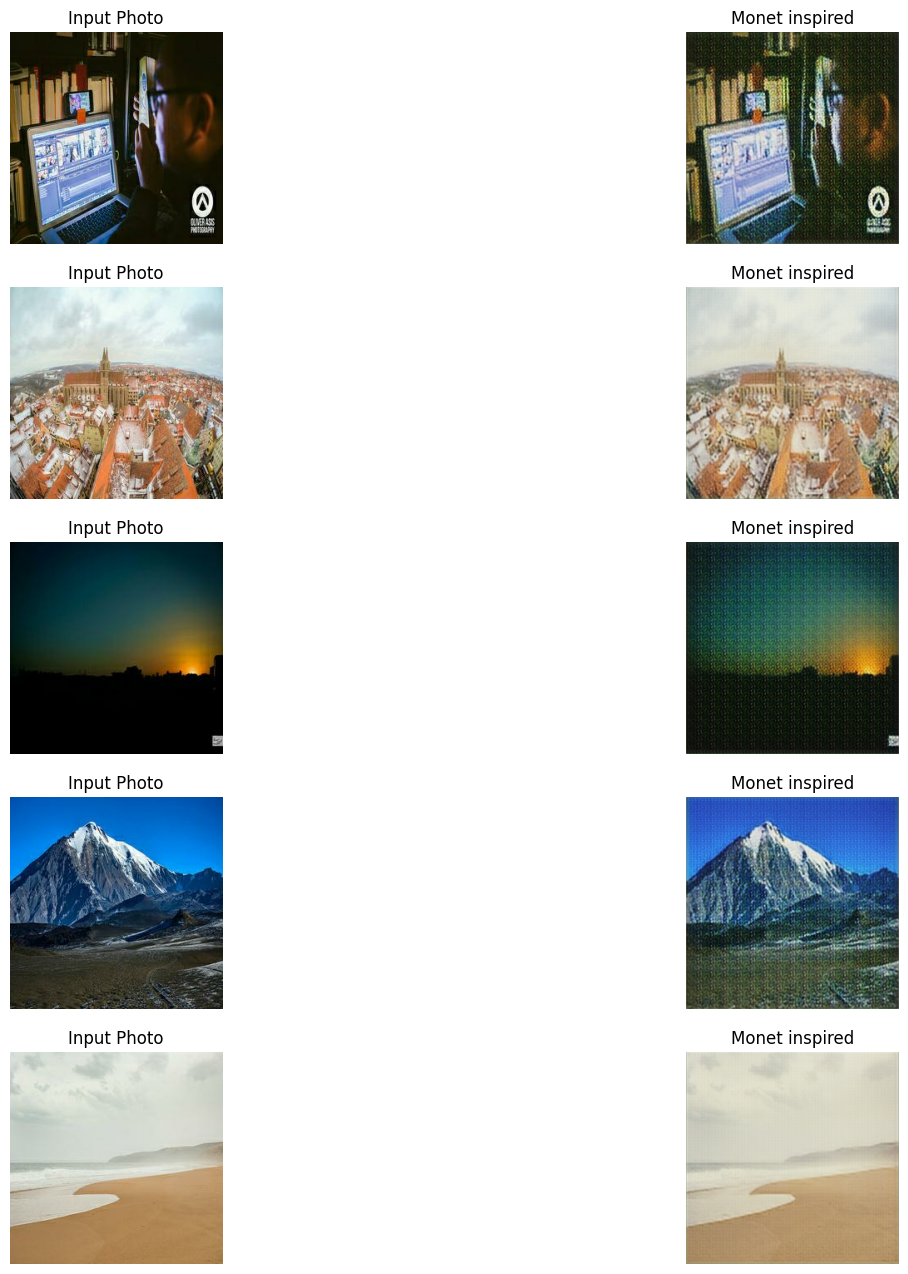

In [24]:
_, ax = plt.subplots(5, 2, figsize=(16, 16))
for i, img in enumerate(photo_dataset.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet inspired")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Submission file

In [25]:
import PIL
! mkdir ../images

In [26]:
i = 0
for img in photo_dataset:

    prediction = monet_generator(img, training=False).numpy()
    for pred_img in prediction:

        pred_img = (pred_img * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(pred_img)
        im.save("../images/" + str(i) + ".jpg")
        i += 1

    if i > 7500:
        break

In [27]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'